# Validation of the breast cancer network inferred using NORDic

## Library Import

In [1]:
import NORDic
#! conda install -c colomoto -y maboss
! pip freeze | grep "NORDic"

NORDic==2.4.2


In [3]:
import pandas as pd
from subprocess import check_output as sbcheck_output
from subprocess import call as sbcall
import numpy as np
import os
from multiprocessing import cpu_count

from NORDic.UTILS.utils_data import request_biodbnet
from NORDic.UTILS.utils_state import binarize_experiments
import NORDic.UTILS.utils_sim as utils_sim

In [4]:
file_folder="Breast_Cancer/"
network_fname=file_folder+"solution_connected.bnet"
njobs=max(1,cpu_count()-2)
seednb=12345

## Network validation from gene perturbation experiments in the literature

### 1. Add inputs and phenotypic readouts to the network

In [26]:
with open(network_fname, "r") as f:
    grf_list = f.read().split("\n")
grfs = dict([x.split(", ") for x in grf_list if (len(x)>0)])

############################
## Interesting signals    ##
############################

add_signals = []
genes_signals = []

add_signals.append("Hypoxia, 0")
genes_signals += ['HIF1A', 'VHL']
add_signals.append("HIF1A, ("+grfs["HIF1A"]+") | Hypoxia")
add_signals.append('VHL, ('+grfs["VHL"]+") | Hypoxia")

add_signals.append("DNA_Damage, !DNA_Repair")
genes_signals += ['ATM', 'NFKBIA']
add_signals.append('ATM, ('+grfs["HIF1A"]+") | DNA_Damage")
add_signals.append('NFKBIA, ('+grfs["NFKBIA"]+") & !DNA_Damage")

add_signals.append("Acidosis, 0")
genes_signals += ['TP53']
add_signals.append('TP53, ('+grfs['TP53']+") | Acidosis")

for inp in genes_signals:
    inp = "".join(inp.split("!"))
    int_match = [g for g in grfs if (inp.lower() in g.lower())]
    for gg in int_match:
        print("%s <- %s" % (gg, grfs.get(gg,"not in network")))

grf_list = [grf for grf in grf_list if all([g+", " not in grf for g in genes_signals])]
grf_list += add_signals

############################
## Interesting phenotypes ##
############################
add_readouts = []
all_readouts = [] # should not be inputs to simulations

## https://www.rockland.com/globalassets/globalpics/resources-pics/Apoptosis.png
genes_apoptosis = ['CASP8', '!BCL2']
add_readouts.append("Apoptosis, ("+(" | ".join(genes_apoptosis))+" | CytoC | Autophagia ) & !Proliferation")
all_readouts += ['CASP8', 'BCL2', "Apoptosis", "Proliferation", "CytoC", "Autophagia"]

## https://ars.els-cdn.com/content/image/1-s2.0-S095506741830187X-gr1.jpg
genes_autophagia = ["NFKBIA", "BECN1"]
add_readouts.append("Autophagia, "+(" & ".join(genes_autophagia)))
all_readouts += ['NFKBIA', 'BECN1', "Autophagia"]

##https://www.mdpi.com/cancers/cancers-12-03709/article_deploy/html/images/cancers-12-03709-g004-550.jpg
##https://www.cell.com/cms/attachment/c88101a8-721d-41b1-b13e-b5ddb02dddb8/gr1_lrg.jpg
## Markers of mesenchymal cells (and thus, of transition from epithelial cells)
genes_emt = ["NCadherin", "!ECadherin", "MMP2"] #["MMP2", "SMAD3", "CTCN"]
add_readouts.append("EMT, "+(" & ".join(genes_emt)))
all_readouts += ['NCadherin', 'ECadherin', "MMP2", "EMT"]

genes_cytoc = ["!BCL2", "!AKT1", "!AKT2", "!AKT3"]
add_readouts.append("CytoC, ("+("&".join(genes_cytoc))+") & ( CASP8 | TP53 )")
all_readouts += ['BCL2', 'AKT1', "AKT2", "AKT3", "TP53", "CytoC"]

genes_dnarepair = ["ATM"]
add_readouts.append("DNA_Repair, ("+("&".join(genes_dnarepair))+") | BRCA1")
all_readouts += ["ATM", "BRCA1", "DNA_Repair"]

genes_invasion = ["SMAD3", "!SMAD4", "Proliferation"]
add_readouts.append("Invasion, (("+("&".join(genes_invasion))+") | (CTNNB1 & Proliferation))")
all_readouts += ["SMAD3", "SMAD4", "CTNNB1", "Invasion", "Proliferation"]

genes_ecadherin = ["CTNNB1", "!ESR1", "NFKBIA"]
add_readouts.append("ECadherin, "+(" & ".join(genes_ecadherin)))
all_readouts += ["CTNNB1", "ESR1", "NFKBIA", "ECadherin"]

genes_ncadherin = ["CTNNB1"]
add_readouts.append("NCadherin, "+(" & ".join(genes_ncadherin)))
all_readouts += ["CTNNB1", "NCadherin"]

genes_migrationmetastasis = ['AKT1', 'AKT2','AKT3', "Invasion", "EMT"]
add_readouts.append("Migration-Metastasis, "+(" & ".join(genes_migrationmetastasis)))
all_readouts += ["AKT1", "AKT2", "AKT3", "Invasion", "EMT", "Migration-Metastasis"]

##https://ars.els-cdn.com/content/image/1-s2.0-S0009898111006334-gr1.jpg
genes_proliferation = ["CCNE1", "!DNA_Repair", "HRAS"] #["E2F1", "KIT", 'HRAS', 'CCNE1']
add_readouts.append("Proliferation, "+(" | ".join(genes_proliferation)))
all_readouts += ["CCNE1", "Proliferation", "DNA_Repair"]
        
grf_list += add_readouts
all_readouts = list(set(all_readouts))

network_fname_readouts = network_fname.split(".bnet")[0]+"_readouts.bnet"
with open(network_fname_readouts, "w") as f:
    f.write("\n".join(grf_list))
    
all_outputs = ["Apoptosis", "Autophagia", "CytoC", "Proliferation", "Invasion", "EMT", "Migration-Metastasis"]
all_inputs = ["Hypoxia", "DNA_Damage", "Acidosis"]

HIF1A <- PKM
VHL <- HIF1A
ATM <- POLR2E|(CASP8&CDK7)
NFKBIA <- (EP300&!JUN)|(!PRKCZ&RXRA)
TP53 <- (AKT1&BECN1&CDKN1B)|(HIC1&PLK1)


### 2. Initialize the state at t=0 (random one: no constraint on any gene)

In [32]:
initial = pd.DataFrame([], index=[g for g in grfs], columns=["initial"])

### 3. Initialize parameters of the simulations

We generate $10,000$ trajectories of length $50$

In [33]:
params = {'sample_count': 10000, 'max_time': 50}
network_fname_readouts = network_fname.split(".bnet")[0]+"_readouts.bnet" ## considering network with readouts

### 4. Literature browsing for gene perturbation experiments / reported phenotypes

**Strategy**: Checking the literature out by googling "[gene] MCF7 breast cancer" on Google Scholar (Top-$5$, Top-$10$ papers), reading mostly the abstract, and the core of the paper if needed. To reduce reading time, if no information related to cancer is present on the GeneCards page of the gene, it is ignored.

++ PRKCZ: *Protein Kinase C Zeta*

Hypermethylation of PRKCZ blocks cell proliferation [(ref)](https://doi.org/10.3390/cancers14174151)

Increased PRKC alpha expression in MCF7 cells leads to enhancer proliferation rates (transvection of PCKalpha) [(ref)](https//doig.org/10.1172/JCI117872)

PKCzeta promotes breast cancer invasion [(ref)](https://doi.org/10.1038/srep12520)

+ DAAM1: *Dishevelled Associated Activator Of Morphogenesis 1*

A key regulator of cytoskeletal architecture, the small GTPase Rho, is activated during development by Wnt/Fz signaling to control cell polarity and movement. The protein encoded by this gene is thought to function as a scaffolding protein for the Wnt-induced assembly of a disheveled (Dvl)-Rho complex. This protein also promotes the nucleation and elongation of new actin filaments and regulates cell growth through the stabilization of microtubules [(ref)](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DAAM1&keywords=Daam1)

Daam1 (Dishevelled-associated activator of morphogenesis 1) is a Wnt/PCP signaling protein that engages in cytoskeleton reorganization and is abnormally activated in certain tumors. Daam1 is closely related to cancer metastasis [(ref)](https://doi.org/10.1016/j.bcp.2023.115468)

Wnt5a activated Dvl2, Daam1 and RhoA, and promoted migration of breast cancer cells, which was, however, abolished by Secreted Frizzled-related protein 2 (sFRP2) pretreatment. Daam1 siRNA remarkably inhibited Wnt5a-induced RhoA activation, stress fiber formation and cell migration [(ref)](https://doi.org/10.1371/journal.pone.0037823)

expression levels of DAAM1 and YWHAZ were significantly upregulated in BrCa tissues compared with normal tissues and remarkably associated with poor prognosis. Besides, DAAM1 and YWHAZ were positively correlated with each other in BrCa tissues. YWHAZ regulates DAAM1 activation, and the YWHAZ–DAAM1 complex is directly targeted by the shared post-transcriptional regulator miR-613. [(ref)](https://doi.org/10.1038/s41420-021-00609-7)

The signaling pathway of dishevelled-associated activator of morphogenesis 1 (Daam1) triggered by Wnt5a drives cell movement and migration during breast cancer metastasis. Wnt5a expression and RhoA activation were upregulated in invasive glioblastoma tissues, with a significant positive correlation between them. Wnt5a activated Daam1 and RhoA [(ref)](https://doi.org/10.3892/or.2017.6124)

+ RXRA: *Retinoid X Receptor Alpha*

Stimulation of RXR (and TTNPB) by ligands in MCF7 increases (strongly) aromatase activity, which activates the production of estrogen, which activates cancer cell growth [(ref)](https://doi.org/10.1016/s0303-7207(00)00273-2)

Stimulation (agonist 6-OH-11-O-hydroxyphenanthrene) of RXR in MCF7 hampers the expression of NFKB and IL6, leading to downexpression of SNAI2, NOTCH3 and JAG1, and to the upregulation of ESR1 and KRT18 [(ref)](https://doi.org/10.1038/cdd.2011.207) => potential anticancer drug [(ref)](https://doi.org/10.1186/bcr913)

Combined anticancer therapy targeting PPARa, PPARg (which co-bind to DNA with RXRs [(ref)](https://doi.org/10.3390/cells12010130)) and RXRs, with increased sensibility to treatment when overexpressing RXRa [(ref)](https://doi.org/10.1186/bcr913)

+ SULT2A1: *Sulfotransferase Family 2A Member 1*

SULT2A1 catalyses the sulfonation (addition of a sulfonic group) of 2-methoxyestradiol in MCF7 cells. Sulfonation is linked to the solubility of a product (makes it -in general- more soluble). [(ref)](https://doi.org/10.1093/carcin/21.11.1947) 2-methoxyestradiol is reported to have an anticancer effect, as it is an angiogenesis inhibitor [(ref)]( https://doi.org/10.1592/phco.23.2.165.32088) (prevents the formation of new blood vessels [(ref)](https://pubchem.ncbi.nlm.nih.gov/compound/2-Methoxyestradiol)), and interacts poorly with estradiol receptors [(ref)](https://doi.org/10.1210/en.2002-220632).

Up-regulation of SULT2A1 might prevent MCF7 cell proliferation [(ref)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9611654/)

Co-action of the induction of estrogen sulfotransferase with anticancer drugs (tamoxifen) [(ref)](https://doi.org/10.1038/aps.2015.14)

+ IGF1R: *Insulin Like Growth Factor 1 Receptor*

It is highly overexpressed in most malignant tissues where it functions as an anti-apoptotic agent by enhancing cell survival. [(ref)](https://www.genecards.org/cgi-bin/carddisp.pl?gene=IGF1R&keywords=IGF1R)

Treatment by calycosin inhibits proliferation and induces apoptosis in ER-positive cancer cell lines, and up-regulated a subtype of ER called ERbeta. This seems to induce a down-regulation of IGF1R (and stimulation of p38 MAPK and suppression of the serine/threonine kinase (Akt), and finally poly(ADP-ribose) polymerase 1 (PARP-1) cleavage). [(ref)](https://doi.org/10.1371/journal.pone.0091245)

Treatment by IGF1R tyrosine kinase inhibitor NVP-AEW541 resulted in reduced proliferation (PubMed: 22493363) However, antagonist effects were reported when combined with anticancer drugs (tamoxifen, trastuzumab, doxorubicin or paclitaxel)

Stimulation rather than overexpression of IGF-1R is driving tamoxifen resistance to be abrogated by linsitinib [(ref)](https://doi.org/10.1002/ijc.32668)

+ POLR2H: *RNA Polymerase II, I And III Subunit H* 

Lots of works on drug testing [(ref)](https://doi.org/10.3390/ijms221810103). DEG (up-regulated) in ductal carcinoma in situ (DCIS)  compared to normal tissue, but not significatively important in overall survival [(ref)](https://doi.org/10.1002/cam4.5071)

+ RRM2: *Ribonucleotide Reductase Regulatory Subunit M2*

AKT-expressing breast cancer cells upregulate RRM2 expression, leading to increased DNA repair and protection from tamoxifen-induced apoptosis. breast cancer cells with elevated endogenous AKT or overexpression of activated AKT exhibited tamoxifen-stimulated cell proliferation and enhanced cell motility. [(ref)](https://doi.org/10.1158/1541-7786.MCR-13-0219)

inhibition of RRM2 dampened the activation of phosphatidylinositol 3 kinase (PI3K)/protein kinase B (AKT) signaling by decreasing phosphorylated‑AKT and downstream matrix metalloproteinases‑2 expression. Intriguingly, reactivation of the PI3K/AKT pathway with its agonist insulin‑like growth factor‑1 reversed the adverse effects of RRM2 suppression on cancer cell invasion, migration and VEGF expression. Together, these findings suggest that RRM2 may act as a pro‑metastatic factor to facilitate breast cancer metastasis by evoking cell invasion, migration and VEGF expression through the PI3K/AKT signaling pathway [(ref)](https://doi.org/10.3892/ol.2020.11428)

our data indicated that NEAT1, miR-21, and RRM2 were upregulated in several BC cell lines. Overexpressed of miR-21 in MDA-MB-231 cells promote proliferation and migration. Besides, our results demonstrated that overexpressed of miR-21 upregulated the level of RRM2 [(ref)](https://doi.org/10.1002/jcp.29225)

RRM2 expression was significantly correlated with age, tumor size, grade, menopausal status, molecular typing, ER, PR, and Her-2 of patients with breast cancer(P<0.05) [(ref)](https://doi.org/10.1371/journal.pone.0265195)

Furthermore, miR-4500 exerted anti-tumor effects by targeting RRM2 through suppression of the MAPK signaling pathway in vitro, evidenced by attenuated cancer cell migration and invasion and capillary-like tube formation of endothelial cells. Collectively, overexpressed miR-4500 could downregulate RRM2 and inhibit activation of the MAPK signaling pathway, thus attenuating breast cancer cell proliferation, invasion, migration, and angiogenesis and promoting breast cancer cell apoptosis. [(ref)](https://doi.org/10.1016/j.omtn.2020.04.018)

Because didox also appears to be a potent inhibitor of NF-κB activation, combining didox with tamoxifen treatment cooperatively reverses ER-α alterations and inhibits NF-κB activation. Finally, inhibition of RRM2 by didox reversed tamoxifen-resistant in vivo tumor growth and decreased in vitro migratory and invasive properties, revealing a beneficial effect of combination therapy that includes RRM2 inhibition to delay or abrogate tamoxifen resistance. [(ref)](https://doi.org/10.1158/1535-7163.MCT-14-0689)

+ MYC: *MYC Proto-Oncogene, BHLH Transcription Factor*

Up-regulation of MYC in breast cancer cell lines (both ER-positive and negative), is a cell cycle regulator with cyclin D1 [(ref)](https://doi.org/10.1016/j.mce.2004.08.002) and NFBK [(ref)](https://doi.org/10.18632/oncotarget.8875). RNAi (KD) of MYC in breast cancer cell lines (80% inactivation) reduced tumor growth in mice [(ref)](https://doi.org/10.1186/bcr975) Antisense oligonucleotide treatment reproduces this, with a stronger effect when combined with the repression of p21 [(ref)](https://aacrjournals.org/cancerres/article/62/11/3126/508881/Mechanisms-of-Growth-Arrest-by-c-myc-Antisense) 

Conversely, overexpression of MYC induces resistance to antiestrogen drugs [(ref)](https://www.sciencedirect.com/science/article/abs/pii/S0960076006002652) 50% of estrogen targets co-regulated by MYC. Moreove, the overexpression of MYC alone is enough to confer antiestrogen resistance [(ref)](https://doi.org/10.1002/ijc.10269)

+ HDAC3: *Histone Deacetylase 3* 

Oleuropein (molecule with supposed anticancer properties) might act by downregulating HDAC2 and HDAC3 (qPCR) [(ref)](https://doi.org/10.1002/jcb.28193), inducing cell apoptosis. Role of inhibition of HDAC family genes in apoptosis seems confirmed by [(ref)](https://doi.org/10.3389/fphar.2016.00081), [(ref)](https://doi.org/10.1371/journal.pone.0062610) (treatment by SAHA, inhibitor), [(ref)](https://doi.org/10.3892/ijo.2012.1534) (treatment by Sirtinol), [(ref)](https://doi.org/10.1007/s10637-011-9752-z) (treatment by MHY218)

Downregulates p53 [(ref)](https://www.genecards.org/cgi-bin/carddisp.pl?gene=HDAC3&keywords=HDAC3). Inhibition of HDAC downregulates ERalpha, and global expression of HDAC is higher in ER-positive cell lines compared to ER-negative ones [(ref)](https://doi.org/10.1016/j.bbrc.2013.02.007)

+ RHOA: *Ras Homolog Family Member A*

RHOA-KD (siRNA) inhibits Lysophosphatidic acid (LPA)-induced cell invasion [(ref)](https://doi.org/10.1007/s10238-015-0336-7) confirmed by [(ref)](https://doi.org/10.1158/0008-5472.CAN-07-5424)

NRF2 overexpression stimulates cell invasion through activation of RHOA [(ref)](https://doi.org/10.18632/oncotarget.12435)

Myosin light chain (MLC) 2 phosphorylation and RhoA activity upregulated by doxorubicin and downregulated by paclitaxel. Activation of RHOA is what drives cell invasion in the treatment by doxorubicin [(ref)](https://doi.org/10.4048/jbc.2019.22.e22) Treatment by kaempferol suppresses the migration and invasion of triple-negative breast cancer cells by downregulating the activities of RhoA and Rac1, but not on the migration of non-TNBC (including MCF-7) cells [(ref)](https://doi.org/10.2147/OTT.S140886)(cell invasion assays)

Activation of RHOA activates the expression of NFKB [(ref)](https://doi.org/10.1016/j.bbrc.2015.03.166)

RhoA and ROCK activities and expression levels of RhoA, ROCK1, ROCK2, MMP2 and MMP9 were down-regulated by RhoA siRNA transfection. RhoA silencing by siRNA dramatically inhibited LPA-enhanced invasion. [(ref)](https://doi.org/10.1007/s10238-015-0336-7)

+ CXCL8: *C-X-C Motif Chemokine Ligand 8* encodes Interleukin 8

CXCL8 secretion, and partly the secretion of VEGF, were up-regulated in monocytic cells, but not in breast tumor cells, by the CC chemokines CCL5 and CCL2. EGF potently up-regulated CXCL8 secretion by breast tumor cells, and its effect was promoted by a consecutive treatment of the cells by estrogen and progesterone. [(ref)](https://doi.org/10.1016/j.canlet.2004.05.024)

MCF7 tumor cells were more potentially promoted by hADSCs (human adipose-derived mesenchymal stem cells) in the aspects of angiogenesis and proliferation, by upregulation of CXCL1 and CXCL8 (in MCF7), and increased migration through CXCR1 and CXCR2 (their receptors) [(ref)](https://doi.org/10.1002/stem.2643)

The role of CXCL8 in the development in MCF7 is confirmed by the activation of lnc-SLC4A1-1 (through NFKB, AP1) [(ref)](https://doi.org/10.1080/21691401.2019.1664559) (through EGF) [(ref)](https://doi.org/10.1593/neo.101340)

CXCL8 overexpressed in ER-negative cell lines, but high levels of CXCL8, CXCL1, and CXCL3 accounted for a shorter relapse-free survival of ERalpha-positive patients treated with tamoxifen [(ref)](https://doi.org/10.1677/erc.1.01301)

+ CDC42: *Cell Division Cycle 42*

(Over)expressed by MCF7 cells, although often not mutated. Activates breast cancer cell proliferation through MAPK pathway [(ref)](https://doi.org/10.3390/cells8020146), and binding to scaffold protein IQGAP1 [(ref)](https://doi.org/10.1038/s41598-022-21342-w) Increases cell migration in conjunction with nicotine treatment (overexpression by vector) [(ref)](https://doi.org/10.1158/0008-5472.CAN-08-0131)

Inhibits EGF degradation [(ref)](https://doi.org/10.1158/0008-5472.CAN-05-1547)

+ NANOG: *Nanog Homeobox*

Overexpressed in breast cancer cell lines (RT-PCR) [(ref)](https://doi.org/10.3892/ol.2012.916), deregulates PDGFRalpha in mice (associated with tumorigenesis and metastasis) [(ref)](https://doi.org/10.1038/onc.2013.209)

RNAi of Nanog reduces proliferation in vitro [(ref)](https://doi.org/10.1016/j.canlet.2012.02.021), even in tamoxifen-resistant cell lines [(ref)](https://doi.org/10.2147/OTT.S67835).

Treatment with cyclohexylmethyl Flavonoids (ugonin J) significantly reduced the tumorigenicity of MCF-7 cells and efficiently suppressed formation of mammospheres. This suppression was possibly due to p53 activation and NANOG reduction as either addition of p53 inhibitor or overexpression of NANOG can counteract the suppressive effect of ugonin J. [(ref)](http://dx.doi.org/10.1155/2013/17026)

+ HIF1A: *Hypoxia Inducible Factor 1 Subunit Alpha*

Pro-apoptotic gene [(ref)](https://doi.org/10.1038/s41598-018-37796-w)

Hypoxia-induced degradation of CAV1. Hypoxia upregulates (well-established autophagy/mitophagy markers) namely LC3, ATG16L, BNIP3, BNIP3L, HIF1A and NFKB [(ref)](https://doi.org/10.4161/cc.9.17.12928) Pharmacological activation of HIF1A drives CAV1 degradation, while pharmacological inactivation of HIF1A prevents the downregulation of CAV1. Pharmacological inactivation of NFKB prevents CAV1 degradation. Acute knock-down (siRNA) of CAV1 in stromal fibroblasts is sufficient to induce autophagy

Transcription of CITED2, a transcriptional cofactor that functions in a negative feedback loop to control HIF1 activity, is induced by FOXO3a during hypoxia. FOXO3a inhibits HIF1-induced apoptosis by stimulating the transcription of CITED2, which results in reduced expression of the proapoptotic HIF1 target genes NIX and RTP801. [(ref)](https://doi.org/10.1016/j.molcel.2007.10.035)

+ RB1: *RB Transcriptional Corepressor 1*

Tumor suppressor gene [(ref)](https://doi.org/10.1016/j.biopha.2016.12.091)

A switch from catabolic to anabolic metabolism, a major hallmark of cancer, enables rapid cell duplication, and is driven by multiple oncogenic alterations, including PIK3CA mutation, MYC amplification, and TP53 loss [(ref)](https://doi.org/10.1016/j.trecan.2017.09.002)

Studied a lot in triple negative cancers (TNCs) [(ref)](https://doi.org/10.1371/journal.pone.0078641)

Reported interaction with TP53, TP21, TP16 and KI-67 [(ref)](https://doi.org/10.1371/journal.pone.0011404)

Frequently downregulated/mutated(? "lost") in BC [(ref)](https://doi.org/10.4161/cc.10.10.15703)

+ AURKB: *Aurora Kinase B* 

Downregulation of MGMT decreases CDC2, CDC20, TOP2A, AURKB, KIF20A, cyclin B2, A2, D1, ERα and survivin and induces c-PARP and p21 (by treatment with O6-benzylguanine (BG), an MGMT inhibitor, or with siRNA) [(ref)](10.18632/oncotarget.25696)

RNAi screens conducted in combination with rapamycin in multiple breast cancer cell lines identified six genes, AURKB, PLK1, PIK3R1, MAPK12, PRKD2, and PTK6 that when silenced, each enhanced the sensitivity of multiple breast cancer lines to rapamycin [(ref)](https://doi.org/10.1016/j.canlet.2014.08.043)

Regulates resistance to paclitaxel in breast cancer cells [(ref)](https://doi.org/10.1007/s13577-022-00675-8)

+ WEE1: *WEE1 G2 Checkpoint Kinase*

Inhibits CDC2/CDK1/CCNB1, G2/M checkpoint regulator protein. Knockdown with shRNA decreases MCF7 proliferation, up-regulates P53, down-regulates VEGF and BCL2. [(ref)](http://dx.doi.org/10.7314/APJCP.2013.14.11.6605)

Inhibition by small molecule MK-1775 sensitizes breast cancer cells to paclitaxel and promotes cancer cells to bypass the cell-cycle checkpoints and prematurely enter mitosis. [(ref)](https://doi.org/10.18632/oncotarget.17848)

Inhibition improves response to CDK4/6 inhibitors and endocrine therapy [(ref)](https://doi.org/10.3389/fonc.2021.681530)

Forced activation of Cdk1 via wee1 inhibition did not cause cytotoxicity. Instead, it accelerated mitotic entry and caused radio sensitization in p53-defective cancer cells, but not in p53-proficient cancer cells. [(ref)](https://doi.org/10.1038/onc.2012.296)

+ EPAS1: *Endothelial PAS Domain Protein 1* also named HIF2a

Chronic hypoxia (48 h, 1% O2) continuously enhanced HIF-2α expression and induced the resistance of breast cancer cells to Paclitaxel (PTX) [(ref)](https://doi.org/10.1186/s13046-018-0925-x) Stem cell markers: c-Myc, OCT4 and Nanog, overexpression of EPAS1 activates the Wnt/NOTCH pathways [(ref)](https://doi.org/10.1186/s13046-018-0925-x)

MBD3 amplifies the expression of EPAS1 by binding to one of its promoters [(ref)](https://doi.org/10.1007/s13277-016-5237-1)

+ EFNA1: *Ephrin A1*

Differentially regulated after treatment with estrogens on a subline of MCF7 [(ref)](https://www.researchgate.net/profile/Julie-Vendrell/publication/8628404_Estrogen_regulation_in_human_breast_cancer_cells_of_new_downstream_gene_targets_involved_in_estrogen_metabolism_cell_proliferation_and_cell_transformation/links/568cff5408ae197e426b654d/Estrogen-regulation-in-human-breast-cancer-cells-of-new-downstream-gene-targets-involved-in-estrogen-metabolism-cell-proliferation-and-cell-transformation.pdf)

We now show that Hic1 is a direct transcriptional repressor of the gene encoding the Eph receptor ligand Ephrin A1 (Efna1) [(ref)](https://aacrjournals.org/cancerres/article/69/9_Supplement/3831/553090/Abstract-3831-Roles-for-Hic1-in-tumor-suppression) (restoration of HIC1 in lines where it is epigenetically silenced, observe direct effect on EFNA1)

+ MET: *MET Proto-Oncogene, Receptor Tyrosine Kinase*

Substantial activation of the HGF/c-Met signaling pathway is involved in the progression of several types of cancers and associated with increased tumor invasion and metastatic potential [(ref)](https://doi.org/10.1021/jf2021489)

Upregulated c-Met expression in MCF7 facilitates their stimulation by HGF/SF-secreting stromal fibroblasts, leading to the activation of Src, Akt and ERK1/2 and a profound enhancement of their aggressive phenotype in vitro (KD of MET) [(ref)](https://doi.org/10.1677/erc.1.01270)

Crizotinib is a small-molecule tyrosine kinase inhibitor of MET. anticancer effects of combined crizotinib and endocrine drugs (4-hydroxytamoxifen/Afimoxifene binding to estrogen receptors ERR1gamma [(ref)](https://doi.org/10.1073/pnas.151244398), TFF1, NR1I2, SHBG, ESR1, ESR2, ESRRG [(ref)](https://go.drugbank.com/drugs/DB04468)) suppressed migration and colony formation of MCF7 and T-47D cells. Immunofluorescence showed a significant reduction of the expression of the nuclear protein Ki-67. The combination treatment reduced the levels of active and total MET, estrogen receptor α (ERα), total and active levels of AKT, ERK, c-SRC, NFĸB p65, GSK-3β, and the anti-apoptotic BCL-2 protein

+ JAK1: *Janus Kinase 1* 

Aberrant activation of these non-receptor tyrosine kinases (JAK1, JAK2, JAK3 and TYK2) may contribute to carcinogenesis [(ref)](https://doi.org/10.1016/j.acthis.2011.11.010). Decreased p-JAK1 expression in breast cancer tissues was significantly correlated with positive estrogen receptor (ER) status and increased tumor size (p=0.010 and 0.009) [(ref)](https://doi.org/10.3892/or.17.1.35)

0.1 Gy radiation dose reduces cancer progression by deactivating the JAK1/STAT3 pathway [(ref)](https://doi.org/10.1038/srep43361)

serotonin, through 5-HTR2A/C, interferes with breast cancer cells proliferation and metabolism by triggering two distinct signalling pathways: Jak1/STAT3 that boosts glycolysis through upregulation of PKM2, and adenylyl cyclase/PKA that enhances mitochondrial biogenesis. [(ref)](https://doi.org/10.1038/s41416-019-0640-1)

 JAK1/JAK2 inhibitor treatment decreased STAT1 phosphorylation. The cytotoxic effect of ASC-CM was reduced especially by JAK1 inhibitors in MCF-7 cells [(ref)](https://doi.org/10.1016/j.canlet.2014.06.018)
 
  interaction between DPYSL2 and Janus kinase 1 (JAK1). This binding is crucial for activating signal transducer and activator of transcription 3 (STAT3) and the subsequent expression of vimentin, the promigratory intermediate filament. These findings identify DPYSL2 as a molecular link between oncogenic signaling pathways and cytoskeletal reorganization in migrating breast cancer cells. => EMT, Migration [(ref)](https://doi.org/10.1083/jcb.202106078)

+ GSK3A: *Glycogen Synthase Kinase 3 Alpha*

Lots of studies on drug treatment [(ref)](https://doi.org/10.18632/oncotarget.7443) [(ref)](https://doi.org/10.1023/B:BREA.0000041623.21338.47)

+ MAP3K7: *Mitogen-Activated Protein Kinase Kinase Kinase 7*

miR-143 expression negatively correlated with expressions of p-ERK5, ERK5, p-MAP3K7, MAP3K7 and cyclin D1 and cell viability [(ref)](https://doi.org/10.1590/1414-431X20175891)

mutant SF3B1 (KO) promoted aberrant splicing [...] and consequent suppression of PPP2R5A and MAP3K7, critical negative regulators of AKT and NF-κB [(ref)](https://doi.org/10.1172/JCI138315)

+ CTNNA1: *Catenin Alpha 1*

a genome-wide CRISPR/Cas9 screen in MCF7 breast cancer cells to identify genes whose loss of function reverse Beclin 1 (BECN1)-dependent inhibition of cellular proliferation: CDH1 and CTNNA1. CRISPR/Cas9-mediated knockout of CDH1 or CTNNA1 reversed Beclin 1-dependent suppression of breast cancer cell proliferation and anchorage-independent growth [(ref)](https://doi.org/10.1073/pnas.2020478118) Autophagy genes: BECN1, PI3KC3-C2, UVRAG, ATG14, ATG13, ATG5, or ATG7, 

SiRNA of CTNNA1, CTNNB1, TLN1, VCL, PXN, and ACTN1 resulted in a reduction of cell viability [(ref)](https://doi.org/10.3390/pharmaceutics11070309)

+ FZD1: *Frizzled Class Receptor 1* 

Frizzled 1 (FZD1) protein, which is an essential component of the Wnt/β-catenin pathway, is overexpressed in the multidrug resistant breast cancer cell subline MCF-7/ADM. FZD1 silencing induced down-regulation of MDR1/P-gp, restored sensitivity to four chemotherapy drugs, and significantly decreased cytoplasmic and nuclear β-catenin levels. [(ref)](https://doi.org/10.1016/j.canlet.2012.03.039)
 
+ LRP6: *LDL Receptor Related Protein 6*

High expression of low-density lipoprotein receptor-related protein 6 (LRP6) is usually observed in breast carcinoma and predicts poor prognosis. Knockdown LRP6 with siRNA repressed cell mobility and invasion, wheras overexpression of LRP6 promoted EMT and antagonized the EMT inhibitory effect of CA on MCF-7 cells. [(ref)](https://doi.org/10.1124/jpet.122.001189)

LRP6 overexpression induced mTORC1 signaling activation in cancer cells [(ref)](https://doi.org/10.1002/jcb.24850)

small interference RNA (si-RNA) knockdown of LRP6 significantly reduced the clonogenic rate as well as the migration and invasion abilities of MCF-7 cells [(ref)](https://doi.org/10.21037/gs-21-194) [(ref)](https://doi.org/10.1038/s41388-022-02259-0) Conversely, overexpression of LRP6 aggravates breast cancer [(ref)](https://doi.org/10.1073/pnas.0911220107)

OX9 overexpression in BCa cell lines and transgenic SOX9 expression in breast epithelium caused increased LRP6 and TCF4 expression and Wnt/β-catenin activation. [(ref)](https://doi.org/10.1074/jbc.M112.419184)

+ SUZ12: *Polycomb Repressive Complex 2 Subunit*

expression of FOXC1 gene was negatively correlated to that of PcG genes, i.e., Bmi1, EZH2, and SUZ12, in MCF-7 and MDA-MB-231 cells [(ref)](https://doi.org/10.1007/s10549-011-1396-3)

 ChIP assay demonstrated TRPS1 directly inhibited SUZ12 transcription by binding to the SUZ12 promoter. Loss of TRPS1 resulted in increased SUZ12 binding and H3K27 tri-methylation at the CDH1 promoter and repression of E-cadherin [(ref)](https://doi.org/10.1016/j.tranon.2018.01.009)
 
 Suz12 depletion blocks the formation and maintenance of mammospheres, and in combination with chemotherapy suppresses tumor growth and prolongs remission in mouse xenografts [(ref)](https://doi.org/10.1016/j.molcel.2010.08.013)

+ JAK2: *Janus Kinase 2*

Aberrant activation of these non-receptor tyrosine kinases (JAK1, JAK2, JAK3 and TYK2) may contribute to carcinogenesis [(ref)](https://doi.org/10.1016/j.acthis.2011.11.010). 

 JAK1/JAK2 inhibitor treatment decreased STAT1 phosphorylation. The cytotoxic effect of ASC-CM was reduced especially by JAK1 inhibitors in MCF-7 cells [(ref)](https://doi.org/10.1016/j.canlet.2014.06.018)

Cancer stem cell markers: CD44, β-catenin, MDR1, and MRP1. Epithelial–mesenchymal transition (EMT) markers: snail, slug, MMP9, and MMP2 [(ref)](https://doi.org/10.3390/nu12061663)

Ruxolitinib, a potent JAK2 inhibitor, was demonstrated to attenuate STAT3 phosphorylation and the proliferation of TAMR‑MCF‑7 cells. [(ref)](https://doi.org/10.3892/ol.2019.10059) confirmed by [(ref)](https://doi.org/10.1073/pnas.1910278117)

+ CXCL5: *C-X-C Motif Chemokine Ligand 5*

Breast tumor-associated osteoblast-derived CXCL5 increases cancer progression by ERK/MSK1/Elk-1/Snail signaling pathway [(ref)](https://doi.org/10.1038/onc.2012.444)

these results indicate for the first time that ASC‑secreted CXCL5 is a key factor promoting breast tumor cell proliferation. [(ref)](https://doi.org/10.3892/ol.2017.7522)

+ VCAM1: *Vascular Cell Adhesion Molecule 1*

Allicin (0.1–10 ng/ml) inhibited TNF-α-induced VCAM-1 protein expression in MCF-7, but not in MDA-MB-231 Allicin strongly suppressed TNF-α-induced activation of ERK1/2. [(ref)](https://doi.org/10.1016/j.jff.2015.03.017)

+ NEDD8: *Ubiquitin Like Modifier* 

Enables ubiquitin protein ligase binding activity. Acts upstream of or within protein neddylation [(ref)](https://www.genecards.org/cgi-bin/carddisp.pl?gene=NEDD8&keywords=NEDD8)

 MLN4924, a newly discovered investigational small molecule inhibitor of NAE (NEDD8 Activating Enzyme) that inactivates SCF E3 ligase, could act as a novel radiosensitizing agent in breast cancer cells. p21 knockdown via siRNA partialy inhibited MLN4924-induced G2/M arrest and radiosensitization, indicating a causal role played by p21 [(ref)](https://doi.org/10.1371/journal.pone.0034079)
 
 Inhibition of NEDD8 activation and conjugation diminished polyubiquitination of ERα and blocked proteasome-mediated degradation of receptor protein. [(ref)](https://doi.org/10.1210/me.2002-0323)

+ PPP2CA: *Protein Phosphatase 2 Catalytic Subunit Alpha*

In vitro, miR-345-3p mimics promoted AKT phosphorylation by targeting its negative regulator, PPP2CA. Blocking miR-345-3p relieved its inhibition of PPP2CA, which attenuated PI3K-AKT signaling pathway. In vivo, inhibiting miR-345-3p by miR-345-3p-inhibition lentivirus suppressed tumor growth and invasiveness in mice. [(ref)](https://doi.org/10.1093/carcin/bgab124)

In silico, KM-plotter analysis revealed higher gene (mRNA) expressions of SET, PPP2CA and Akt1 significantly correlated with worse RFS in breast cancer patients receiving adjuvant tamoxifen therapy. [(ref)](https://doi.org/10.1158/1538-7445.AM2018-4612)

In the Oncomine database, when compared with normal breast tissues, PPP1CA, PPP2CA, PPP4C and PPEF1 were significantly elevated in breast cancer tissues, while PPP1CB, PPP2CB, PPP3CA, PPP3CB, PPP3CC and PPP6C were significantly decreased in breast cancer tissues [(ref)](https://doi.org/10.1080/21655979.2021.2012316)

+ KDR: *Kinase Insert Domain Receptor* (also called VEGFR-2)

Downregulation of KDR inhibits cancer growth proliferation (siRNA, [(ref)](https://pubmed.ncbi.nlm.nih.gov/18177622)), induces cell apoptosis, reduces expression of Bcl-2 and Bcl-xl, increases Bax expression [(ref)](https://doi.org/10.2478/s11658-014-0210-8)

PTTG1 stimulates the expression of FGF2, VEGF but not KDR [(ref)](https://doi.org/10.1210/jc.2002-020309), [(ref)](https://doi.org/10.1006/bbrc.1995.2832)

+ BECN1: *Beclin 1*

Induces autophagy [(ref)](https://doi.org/10.1038/cdd.2008.51), [(ref)](https://doi.org/10.1371/journal.pone.0008604)

we found that low BECN1 mRNA correlates with ERBB2-overexpression in breast cancers, suggesting that BECN1 loss and ERBB2 overexpression may functionally interact in mammary tumorigenesis [(ref)](https://doi.org/10.4161/auto.27867)

By performing a genetic screen to identify genes whose loss blocks the ability of Beclin 1 to inhibit the growth of breast cancer cells and follow-up biological analyses, we have identified a mechanism by which Beclin 1 prevents breast cancer growth. We found that Beclin 1 promotes the plasma membrane localization of E-cadherin, a breast tumor-suppressor molecule that restricts tumor growth and metastases only when present at the cell surface. [(ref)](https://doi.org/10.1073/pnas.2020478118).

SLC9A3R1 then attenuated the interaction between BECN1 and BCL2 to stimulate the autophagic core lipid kinase complex. [(ref)](https://doi.org/10.1080/15548627.2015.1074372)

+ IRF1: *Interferon Regulatory Factor 1*

IRF1 is a tumor suppressor that mediates cell fate by facilitating apoptosis and can do so with or without functional p53. [(ref)](https://doi.org/10.4061/2011/912102)

Increased IRF1 activation suppresses NF-κB p65 (RELA) activity, inhibits the expression of prosurvival (BCL2, BCL-W), and induces the expression of proapoptotic members (BAK, mitochondrial BAX) of the BCL2 family, activation of caspase-7 (CASP7), CASP8, and CASP9 (confirmed by [(ref)](https://aacrjournals.org/cancerres/article/68/9_Supplement/2277/545871)); and induction of apoptosis but not autophagy. The abilities of IFNγ to activate CASP8, induce apoptosis, and restore antiestrogen sensitivity are prevented by siRNA targeting IRF1, whereas transient overexpression of IRF1 mimics the effects of IFNγ treatment [(ref)](https://doi.org/10.1158/1535-7163.MCT-09-1169)

Here, we report an inverse correlation in expression of nuclear IRF1 and the autophagy regulator ATG7 in human breast cancer cells that directly affects their cell fate. Mechanistic investigations identified ATG7 and the cell death modulator beclin-1 (BECN1) as negative regulators of IRF1. Conversely, silencing IRF1 promoted autophagy by increasing BECN1 and blunting IGF1 receptor and mTOR survival signaling [(ref)](https://doi.org/10.1158/0008-5472.CAN-14-1851)

Loss of function/low expression in cancer cells [(ref)](https://doi.org/10.1007/s10549-009-0509-8)

RNAi-mediated ablation of Irf1 in mammary epithelial cells results in the expression of mesenchymal factors and Smad transcriptional activity. Conversely, ablation of Irf1 during TGFβ-induced EMT prevents a mesenchymal transition and stabilizes the expression of E-cadherin. [(ref)](https://doi.org/10.1038/s41388-020-1326-0)

+ PGR: *Progesterone Receptor*

Thus, EGF appears to down regulate the ER by approximately 50% and to diminish the ability of estradiol to induce PgR [(ref)](https://aacrjournals.org/cancerres/article/49/3/576/494463/Decrease-in-Estradiol-stimulated-Progesterone)

+ SMAD4: *SMAD Family Member 4*

The protein acts as a tumor suppressor and inhibits epithelial cell proliferation. It may also have an inhibitory effect on tumors by reducing angiogenesis and increasing blood vessel hyperpermeability. [(ref)](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SMAD4&keywords=SMAD4)

The results suggest a novel negative regulation of ERα by TGF-β/SMAD4 in breast cancer cells and indicate that the SMAD4 protein is involved in the degradation of ERα induced by bergapten. [(ref)](https://doi.org/10.1007/s10549-012-2282-3)

Smad4 induces apoptosis in ERα-positive MCF-7 breast cancer cells [(ref)](https://doi.org/10.1074/jbc.M505071200)

SMAD4 is a downstream mediator of transforming growth factor beta [(ref)](https://doi.org/10.1007/s13277-013-1088-1)

BMP-2 potently inhibited the proliferation of breast cancer cell lines that express both Smad1 and Smad4 [(ref)](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=c5f6009deca4456f212e4a09f7e51d0cfbb3d2ce)

Smad4-expression correlated positively with expression of TGF-β-receptor I (p < 0.001, n = 197) and TGF-β-receptor II (p < 0.001, n = 197) [(ref)](https://doi.org/10.1186/1471-2407-6-25)

+ CDC25A: *Cell Division Cycle 25A*

DIM inhibited the breast cancer cell growth in vitro and in vivo, and caused cell-cycle arrest by down-regulating protein levels of cell-cycle related kinases CDK1, CDK2, CDK4, and CDK6, as well as Cyclin B1 and Cdc25A. [(ref)](https://doi.org/10.1007/s11010-011-0985-0)

Here we show that Cdc25A is overexpressed in primary breast tumors and that such overexpression is correlated with higher levels of cyclin-dependent kinase 2 (Cdk2) enzymatic activity in vivo. [(ref)](https://doi.org/10.1172/JCI9174)

Cdc25A is essential for G1/S transition induced by E2 in MCF-7 cells, and that Cdk2 is essential for Cdc25A activation in vivo. [(ref)](https://doi.org/10.1016/S1043-2760(01)00436-2)

+ PEBP1: *Phosphatidylethanolamine Binding Protein 1* (also called RKIP)

One involves RELA (transcription factor p65) and SNAI1, which were previously reported to inhibit PEBP1. The other involves the estrogen receptor (ESR1), which induces PEBP1 through the kinase NME1. PEBP1 inhibits cancer metastasis at different stages, including epithelial to mesenchymal transition (EMT), migration, and invasion. Low expression of PEBP1 is associated with cancer metastasis and poor prognosis [(ref)](https://doi.org/10.3390/cancers13236098)

MiR-4443 promotes the migration and invasion of breast cancer cells by inhibiting the expression of PEBP1 [(ref)](https://doi.org/10.12122/j.issn.1673-4254.2020.12.03)

+ CREBBP: *CREB Binding Protein*

LINC01857 promoted breast cancer development by promoting H3K27Ac and CREB1 transcription via enhancing CREBBP enrichment in the CREB1 promoter region [(ref)](https://doi.org/10.1002/jcp.28090)

+ IRS1: *Insulin Receptor Substrate 1*

IRS-1 overexpression has been associated with breast cancer development, hormone independence and antiestrogen resistance. [(ref)](https://doi.org/10.1021/bc070135v)

Decreasing IRS1 in MCF7 cells decreases ERalpha expression levels. [(ref)](https://doi.org/10.1016/j.canlet.2013.03.030)

In particular, we found that, in addition to AKT and ERK1/2 activation, FGFR1-induced activation of IRS1 and IGF1R, key regulators connecting metabolism and cancer, was associated with metformin resistance. [(ref)](https://doi.org/10.1016/j.bbamcr.2020.118877)

action of anti-IRS1 siRNAs induced the apoptotic response, observed by altered mitochondrial membrane potential coupled with downregulation of NF-κB target Bcl-xL and reduced cell viability [(ref)](https://doi.org/10.1002/jcb.20817)

High glucose and high insulin conditions promote MCF‑7 cell proliferation and invasion by upregulating IRS1 and activating the Ras/Raf/ERK pathway [(ref)](https://doi.org/10.3892/mmr.2017.7420)

miR-30e blocked the activation of AKT and ERK1/2 pathways, and the expression of HIF-1α and VEGF via directly targeting IRS1 [(ref)](https://doi.org/10.1038/s41598-017-16175-x)

+ CCR2: *C-C Motif Chemokine Receptor 2*

Estrogen promotes progression of hormone-dependent breast cancer through CCL2-CCR2 (increased secretion of CCL2, activation of AKT and NFBK phosphorylation (either enhances/inhibits [(ref)](https://doi.org/10.3390/cells5010012)) axis by upregulation of Twist via PI3K/AKT/NF-κB signaling => axis CCL2-CCR2 potentially anticancer [(ref)](https://doi.org/10.1038/s41598-018-27810-6)

The G protein-coupled receptor CCR2 was found to be elevated in breast cancers, correlating with CCL2 expression. RNA interference of CCR2 expression in breast cancer cells significantly inhibited CCL2-induced migration, survival, and phosphorylation of Smad3 and p42/44MAPK proteins. [(ref)](https://doi.org/10.1074/jbc.M112.365999)

+ GADD45A: *Growth Arrest And DNA Damage Inducible Alpha*

This gene is a member of a group of genes whose transcript levels are increased following stressful growth arrest conditions and treatment with DNA-damaging agents. The protein encoded by this gene responds to environmental stresses by mediating activation of the p38/JNK pathway via MTK1/MEKK4 kinase. [(ref)](https://www.genecards.org/cgi-bin/carddisp.pl?gene=GADD45A&keywords=GADD45A)

ERβ inhibits CDK1 activity, which is the critical determinant of the G2/M progression. Cyclin B1 is the major activator of CDK1. GADD45A and BTG2 are two major inhibitors of CDK1, which have been implicated in breast tumor formation. ERβ stimulates GADD45A and BTG2 mRNA levels. The induction of these two genes is caused by ERβ binding directly to these genes and recruiting c-jun and NCOA2. ERβ causes a G2 cell cycle arrest by inactivating CDK1 through the repression of cyclin B1 and stimulation of GADD45A and BTG2 expression. [(ref)](https://doi.org/10.1007/s10549-010-1273-5)

methylation-sensitive genes in breast cancer including the BRCA1 and p53 responsive gene, GADD45a. [(ref)](https://www.nature.com/articles/1208464)

BIRC5 upregulation and GADD45A downregulation in breast cancer were associated with patient’s overall survival. Genetic knockdown of BIRC5 expression in MCF-7 decreased cell viability, supporting the pro-survival role of BIRC5 in breast cancer cells. [(ref)](https://doi.org/10.1158/1538-7445.AM2019-4715) (confirmed by [(ref)](https://doi.org/10.1016/j.biopha.2021.112431))

Furthermore, knockdown of Foxo3A reduced the expression of Noxa and Gadd45A in MCF7 cells. Strikingly, in the microarray data sets derived from breast cancer patients, expression of Foxm1, Plk1, Survivin, Cdk2 and Cdc2 in ERα+ tumors showed a strong correlation with poor prognosis, while expression of Gadd45A and BTG2 correlated with good prognosis [(ref)](https://doi.org/10.1002/ijc.29404) 

+ PML: *PML Nuclear Body Scaffold* (or *promyelocytic leukemia*?)

+ PTPN6: *Protein Tyrosine Phosphatase Non-Receptor Type 6*

Breast cancer is linked to hyperactivation of protein tyrosine kinases (PTKs) [(ref)](https://doi.org/10.1016/j.bbcan.2013.06.001)

In vitro and in vivo studies showed that the inhibitory effects of Compound 12 on phospho-STAT3 were through up-regulation of the protein–tyrosine phosphatase PTPN6. The aberrant activation of STAT3 occurs in many human cancers and promotes tumor progression. Phosphorylation of a tyrosine at amino acid Y705 is essential for the function of STAT3. [(ref)](https://doi.org/10.1021/jm4018042)

+ PPP2R5E: *Protein Phosphatase 2 Regulatory Subunit B'Epsilon*

Most notably, our results showed that treatment of MCF-7 cells with EFA-CLA (compared to EFA) increased the mRNA expression of known tumor suppressors, such as TSC2, PTEN, PPP2R5E, and LMCD1. Information on PPP2R5E is limited, but it has been suggested as a potential negative regulator of PI3K/AKT signaling (2016). It has been also found to act as a tumor suppressor in breast cancer and gastric cancer cells [(ref)](https://doi.org/10.1186/s12263-016-0537-z) (Downregulation of PPP2R5E [(ref)](https://doi.org/10.1016/j.febslet.2014.05.068)). 

+ ANAPC10: *Anaphase Promoting Complex Subunit 10*

ANAPC10 is a core subunit of the anaphase-promoting complex (APC), or cyclosome, a ubiquitin protein ligase that is essential for progression through the cell cycle. [(ref)](https://www.genecards.org/cgi-bin/carddisp.pl?gene=ANAPC10&keywords=ANAPC10)

+ FZD6: *Frizzled Class Receptor 6*

Frizzled receptors mediate Wnt ligand signalling, which is crucially involved in regulating tissue development and differentiation, and is often deregulated in cancer. Ablation of FZD6 expression in mammary cancer cell lines: (1) inhibited motility and invasion; (2) induced a more symmetrical shape of organoid three-dimensional cultures; and (3) inhibited bone and liver metastasis in vivo. [(ref)](https://doi.org/10.1002/path.4841)

breast cancer patients with high FZD6 gene expression showed worse DMFS, while high FZD4 levels were associated with favorable DMFS [(ref)](https://ediss.uni-goettingen.de/handle/11858/14387)

the positive regulation induced by WNT4 on its cognate receptor FZD6. [(ref)](http://dx.doi.org/10.1530/ERC-15-0528)

+ DKK2: *Dickkopf WNT Signaling Pathway Inhibitor 2*

 It can act as either an agonist or antagonist of Wnt/beta-catenin signaling, depending on the cellular context and the presence of the co-factor kremen 2. Activity of this protein is also modulated by binding to the Wnt co-receptor LDL-receptor related protein 6 (LRP6). [(ref)](https://www.genecards.org/cgi-bin/carddisp.pl?gene=DKK2&keywords=DKK2)
 
 Dickkopf-related protein 2 (DKK2) is one of the antagonists of Wnt/β-catenin signaling, with its downregulation reported in multiple cancers. restored expression of DKK2 in MCF7 cells disrupted the microtube formation of human umbilical vein endothelial cells on Matrigel®. DKK2 suppressed canonical Wnt/β-catenin signaling by inhibiting β-catenin activity with decreased active β-catenin protein. [(ref)](https://doi.org/10.18632/oncotarget.17055)
 
 miR-586 induced Wnt/β-catenin activation by directly targeting Wnt/β-catenin signaling antagonists SFRP1 and DKK2/3 [(ref)](https://doi.org/10.1016/j.omtn.2021.06.007)
 
 Downregulated in MCF7 cells [(ref)](https://doi.org/10.1111/jcmm.16260)
 
+ MAPK10: *Mitogen-Activated Protein Kinase 10*

Jolkinolide B significantly prolonged the survival time of luminal B subtype breast cancer patients. MAPK10 is a common target between Jolkinolide B and luminal A subtype breast cancer. [(ref)](https://doi.org/10.1016/j.jep.2021.114581)

 MicroRNA-21 promotes progression of breast cancer via inhibition of mitogen-activated protein kinase10 (MAPK10) [(ref)](https://doi.org/10.1042/bsr20181000)
 
 E2 inhibited VIM, TMC5, ETV6, and MAPK10 expression in MCF-7 cells [(ref)](https://doi.org/10.1038/s41598-018-26429-x)

+ HRAS: *HRas Proto-Oncogene, GTPase*

MAP2K1, PIK3CA, HRAS, EGFR, Caspase3, and PTGS2 were the hub targets of Syringin against BC. And PIK3CA and HRAS were related to the survival and prognosis of BC patients. Syringin inhibited the proliferation and migration and promoted apoptosis of BC cells [(ref)](https://doi.org/10.1186/s12967-022-03504-6)

TGFBR16A Enhances the Migration and Invasion of MCF-7 Breast Cancer Cells through RhoA Activation [(ref)](https://doi.org/10.1158/0008-5472.CAN-07-5424)

NRF2 promotes breast cancer cell proliferation and metastasis by increasing RhoA/ROCK pathway signal transduction [(ref)](https://doi.org/10.18632/oncotarget.12435)

+ ESR1: *Estrogen Receptor 1*

Estrogen stimulates the growth of cancer cell [(ref)](https://doi.org/10.1016/s0303-7207(00)00273-2)

Estrogen alpha (ERa) (directly) suppress TP53/TP21 and up-regulates PCNA and (proliferation-related) KI-67 to promote proliferation in MCF7 [(ref)](https://doi.org/10.1111/febs.12658)

Estrogen promotes progression of hormone-dependent breast cancer through CCL2-CCR2 (increased secretion of CCL2, activation of AKT and NFBK phosphorylation (either enhances/inhibits [(ref)](https://doi.org/10.3390/cells5010012)) axis by upregulation of Twist via PI3K/AKT/NF-κB signaling => axis CCL2-CCR2 potentially anticancer [(ref)](https://doi.org/10.1038/s41598-018-27810-6)

MCF7 cells are ERa-positive [(ref)](https://ar.iiarjournals.org/content/35/6/3147)

The earliest known growth-regulatory gene activated by E2 is MYC. Treatment of quiescent MCF-7 cells with E2 leads to cyclin D1 synthesis and activation of cyclin D1–Cdk4. Treatment of MCF-7 or T-47D cells with antiestrogens elicits G1 arrest with decreased expression of cyclin D1 and cyclin A, suppression of Cdk4 and Cdk2 activities. E2 downregulate Cdk2 inhibitors [(ref)](https://doi.org/10.1016/S1043-2760(01)00436-2)

+ IL2RB: *Interleukin 2 Receptor Subunit Beta*

Nothing on perturbations of IL2RB

+ PTEN: *Phosphatase And Tensin Homolog*

Work on treatment by curcuma on BPA-perturbed cells [(ref)](https://doi.org/10.1002/ptr.5167), increased sensibility to treatment [(ref)](https://doi.org/10.1093/annonc/mdh388). On Tamoxifen resistance [(ref)](https://doi.org/10.1007/s10549-010-1304-2)

Matrine inhibited MCF-7 cell growth in a concentration-and time-dependent manner, by inducing apoptosis and cell cycle arrest at G1/S phase. Matrine up-regulated PTEN by downregulating miR-21 which in turn dephosphorylated Akt, resulting in accumulation of Bad, p21/WAF1/CIP1 and p27/KIP1. [(ref)](https://doi.org/10.1159/000341444)

up-regulation of the key upstream signaling factor, PTEN, in MCF-7/DOX cells inhibited Akt phosphorylation, which ultimately causes increase in their regulatory p53 levels affecting the induction of G2/M cell cycle arrest and apoptosis. [(ref)](https://doi.org/10.1016/j.mrfmmm.2010.10.007)

When we overexpressed PTEN in MCF-7, growth suppression was observed, but only if PTEN phosphatase activity is preserved. [...] Of note, the decrease in Akt phosphorylation preceded the onset of suppression of cell growth. Treatment of MCF-7 cells with wortmannin, a PI3K inhibitor, caused cell growth inhibition in a way similar to the effects of overexpression of PTEN in this cell. In general, the inverse correlation between PTEN protein level and Akt phosphorylation was found in a panel of breast cancer cell lines. Therefore, PTEN appears to suppress breast cancer growth through down-regulating PI3K signaling [(ref)](https://aacrjournals.org/cancerres/article/59/22/5808/505640/PTEN-Suppresses-Breast-Cancer-Cell-Growth-by)

+ ARHGAP35: *Rho GTPase Activating Protein 35* 

Not much information

+ NR3C1: *Nuclear Receptor Subfamily 3 Group C Member 1*

Expression of MAPK1, NR3C1, NOS1, NOS2 and NOS3 genes were significantly regulated by sinomenine in both MCF-7 cells and MDA-MB-231 cells. Furthermore, the expression of NR3C1 in human breast cancer specimens was lower than that in para-tumor normal tissues. Meanwhile, the expression of NR3C1 in xenograft tumors was up-regulated after sinomenine treatment. [(ref)](https://www.tandfonline.com/doi/full/10.2147/CMAR.S282684)

We then reported that naringenin, a flavonoid, widely distributed in citrus and tomato, could suppress autophagy and proliferation of BC cells through FKBP4/NR3C1/NRF2 signaling pathway in vitro and in vivo. [(ref)](https://doi.org/10.3389/fimmu.2021.745111)

+ YWHAZ: *Tyrosine 3-Monooxygenase/Tryptophan 5-Monooxygenase Activation Protein Zeta*

Moreover, the anti-apoptotic gene YWHAZ was confirmed as a target of miR-30c by luciferase reporter assay, and further studies indicated that the mechanism for miR-30c on the sensitivity of breast cancer cells involved YWHAZ and its downstream p38 mitogen-activated protein kinase (p38MAPK) pathway. Together, our findings provided evidence that miR-30c was one of the important miRNAs in doxorubicin resistance by regulating YWHAZ in the breast cancer cell line MCF-7/ADR. [(ref)](https://doi.org/10.1590/1414-431X20133324)

Moreover, miR-451 markedly inhibited expression of β-catenin via YWHAZ and subsequently inhibited downstream gene cyclin D1, c-Myc expression. [(ref)](https://doi.org/10.1038/cddis.2017.460)

expression levels of DAAM1 and YWHAZ were significantly upregulated in BrCa tissues compared with normal tissues and remarkably associated with poor prognosis. Besides, DAAM1 and YWHAZ were positively correlated with each other in BrCa tissues. YWHAZ regulates DAAM1 activation, and the YWHAZ–DAAM1 complex is directly targeted by the shared post-transcriptional regulator miR-613. [(ref)](https://doi.org/10.1038/s41420-021-00609-7)

Reference gene for normalization [(ref)](https://doi.org/10.1007/s10616-011-9383-4) [(ref)](https://doi.org/10.1371/journal.pone.0259669)

High expression of two of the tamoxifen-stimulated genes, YWHAZ/14-3-3z and LOC441453, was found to correlate significantly with disease recurrence following tamoxifen treatment in women with ER-positive cancers and hence seem to be markers of a poor prognosis. [(ref)](https://doi.org/10.1158/0008-5472.CAN-05-4269)

+ TFDP1: *Transcription Factor Dp-1*

Silencing of NRARP suppressed the growth of MCF7 and T47D cells and lowered the expression of cell cycle-related genes in MCF7 cells. Conclusion: NRARP may stimulate cell proliferation in human breast cancer. [(ref)](https://ar.iiarjournals.org/content/34/5/2165.short)

our results suggest direct transcriptional regulation of TFDP1 by ERα and MYC and regulation of E2F6 by ERα. [(ref)](https://doi.org/10.1038/msb.2008.25)

### 5. Routine for checking if the correct phenotype is predicted

In [6]:
count_correct, count_total = 0, 0

def test_mutation(mutation, outputs_di, count_total, count_correct, show_plot=True):
    #assert all([g not in all_readouts for g in mutation])
    assert all([g in grfs for g in outputs_di])
    assert all([g in grfs for g in mutation])
    nee = utils_sim.MABOSS_SIM(seednb,njobs)
    initial_mut = initial.copy()
    if (len(mutation)>0):
        initial_mut = initial_mut.T
        initial_mut[[g for g in mutation]] = [x for g, x in mutation.items()]
        initial_mut = initial_mut.T
    nee.update_network(network_fname_readouts, initial_mut, mutation_permanent=mutation, verbose=False)
    probs = nee.generate_trajectories(params=params, outputs=[g for g in outputs_di])
    outputs_di = {"_".join(g.split("-")): x for g, x in outputs_di.items()}
    count_total += 1
    col = "{"+(",".join([g+"=1" for g in list(sorted([gg for gg in outputs_di])) if (outputs_di[g]>0)]))+"}"
    if (all([outputs_di[g]==0 for g in [gg for gg in outputs_di]])):
        col = "<nil>"
    acc = int(col in list(probs.columns))
    if (acc==0):
        max_col = list(probs.columns)[np.argmax([len(c) for c in probs.columns])]
        error_source = [g for g, x in outputs_di.items() if (((g+"=1" not in max_col) and (x==1)) or ((g in max_col) and (x==0)))]
        print("Error on: "+",".join([g+"!="+str(outputs_di[g]) for g in error_source]))
    count_correct += acc
    p = probs.join(pd.DataFrame([[count_correct, count_total]], index=["prob"], columns=["correct", "total"]), how="inner")
    return count_total, count_correct, p

### 6. Iteration across all reported experiments

#### No perturbation

weakly metastatic MCF‑7 cell line. [(ref)](https://doi.org/10.3892/ol.2020.11428) MCF7 cells are ERa-positive [(ref)](https://ar.iiarjournals.org/content/35/6/3147)

{ESR1=1,Proliferation=1}  {EMT=1,ESR1=1,Invasion=1,Proliferation=1}  \
prob                    0.1346                                     0.0293   

      {EMT=1,ESR1=1,Invasion=1,Migration_Metastasis=1,Proliferation=1}  \
prob                                             0.0147                  

      {ESR1=1,Invasion=1,Proliferation=1}  {Proliferation=1}  \
prob                               0.0352             0.6008   

      {EMT=1,Invasion=1,Proliferation=1}  \
prob                             0.05835   

      {EMT=1,Invasion=1,Migration_Metastasis=1,Proliferation=1}  \
prob                                           0.020041           

      {Invasion=1,Proliferation=1}  \
prob                      0.106807   

      {Invasion=1,Migration_Metastasis=1,Proliferation=1}  correct  total  
prob                                           0.000202          1      1

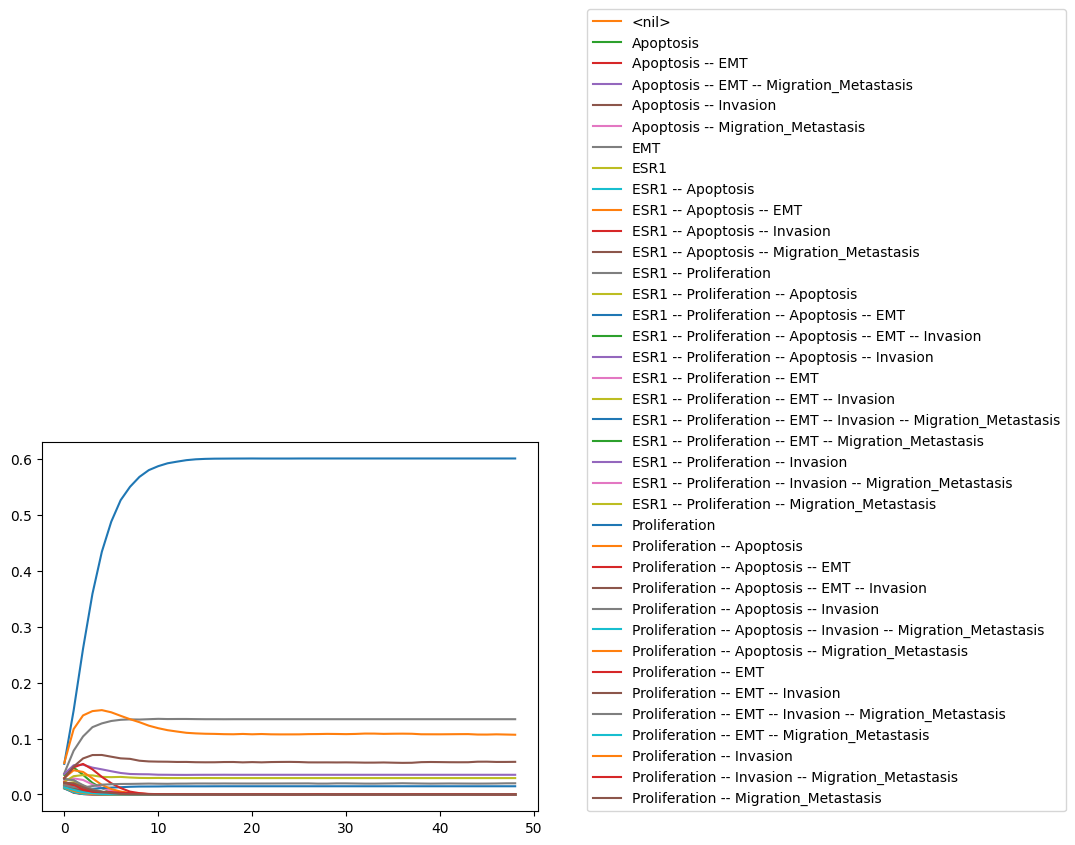

In [390]:
mutation = {}
outputs_di = {"Proliferation": 1, "Invasion": 1, "EMT": 1, "Migration-Metastasis": 1, 'Apoptosis': 0, "ESR1": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of PRKCZ (expect Invasion-, Growth- (Proliferation-))

Hypermethylation of PRKCZ blocks cell proliferation [(ref)](https://doi.org/10.3390/cancers14174151) Increased PRKC alpha expression in MCF7 cells leads to enhancer proliferation rates (transvection of PCKalpha) [(ref)](https//doig.org/10.1172/JCI117872) PKCzeta promotes breast cancer invasion [(ref)](https://doi.org/10.1038/srep12520)

Error on: Proliferation!=0,Invasion!=0,Migration_Metastasis!=0


{Proliferation=1}  {Invasion=1,Proliferation=1}  \
prob             0.7374                      0.230323   

      {Invasion=1,Migration_Metastasis=1,Proliferation=1}  correct  total  
prob                                           0.032277          1      2

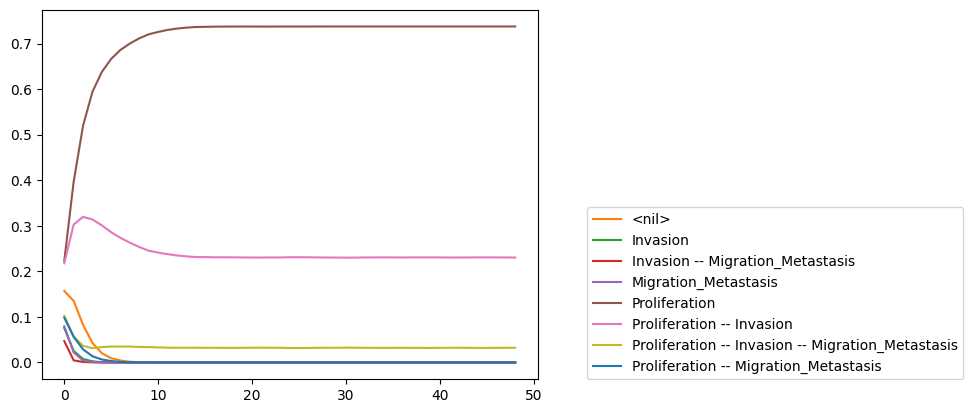

In [391]:
mutation, outputs_di = {"PRKCZ": 0}, {"Proliferation": 0, "Invasion": 0, "Migration-Metastasis": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of WNT5A (expect DAAM1+,RHOA+,Migration-Metastasis+,YWHAZ+)

Wnt5a activated Dvl2, Daam1 and RhoA, and promoted migration of breast cancer cells, which was, however, abolished by Secreted Frizzled-related protein 2 (sFRP2) pretreatment. Daam1 siRNA remarkably inhibited Wnt5a-induced RhoA activation, stress fiber formation and cell migration [(ref)](https://doi.org/10.1371/journal.pone.0037823) [(ref)](https://doi.org/10.3892/or.2017.6124)

expression levels of DAAM1 and YWHAZ were significantly upregulated in BrCa tissues compared with normal tissues and remarkably associated with poor prognosis. Besides, DAAM1 and YWHAZ were positively correlated with each other in BrCa tissues. YWHAZ regulates DAAM1 activation, and the YWHAZ–DAAM1 complex is directly targeted by the shared post-transcriptional regulator miR-613. [(ref)](https://doi.org/10.1038/s41420-021-00609-7)

{DAAM1=1}  {DAAM1=1,Migration_Metastasis=1}  {DAAM1=1,RHOA=1}  \
prob   0.388084                          0.012516            0.3899   

      {DAAM1=1,Migration_Metastasis=1,RHOA=1}  {DAAM1=1,YWHAZ=1}  \
prob                                   0.0138             0.0938   

      {DAAM1=1,Migration_Metastasis=1,YWHAZ=1}  {DAAM1=1,RHOA=1,YWHAZ=1}  \
prob                                    0.0038                  0.093825   

      {DAAM1=1,Migration_Metastasis=1,RHOA=1,YWHAZ=1}  correct  total  
prob                                         0.004275        2      3

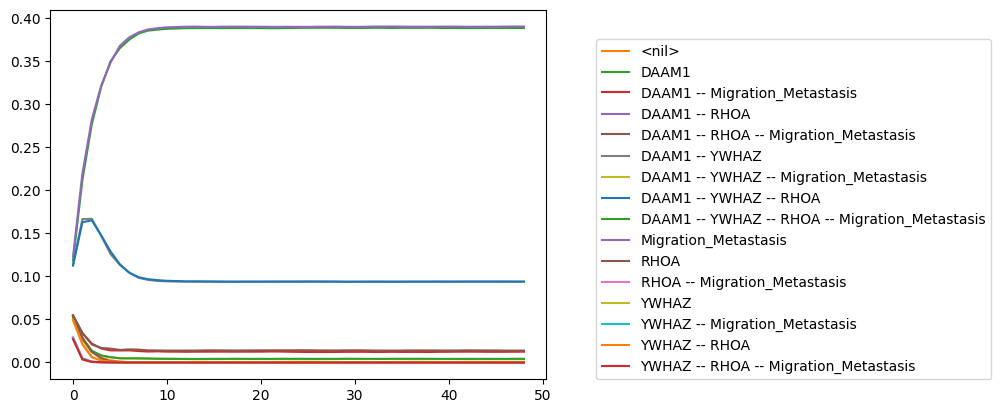

In [392]:
mutation, outputs_di = {"WNT5A": 1}, {"DAAM1": 1, "RHOA": 1, "Migration-Metastasis": 1, "YWHAZ": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of RXRA (expect ESR1+, Growth+ (Proliferation+), NFKB- (NFKBIA+))

Stimulation of RXR (and TTNPB) by ligands in MCF7 increases (strongly) aromatase activity, which activates the production of estrogen, which activates cancer cell growth [(ref)](https://doi.org/10.1016/s0303-7207(00)00273-2). Stimulation (agonist 6-OH-11-O-hydroxyphenanthrene) of RXR in MCF7 hampers the expression of NFKB and IL6, leading to downexpression of SNAI2, NOTCH3 and JAG1, and to the upregulation of ESR1 and KRT18 [(ref)](https://doi.org/10.1038/cdd.2011.207) => potential anticancer drug [(ref)](https://doi.org/10.1186/bcr913)

{ESR1=1,Proliferation=1}  {ESR1=1,NFKBIA=1,Proliferation=1}  \
prob                  0.045253                           0.197647   

      {NFKBIA=1,Proliferation=1}  {Proliferation=1}  correct  total  
prob                    0.594407           0.162693        3      4

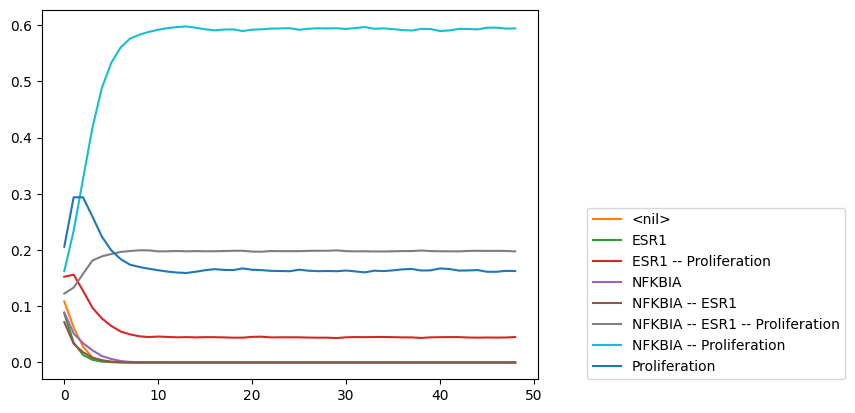

In [393]:
mutation, outputs_di = {"RXRA": 1}, {"Proliferation": 1, "ESR1": 1, "NFKBIA": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of SULT2A1 (expect Cancer- (Proliferation-))

SULT2A1 catalyses the sulfonation (addition of a sulfonic group) of 2-methoxyestradiol in MCF7 cells. Sulfonation is linked to the solubility of a product (makes it -in general- more soluble). [(ref)](https://doi.org/10.1093/carcin/21.11.1947) 2-methoxyestradiol is reported to have an anticancer effect, as it is an angiogenesis inhibitor [(ref)]( https://doi.org/10.1592/phco.23.2.165.32088) (prevents the formation of new blood vessels [(ref)](https://pubchem.ncbi.nlm.nih.gov/compound/2-Methoxyestradiol)), and interacts poorly with estradiol receptors [(ref)](https://doi.org/10.1210/en.2002-220632). Up-regulation of SULT2A1 might prevent MCF7 cell proliferation [(ref)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9611654/).

<nil>  {CytoC=1}  {Migration_Metastasis=1}  correct  total
prob  0.871681     0.1061                  0.022219        4      5

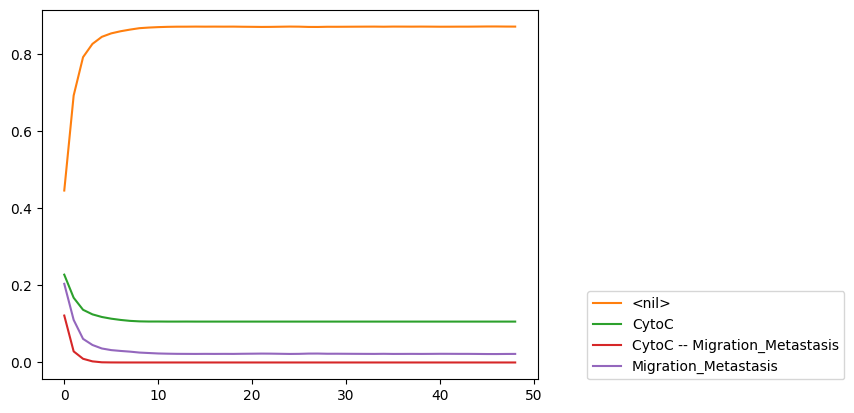

In [394]:
mutation, outputs_di = {"SULT2A1": 1}, {"Migration-Metastasis": 0, "CytoC": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of IGF1R (expect Apoptosis-)

It is highly overexpressed in most malignant tissues where it functions as an anti-apoptotic agent by enhancing cell survival. [(ref)](https://www.genecards.org/cgi-bin/carddisp.pl?gene=IGF1R&keywords=IGF1R)

{Proliferation=1}  correct  total
prob                1.0        5      6

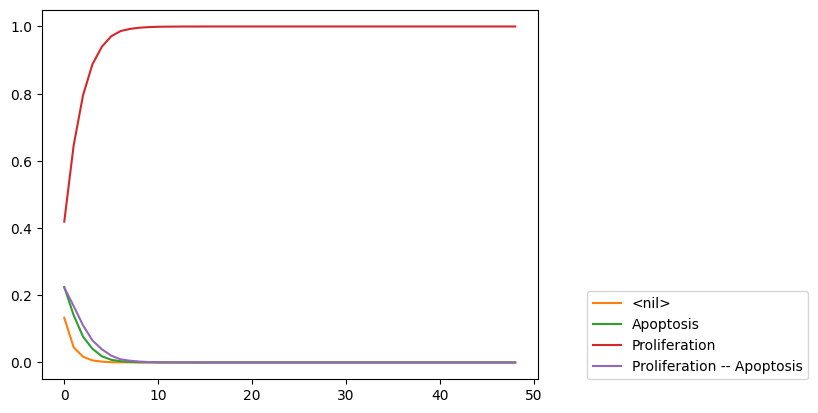

In [395]:
mutation, outputs_di = {"IGF1R": 1}, {"Proliferation": 1, "Apoptosis": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of RRM2 and NFKB (expect AKT-,Migration-Metastasis-,Proliferation-)

AKT-expressing breast cancer cells upregulate RRM2 expression, leading to increased DNA repair and protection from tamoxifen-induced apoptosis. breast cancer cells with elevated endogenous AKT or overexpression of activated AKT exhibited tamoxifen-stimulated cell proliferation and enhanced cell motility. [(ref)](https://doi.org/10.1158/1541-7786.MCR-13-0219)

RRM2 expression was significantly correlated with age, tumor size, grade, menopausal status, molecular typing, ER, PR, and Her-2 of patients with breast cancer(P<0.05) [(ref)](https://doi.org/10.1371/journal.pone.0265195)

Because didox also appears to be a potent inhibitor of NF-κB activation, combining didox with tamoxifen treatment cooperatively reverses ER-α alterations and inhibits NF-κB activation. Finally, inhibition of RRM2 by didox reversed tamoxifen-resistant in vivo tumor growth and decreased in vitro migratory and invasive properties, revealing a beneficial effect of combination therapy that includes RRM2 inhibition to delay or abrogate tamoxifen resistance. [(ref)](https://doi.org/10.1158/1535-7163.MCT-14-0689)

Error on: Proliferation!=0,Migration_Metastasis!=0,AKT1!=0,AKT2!=0,AKT3!=0


{AKT1=1,AKT3=1,Proliferation=1}  {AKT1=1,Proliferation=1}  \
prob                           0.0191                    0.0882   

      {AKT1=1,AKT2=1,AKT3=1,Proliferation=1}  \
prob                                  0.2539   

      {AKT1=1,AKT2=1,AKT3=1,Migration_Metastasis=1,Proliferation=1}  \
prob                                             0.0139               

      {AKT1=1,AKT2=1,Proliferation=1}  {AKT2=1,AKT3=1,Proliferation=1}  \
prob                           0.0748                           0.0565   

      {AKT2=1,Proliferation=1}  {AKT3=1,Proliferation=1}  {Proliferation=1}  \
prob                    0.2338                    0.0489             0.2109   

      correct  total  
prob        5      7

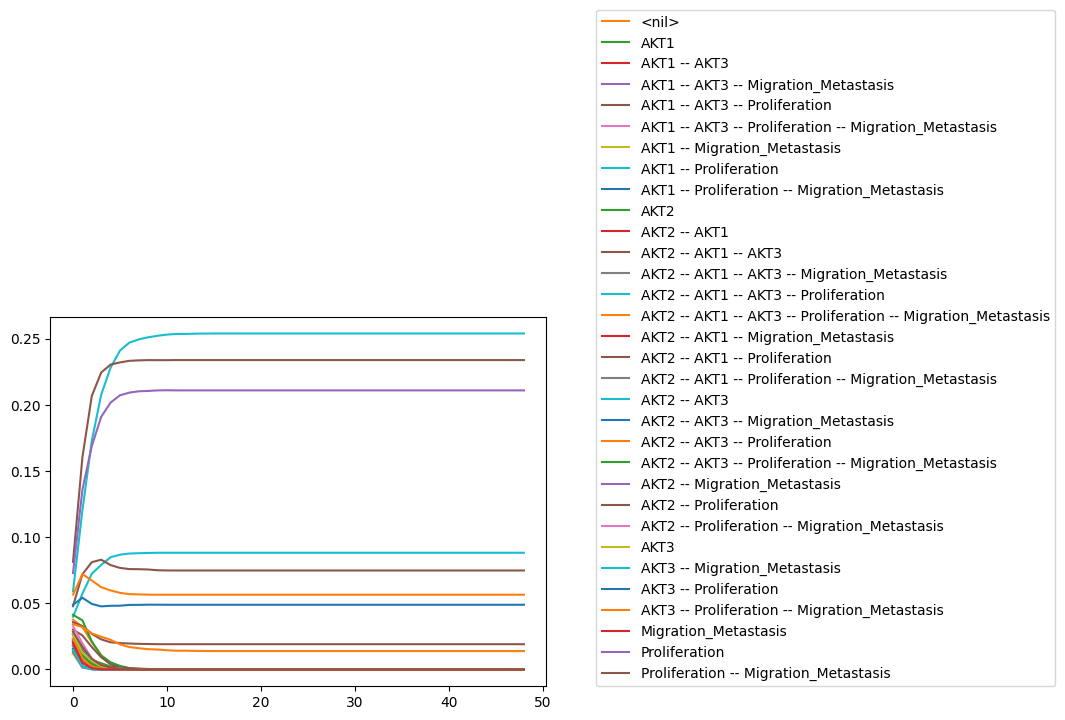

In [396]:
mutation, outputs_di = {"RRM2": 0, "NFKBIA": 1}, {"Proliferation": 0, "Migration-Metastasis": 0, "AKT1": 0, "AKT2": 0, "AKT3": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of MYC (expect Cancer+ (Invasion+, Proliferation+), NFKB+ (NFKBIA-))

Up-regulation of MYC in breast cancer cell lines (both ER-positive and negative), is a cell cycle regulator with cyclin D1 [(ref)](https://doi.org/10.1016/j.mce.2004.08.002) and NFBK [(ref)](https://doi.org/10.18632/oncotarget.8875). 

{NFKBIA=1,Proliferation=1}  {EMT=1,Invasion=1,NFKBIA=1,Proliferation=1}  \
prob                    0.317917                                     0.017513   

      {Invasion=1,NFKBIA=1,Proliferation=1}  {Proliferation=1}  \
prob                               0.104324           0.426883   

      {EMT=1,Invasion=1,Proliferation=1}  {Invasion=1,Proliferation=1}  \
prob                            0.098721                      0.034642   

      correct  total  
prob        6      8

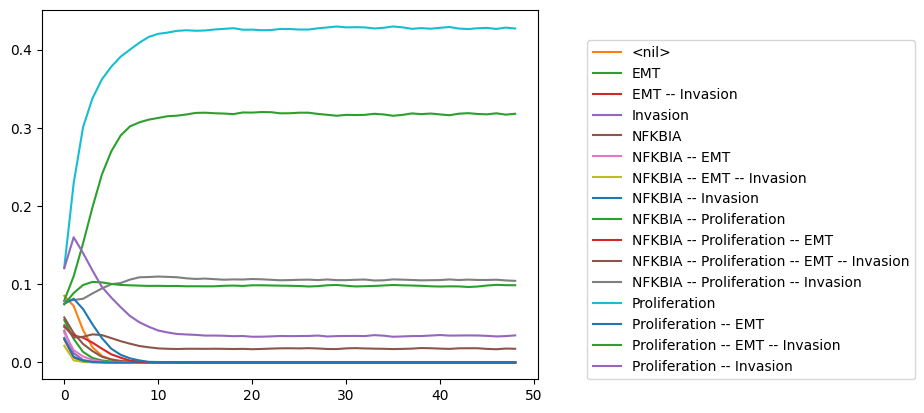

In [397]:
mutation, outputs_di = {"MYC": 0}, {"Invasion": 1, "Proliferation": 1, "EMT": 1, "NFKBIA": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of MYC (expect Invasion-,EMT-,NFKBIA+)

RNAi (KD) of MYC in breast cancer cell lines (80% inactivation) reduced tumor growth in mice [(ref)](https://doi.org/10.1186/bcr975) Antisense oligonucleotide treatment reproduces this, with a stronger effect when combined with the repression of p21/CDKN1A [(ref)](https://aacrjournals.org/cancerres/article/62/11/3126/508881/Mechanisms-of-Growth-Arrest-by-c-myc-Antisense) 

<nil>  {EMT=1,Invasion=1}  {Invasion=1}  {NFKBIA=1}  \
prob  0.426883            0.098721      0.034642    0.317917   

      {EMT=1,Invasion=1,NFKBIA=1}  {Invasion=1,NFKBIA=1}  correct  total  
prob                     0.017513               0.104324        7      9

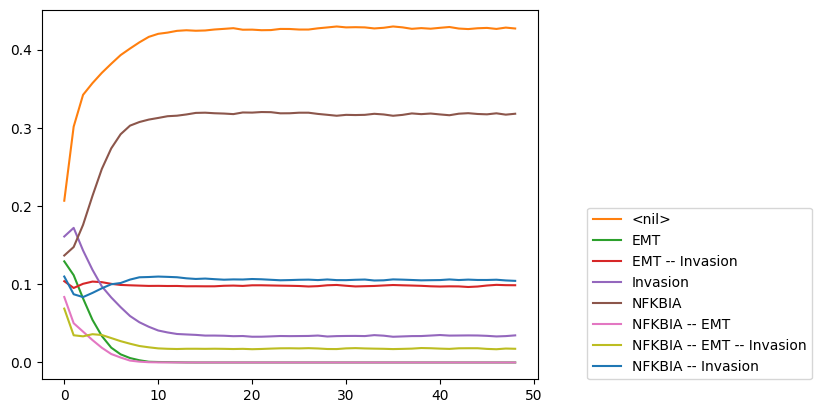

In [398]:
mutation, outputs_di = {"MYC": 0}, {"Invasion": 0, "EMT": 0, "NFKBIA": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of HDAC3 (expect Apoptosis-,TP53-,ESR1+)

Oleuropein (molecule with supposed anticancer properties) might act by downregulating HDAC2 and HDAC3 (qPCR) [(ref)](https://doi.org/10.1002/jcb.28193), inducing cell apoptosis. Role of inhibition of HDAC family genes in apoptosis seems confirmed by [(ref)](https://doi.org/10.3389/fphar.2016.00081), [(ref)](https://doi.org/10.1371/journal.pone.0062610) (treatment by SAHA, inhibitor), [(ref)](https://doi.org/10.3892/ijo.2012.1534) (treatment by Sirtinol), [(ref)](https://doi.org/10.1007/s10637-011-9752-z) (treatment by MHY218) Downregulates p53 [(ref)](https://www.genecards.org/cgi-bin/carddisp.pl?gene=HDAC3&keywords=HDAC3). Inhibition of HDAC downregulates ERalpha, and global expression of HDAC is higher in ER-positive cell lines compared to ER-negative ones [(ref)](https://doi.org/10.1016/j.bbrc.2013.02.007)

<nil>  {ESR1=1}  {TP53=1}  {ESR1=1,TP53=1}  correct  total
prob  0.7121    0.1725    0.0766           0.0388        8     10

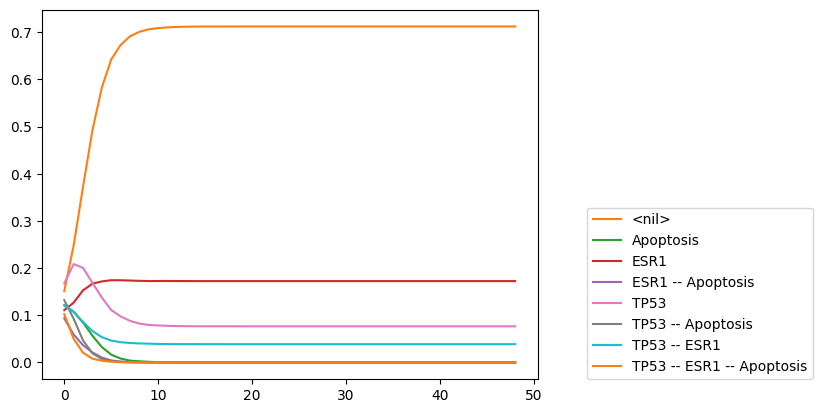

In [399]:
mutation, outputs_di = {"HDAC3": 1}, {"TP53": 0, "ESR1": 1, "Apoptosis": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of RHOA (expect Apoptosis-, cell invasion+, MMP2+, NFKBIA-)

RHOA-KD (siRNA) inhibits Lysophosphatidic acid (LPA)-induced cell invasion [(ref)](https://doi.org/10.1007/s10238-015-0336-7) confirmed by [(ref)](https://doi.org/10.1158/0008-5472.CAN-07-5424) NRF2 overexpression stimulates cell invasion through activation of RHOA [(ref)](https://doi.org/10.18632/oncotarget.12435) Activation of RHOA activates the expression of NFKB [(ref)](https://doi.org/10.1016/j.bbrc.2015.03.166) RhoA and ROCK activities and expression levels of RhoA, ROCK1, ROCK2, MMP2 and MMP9 were down-regulated by RhoA siRNA transfection. [(ref)](https://doi.org/10.1007/s10238-015-0336-7)

{MMP2=1}  {Invasion=1,MMP2=1}  {MMP2=1,NFKBIA=1}  \
prob   0.45813             0.147274            0.28487   

      {Invasion=1,MMP2=1,NFKBIA=1}  correct  total  
prob                      0.109726        9     11

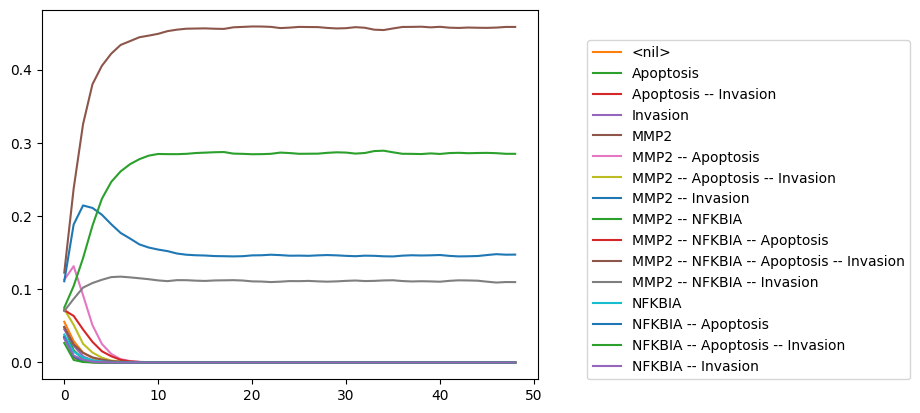

In [400]:
mutation, outputs_di = {"RHOA": 1}, {"Invasion": 1, "Apoptosis": 0, "MMP2": 1, "NFKBIA": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of CXCL8 (expect Proliferation+, Migration-Metastasis+,NFKBIA-)

CXCL8 secretion, and partly the secretion of VEGF, were up-regulated in monocytic cells, but not in breast tumor cells, by the CC chemokines CCL5 and CCL2. EGF potently up-regulated CXCL8 secretion by breast tumor cells, and its effect was promoted by a consecutive treatment of the cells by estrogen and progesterone. [(ref)](https://doi.org/10.1016/j.canlet.2004.05.024) MCF7 tumor cells were more potentially promoted by hADSCs (human adipose-derived mesenchymal stem cells) in the aspects of angiogenesis and proliferation, by upregulation of CXCL1 and CXCL8 (in MCF7), and increased migration through CXCR1 and CXCR2 (their receptors) [(ref)](https://doi.org/10.1002/stem.2643)

The role of CXCL8 in the development in MCF7 is confirmed by the activation of lnc-SLC4A1-1 (through NFKB, AP1) [(ref)](https://doi.org/10.1080/21691401.2019.1664559) (through EGF) [(ref)](https://doi.org/10.1593/neo.101340) CXCL8 overexpressed in ER-negative cell lines, but high levels of CXCL8, CXCL1, and CXCL3 accounted for a shorter relapse-free survival of ERalpha-positive patients treated with tamoxifen [(ref)](https://doi.org/10.1677/erc.1.01301)

{NFKBIA=1,Proliferation=1}  \
prob                    0.440257   

      {Migration_Metastasis=1,NFKBIA=1,Proliferation=1}  {Proliferation=1}  \
prob                                           0.008219           0.526986   

      {Migration_Metastasis=1,Proliferation=1}  correct  total  
prob                                  0.024538       10     12

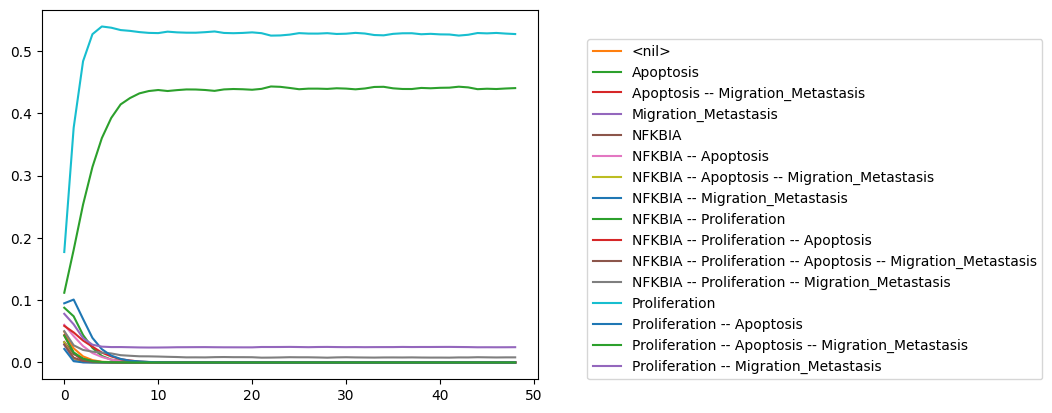

In [401]:
mutation, outputs_di = {"CXCL8": 1}, {"Proliferation": 1, "Apoptosis": 0, "Migration-Metastasis": 1, "NFKBIA": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of CDC42 (expect Proliferation+, Migration-Metastasis+,NFKBIA-,VEGFC+)

(Over)expressed by MCF7 cells, although often not mutated. Activates breast cancer cell proliferation through MAPK pathway [(ref)](https://doi.org/10.3390/cells8020146), and binding to scaffold protein IQGAP1 [(ref)](https://doi.org/10.1038/s41598-022-21342-w) Increases cell migration in conjunction with nicotine treatment (overexpression by vector) [(ref)](https://doi.org/10.1158/0008-5472.CAN-08-0131) Inhibits EGF degradation [(ref)](https://doi.org/10.1158/0008-5472.CAN-05-1547)

{NFKBIA=1,Proliferation=1}  \
prob                    0.330832   

      {Migration_Metastasis=1,NFKBIA=1,Proliferation=1}  \
prob                                           0.008035   

      {NFKBIA=1,Proliferation=1,VEGFC=1}  \
prob                            0.102757   

      {Migration_Metastasis=1,NFKBIA=1,Proliferation=1,VEGFC=1}  \
prob                                           0.005218           

      {Proliferation=1}  {Migration_Metastasis=1,Proliferation=1}  \
prob           0.412521                                  0.028012   

      {Proliferation=1,VEGFC=1}  \
prob                   0.105443   

      {Migration_Metastasis=1,Proliferation=1,VEGFC=1}  correct  total  
prob                                          0.007182       11     13

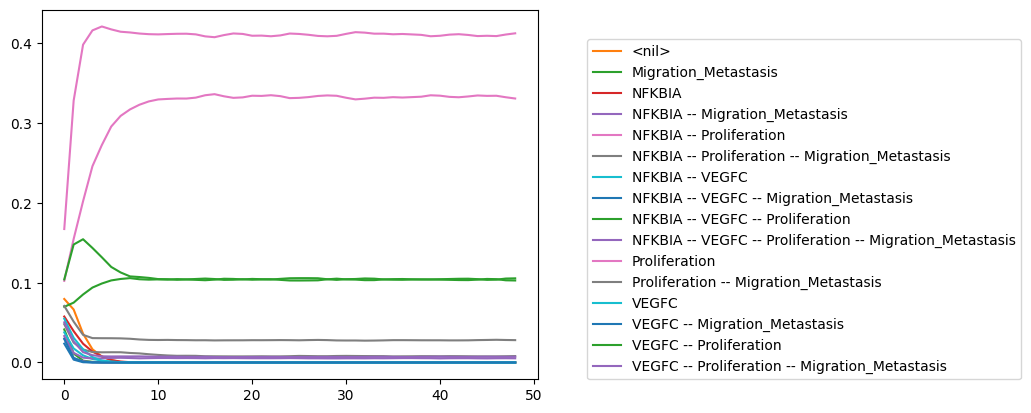

In [402]:
mutation, outputs_di = {"CDC42": 1}, {"Proliferation": 1, "Migration-Metastasis": 1, "NFKBIA": 0, "VEGFC": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of NANOG (expect PDGFRA-, Cancer- (Invasion-, Proliferation-))

Overexpressed in breast cancer cell lines (RT-PCR) [(ref)](https://doi.org/10.3892/ol.2012.916), deregulates PDGFRalpha in mice (associated with tumorigenesis and metastasis) [(ref)](https://doi.org/10.1038/onc.2013.209) RNAi of Nanog reduces proliferation in vitro [(ref)](https://doi.org/10.1016/j.canlet.2012.02.021), even in tamoxifen-resistant cell lines [(ref)](https://doi.org/10.2147/OTT.S67835).

Treatment with cyclohexylmethyl Flavonoids (ugonin J) significantly reduced the tumorigenicity of MCF-7 cells and efficiently suppressed formation of mammospheres. This suppression was possibly due to p53 activation and NANOG reduction as either addition of p53 inhibitor or overexpression of NANOG can counteract the suppressive effect of ugonin J. [(ref)](http://dx.doi.org/10.1155/2013/17026)

Error on: Invasion!=0,Proliferation!=0,EMT!=0,PDGFRA!=0


{PDGFRA=1,Proliferation=1}  {EMT=1,Invasion=1,PDGFRA=1,Proliferation=1}  \
prob                      0.6873                                     0.121975   

      {Invasion=1,PDGFRA=1,Proliferation=1}  correct  total  
prob                               0.190725       11     14

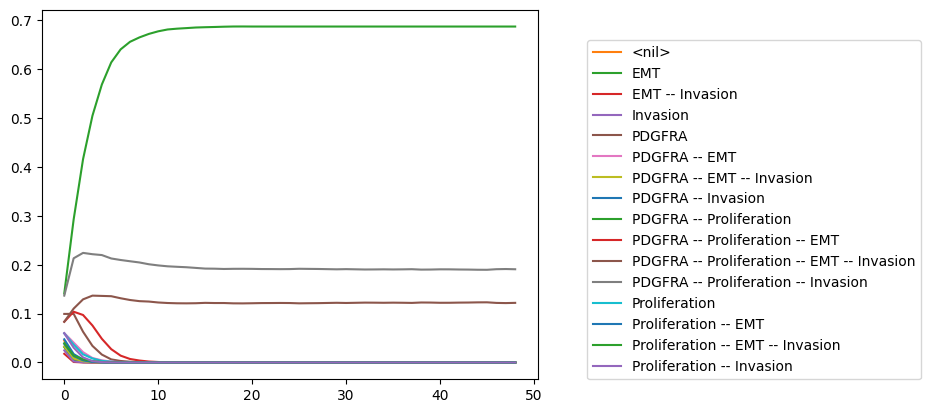

In [403]:
mutation, outputs_di = {"NANOG": 0, "TP53": 1}, {"Invasion": 0, "Proliferation": 0, 'EMT':0, "PDGFRA": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of HIF1A in hypoxia (expect Apoptosis-, Proliferation+, Autophagia-)

Pro-apoptotic gene [(ref)](https://doi.org/10.1038/s41598-018-37796-w) Hypoxia-induced degradation of CAV1. Hypoxia upregulates (well-established autophagy/mitophagy markers) namely LC3, ATG16L, BNIP3, BNIP3L, HIF1A and NFKB [(ref)](https://doi.org/10.4161/cc.9.17.12928) Pharmacological activation of HIF1A drives CAV1 degradation, while pharmacological inactivation of HIF1A prevents the downregulation of CAV1. Pharmacological inactivation of NFKB prevents CAV1 degradation. Acute knock-down (siRNA) of CAV1 in stromal fibroblasts is sufficient to induce autophagy

Transcription of CITED2, a transcriptional cofactor that functions in a negative feedback loop to control HIF1 activity, is induced by FOXO3a during hypoxia. FOXO3a inhibits HIF1-induced apoptosis by stimulating the transcription of CITED2, which results in reduced expression of the proapoptotic HIF1 target genes NIX and RTP801. [(ref)](https://doi.org/10.1016/j.molcel.2007.10.035)

{Autophagia=1,Proliferation=1}  {Proliferation=1}  correct  total
prob                        0.345371           0.654629       12     15

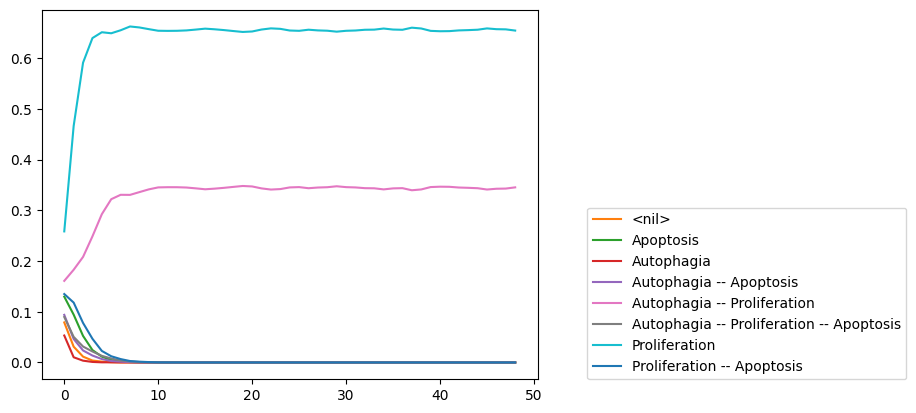

In [404]:
mutation, outputs_di = {"HIF1A": 0, "Hypoxia": 1}, {"Proliferation": 1, "Apoptosis": 0, "Autophagia": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of PIK3CA, overexpression of MYC and TP53 loss (expect Invasion+, EMT+, Proliferation+)

A switch from catabolic to anabolic metabolism, a major hallmark of cancer, enables rapid cell duplication, and is driven by multiple oncogenic alterations, including PIK3CA mutation, MYC amplification, and TP53 loss [(ref)](https://doi.org/10.1016/j.trecan.2017.09.002)

{Proliferation=1}  {Invasion=1,Proliferation=1}  \
prob              0.729                      0.237655   

      {Invasion=1,Migration_Metastasis=1,Proliferation=1}  correct  total  
prob                                           0.033345         13     16

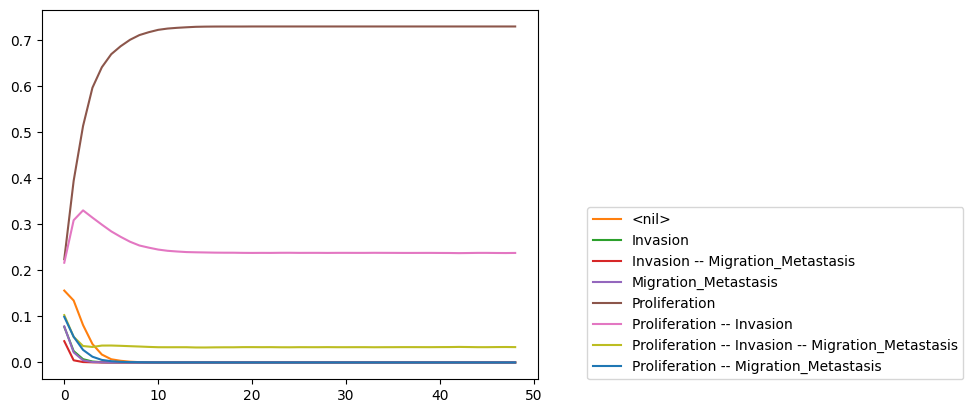

In [405]:
mutation, outputs_di = {"PIK3CA": 0, "MYC": 1, "TP53": 0}, {"Proliferation": 1, "Invasion": 1, "Migration-Metastasis": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of RB1 (expect TP53-, CDKN2A-)

Reported interaction with TP53, TP21/CDKN1A, TP16/CDKN2A and KI-67/MKI67 [(ref)](https://doi.org/10.1371/journal.pone.0011404)

<nil>  {CDKN2A=1}  {TP53=1}  {CDKN2A=1,TP53=1}  correct  total
prob  0.7994      0.0855    0.0907             0.0244       14     17

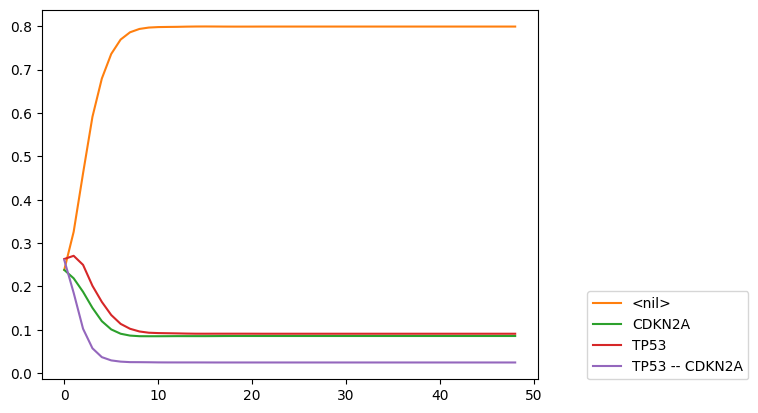

In [406]:
mutation, outputs_di = {"RB1": 0}, {"TP53": 0, "CDKN2A": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of WEE1 (expect Apoptosis+, Proliferation-,CDK1-,TP53+,VEGFC-,BCL2-)

Inhibits CDC2/CDK1/CCNB1, G2/M checkpoint regulator protein. Knockdown with shRNA decreases MCF7 proliferation, up-regulates P53, down-regulates VEGF and BCL2. [(ref)](http://dx.doi.org/10.7314/APJCP.2013.14.11.6605) Inhibition by small molecule MK-1775 sensitizes breast cancer cells to paclitaxel and promotes cancer cells to bypass the cell-cycle checkpoints and prematurely enter mitosis. [(ref)](https://doi.org/10.18632/oncotarget.17848) Forced activation of Cdk1 via wee1 inhibition did not cause cytotoxicity. Instead, it accelerated mitotic entry and caused radio sensitization in p53-defective cancer cells, but not in p53-proficient cancer cells. [(ref)](https://doi.org/10.1038/onc.2012.296)

Error on: Proliferation!=0,Apoptosis!=1,CDK1!=0,VEGFC!=0,BCL2!=0


{BCL2=1,Proliferation=1}  {BCL2=1,CDK1=1,Proliferation=1}  \
prob                    0.1063                           0.0004   

      {CDK1=1,Proliferation=1}  {BCL2=1,CDK1=1,Proliferation=1,TP53=1}  \
prob                     0.004                                   0.004   

      {CDK1=1,Proliferation=1,TP53=1}  \
prob                           0.0132   

      {BCL2=1,CDK1=1,Proliferation=1,TP53=1,VEGFC=1}  \
prob                                          0.0014   

      {CDK1=1,Proliferation=1,TP53=1,VEGFC=1}  \
prob                                    0.005   

      {CDK1=1,Proliferation=1,VEGFC=1}  {Proliferation=1}  \
prob                            0.0012             0.6451   

      {BCL2=1,Proliferation=1,TP53=1}  {Proliferation=1,TP53=1}  \
prob                            0.004                    0.0096   

      {BCL2=1,Proliferation=1,TP53=1,VEGFC=1}  \
prob                                   0.0009   

      {Proliferation=1,TP53=1,VEGFC=1}  {BCL2=1,Proliferation=1,VEGFC=1}  \
prob                            0.0026                            0.0307   

      {Proliferation=1,VEGFC=1}  correct  total  
prob                     0.1716       14     18

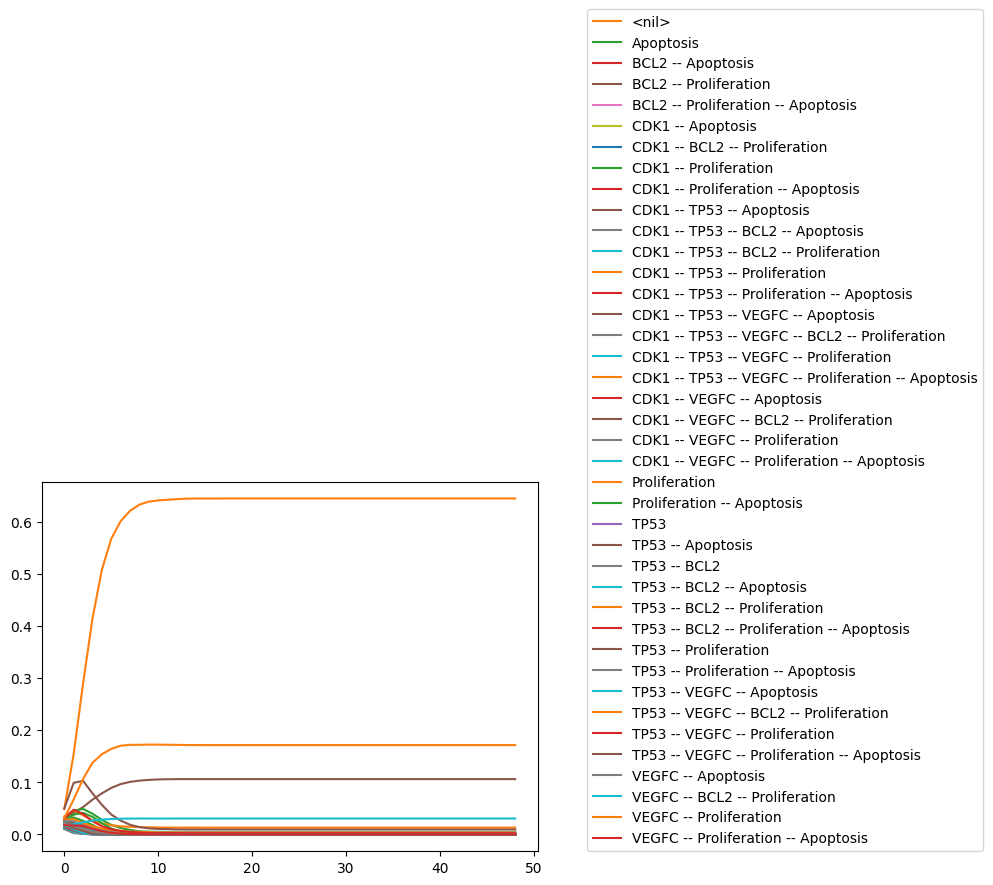

In [407]:
mutation, outputs_di = {"WEE1": 0}, {"Proliferation": 0, "Apoptosis": 1, "CDK1": 0, 'TP53': 1, "VEGFC": 0, "BCL2": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Hypoxia (expect EPAS1+)

Chronic hypoxia (48 h, 1% O2) continuously enhanced HIF-2α expression and induced the resistance of breast cancer cells to Paclitaxel (PTX) [(ref)](https://doi.org/10.1186/s13046-018-0925-x) 

{EPAS1=1}  correct  total
prob        1.0       15     19

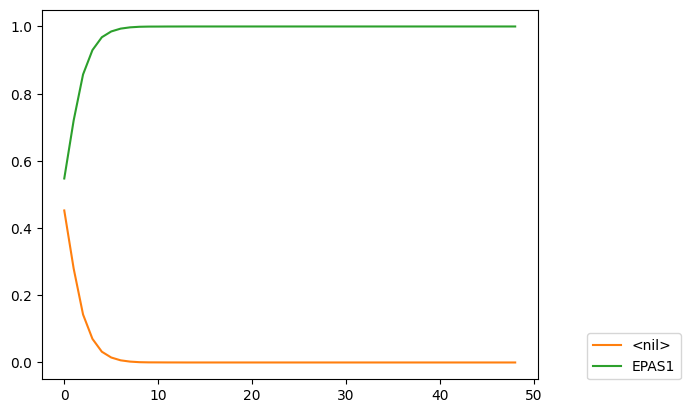

In [408]:
mutation, outputs_di = {"Hypoxia": 1}, {"EPAS1": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of EPAS1 (expect WNT/NOTCH pathways+)

Overexpression of EPAS1 activates the Wnt/NOTCH pathways [(ref)](https://doi.org/10.1186/s13046-018-0925-x)

Error on: FZD1!=1,WNT10B!=1


{CSNK1D=1,DAAM1=1}  {CHUK=1,CSNK1D=1,DAAM1=1}  \
prob              0.0162                     0.0072   

      {CHUK=1,CSNK1D=1,DAAM1=1,GSK3A=1,WNT1=1}  \
prob                                    0.0005   

      {CHUK=1,CSNK1D=1,DAAM1=1,GSK3A=1,LRP6=1,WNT1=1,WNT5A=1}  \
prob                                             0.0002         

      {CHUK=1,CSNK1D=1,DAAM1=1,GSK3A=1,WNT1=1,YWHAZ=1}  \
prob                                            0.0003   

      {CHUK=1,CSNK1D=1,DAAM1=1,WNT1=1}  \
prob                            0.0007   

      {CHUK=1,CSNK1D=1,DAAM1=1,LRP6=1,WNT5A=1}  \
prob                                    0.0007   

      {CHUK=1,CSNK1D=1,DAAM1=1,LRP6=1,WNT1=1,WNT5A=1}  \
prob                                           0.0003   

      {CHUK=1,CSNK1D=1,DAAM1=1,YWHAZ=1}  \
prob                             0.0014   

      {CHUK=1,CSNK1D=1,DAAM1=1,WNT1=1,YWHAZ=1}  \
prob                                    0.0005   

      {CHUK=1,CSNK1D=1,DAAM1=1,LRP6=1,WNT5A=1,YWHAZ=1}  \
prob                                            0.0003   

      {CSNK1D=1,DAAM1=1,GSK3A=1,WNT1=1}  \
prob                             0.0009   

      {CSNK1D=1,DAAM1=1,GSK3A=1,LRP6=1,WNT1=1,WNT5A=1}  \
prob                                            0.0002   

      {CSNK1D=1,DAAM1=1,GSK3A=1,WNT1=1,YWHAZ=1}  \
prob                                     0.0003   

      {CSNK1D=1,DAAM1=1,GSK3A=1,LRP6=1,WNT1=1,WNT5A=1,YWHAZ=1}  \
prob                                             0.0001          

      {CSNK1D=1,DAAM1=1,WNT1=1}  {CSNK1D=1,DAAM1=1,LRP6=1,WNT5A=1}  \
prob                     0.0025                             0.0017   

      {CSNK1D=1,DAAM1=1,LRP6=1,WNT1=1,WNT5A=1}  {CSNK1D=1,DAAM1=1,YWHAZ=1}  \
prob                                    0.0004                      0.0052   

      {CSNK1D=1,DAAM1=1,WNT1=1,YWHAZ=1}  \
prob                             0.0009   

      {CSNK1D=1,DAAM1=1,LRP6=1,WNT5A=1,YWHAZ=1}  \
prob                                     0.0004   

      {CSNK1D=1,DAAM1=1,LRP6=1,WNT1=1,WNT5A=1,YWHAZ=1}  \
prob                                            0.0002   

      {CSNK1D=1,DAAM1=1,GATA3=1}  {CHUK=1,CSNK1D=1,DAAM1=1,GATA3=1}  \
prob                      0.0133                             0.0056   

      {CHUK=1,CSNK1D=1,DAAM1=1,GATA3=1,GSK3A=1,WNT1=1}  \
prob                                            0.0003   

      {CHUK=1,CSNK1D=1,DAAM1=1,GATA3=1,GSK3A=1,WNT1=1,YWHAZ=1}  \
prob                                             0.0001          

      {CHUK=1,CSNK1D=1,DAAM1=1,GATA3=1,WNT1=1}  \
prob                                    0.0003   

      {CHUK=1,CSNK1D=1,DAAM1=1,GATA3=1,LRP6=1,WNT5A=1}  \
prob                                            0.0011   

      {CHUK=1,CSNK1D=1,DAAM1=1,GATA3=1,YWHAZ=1}  \
prob                                     0.0012   

      {CHUK=1,CSNK1D=1,DAAM1=1,GATA3=1,WNT1=1,YWHAZ=1}  \
prob                                            0.0001   

      {CHUK=1,CSNK1D=1,DAAM1=1,GATA3=1,LRP6=1,WNT5A=1,YWHAZ=1}  \
prob                                             0.0004          

      {CHUK=1,CSNK1D=1,DAAM1=1,GATA3=1,LRP6=1,WNT1=1,WNT5A=1,YWHAZ=1}  \
prob                                             0.0001                 

      {CSNK1D=1,DAAM1=1,GATA3=1,GSK3A=1,WNT1=1}  \
prob                                     0.0007   

      {CSNK1D=1,DAAM1=1,GATA3=1,GSK3A=1,WNT1=1,YWHAZ=1}  \
prob                                             0.0004   

      {CSNK1D=1,DAAM1=1,GATA3=1,WNT1=1}  \
prob                             0.0016   

      {CSNK1D=1,DAAM1=1,GATA3=1,LRP6=1,WNT5A=1}  \
prob                                     0.0017   

      {CSNK1D=1,DAAM1=1,GATA3=1,LRP6=1,WNT1=1,WNT5A=1}  \
prob                                            0.0004   

      {CSNK1D=1,DAAM1=1,GATA3=1,YWHAZ=1}  \
prob                               0.003   

      {CSNK1D=1,DAAM1=1,GATA3=1,WNT1=1,YWHAZ=1}  \
prob                                     0.0009   

      {CSNK1D=1,DAAM1=1,GATA3=1,LRP6=1,WNT5A=1,YWHAZ=1}  \
prob

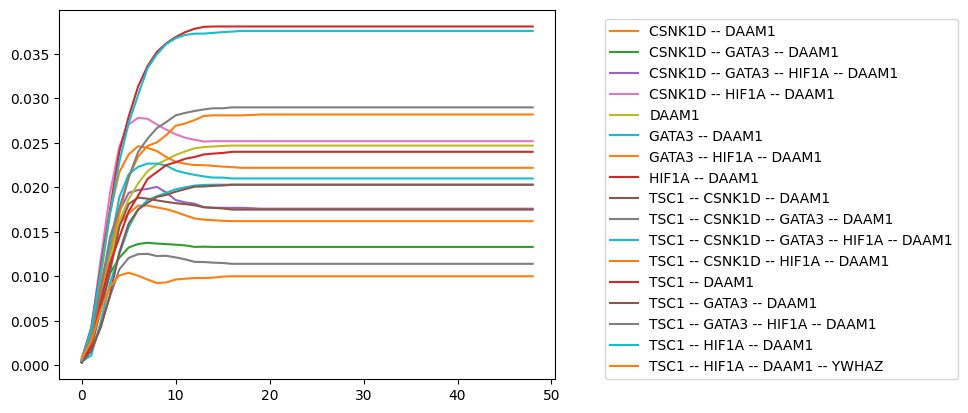

In [409]:
mutation, outputs_di = {"EPAS1": 1}, {g: 1 for g in Notch+WNT}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of HIC1 (expect EFNA1-)

We now show that HIC1 is a direct transcriptional repressor of the gene encoding the Eph receptor ligand Ephrin A1 (Efna1) [(ref)](https://aacrjournals.org/cancerres/article/69/9_Supplement/3831/553090/Abstract-3831-Roles-for-Hic1-in-tumor-suppression) (restoration of HIC1 in lines where it is epigenetically silenced, observe direct effect on EFNA1)

<nil>  {EFNA1=1}  correct  total
prob  0.7521     0.2479       16     21

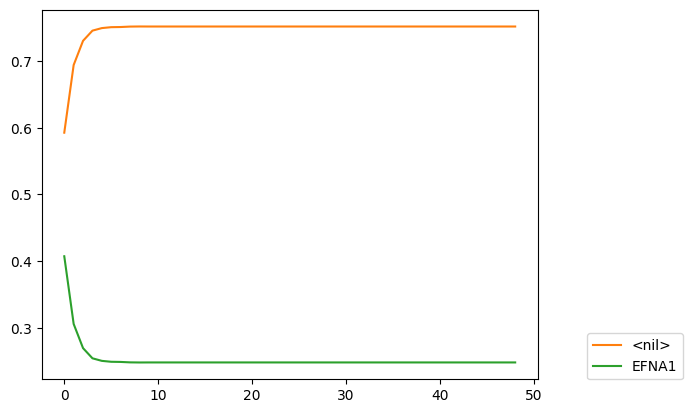

In [410]:
mutation, outputs_di = {"HIC1": 1}, {"EFNA1": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of MET (expect SRC+, AKT+,Apoptosis-,Invasion+,HGF+)

Substantial activation of the HGF/c-Met signaling pathway is involved in the progression of several types of cancers and associated with increased tumor invasion and metastatic potential [(ref)](https://doi.org/10.1021/jf2021489)

Upregulated c-Met expression in MCF7 facilitates their stimulation by HGF/SF-secreting stromal fibroblasts, leading to the activation of Src, Akt and ERK1/2 and a profound enhancement of their aggressive phenotype in vitro  [(ref)](https://doi.org/10.1677/erc.1.01270)

<nil>  {AKT1=1}  {AKT1=1,AKT3=1}  {AKT1=1,AKT3=1,Invasion=1}  \
prob  0.1362    0.0501           0.0115                      0.0032   

      {AKT1=1,HGF=1}  {AKT1=1,AKT3=1,HGF=1}  {AKT1=1,AKT3=1,HGF=1,Invasion=1}  \
prob          0.0032                 0.0003                            0.0008   

      {AKT1=1,HGF=1,Invasion=1}  {AKT1=1,Invasion=1}  {AKT1=1,SRC=1}  \
prob                     0.0023               0.0091          0.0071   

      {AKT1=1,AKT3=1,SRC=1}  {AKT1=1,AKT3=1,Invasion=1,SRC=1}  \
prob                 0.0011                            0.0023   

      {AKT1=1,HGF=1,SRC=1}  {AKT1=1,AKT3=1,HGF=1,SRC=1}  \
prob                0.0023                       0.0005   

      {AKT1=1,AKT3=1,HGF=1,Invasion=1,SRC=1}  {AKT1=1,HGF=1,Invasion=1,SRC=1}  \
prob                                  0.0012                           0.0073   

      {AKT1=1,Invasion=1,SRC=1}  {AKT2=1}  {AKT1=1,AKT2=1}  \
prob                     0.0067    0.1363           0.0381   

      {AKT1=1,AKT2=1,AKT3=1}  {AKT1=1,AKT2=1,AKT3=1,Invasion=1}  \
prob                  0.1307                             0.0239   

      {AKT1=1,AKT2=1,HGF=1}  {AKT1=1,AKT2=1,AKT3=1,HGF=1}  \
prob                 0.0046                        0.0131   

      {AKT1=1,AKT2=1,AKT3=1,HGF=1,Invasion=1}  \
prob                                   0.0161   

      {AKT1=1,AKT2=1,HGF=1,Invasion=1}  {AKT1=1,AKT2=1,Invasion=1}  \
prob                            0.0052                      0.0061   

      {AKT1=1,AKT2=1,SRC=1}  {AKT1=1,AKT2=1,AKT3=1,SRC=1}  \
prob                 0.0077                        0.0251   

      {AKT1=1,AKT2=1,AKT3=1,Invasion=1,SRC=1}  {AKT1=1,AKT2=1,HGF=1,SRC=1}  \
prob                                    0.025                       0.0037   

      {AKT1=1,AKT2=1,AKT3=1,HGF=1,SRC=1}  \
prob                              0.0117   

      {AKT1=1,AKT2=1,AKT3=1,HGF=1,Invasion=1,SRC=1}  \
prob                                         0.0272   

      {AKT1=1,AKT2=1,HGF=1,Invasion=1,SRC=1}  \
prob                                  0.0076   

      {AKT1=1,AKT2=1,Invasion=1,SRC=1}  {AKT2=1,AKT3=1}  \
prob                            0.0067            0.029   

      {AKT2=1,AKT3=1,Invasion=1}  {AKT2=1,HGF=1}  {AKT2=1,AKT3=1,HGF=1}  \
prob                      0.0057          0.0062                 0.0009   

      {AKT2=1,AKT3=1,HGF=1,Invasion=1}  {AKT2=1,HGF=1,Invasion=1}  \
prob                            0.0004                     0.0031   

      {AKT2=1,Invasion=1}  {AKT2=1,SRC=1}  {AKT2=1,AKT3=1,SRC=1}  \
prob               0.0181          0.0302                 0.0072   

      {AKT2=1,AKT3=1,Invasion=1,SRC=1}  {AKT2=1,HGF=1,SRC=1}  \
prob                            0.0046                0.0122   

      {AKT2=1,AKT3=1,HGF=1,SRC=1}  {AKT2=1,AKT3=1,HGF=1,Invasion=1,SRC=1}  \
prob                       0.0022                                  0.0025   

      {AKT2=1,HGF=1,Invasion=1,SRC=1}  {AKT2=1,Invasion=1,SRC=1}  {AKT3=1}  \
prob                           0.0089                     0.0159    0.0302   

      {AKT3=1,Invasion=1}  {HGF=1}  {AKT3=1,HGF=1}  {AKT3=1,HGF=1,Invasion=1}  \
prob               0.0059   0.0057          0.0008                     0.0008   

      {HGF=1,Invasion=1}  {Invasion=1}  {SRC=1}  {AKT3=1,SRC=1}  \
prob              0.0027        0.0213   0.0145          0.0031   

      {AKT3=1,Invasion=1,SRC=1}  {HGF=1,SRC=1}  {AKT3=1,HGF=1,SRC=1}  \
prob                     0.0041          0.007                0.0024   

      {AKT3=1,HGF=1,Invasion=1,SRC=1}  {HGF=1,Invasion=1,SRC=1}  \
prob                           0.0014                    0.0074   

      {Invasion=1,SRC=1}  correct  total  
prob              0.0116       17     22

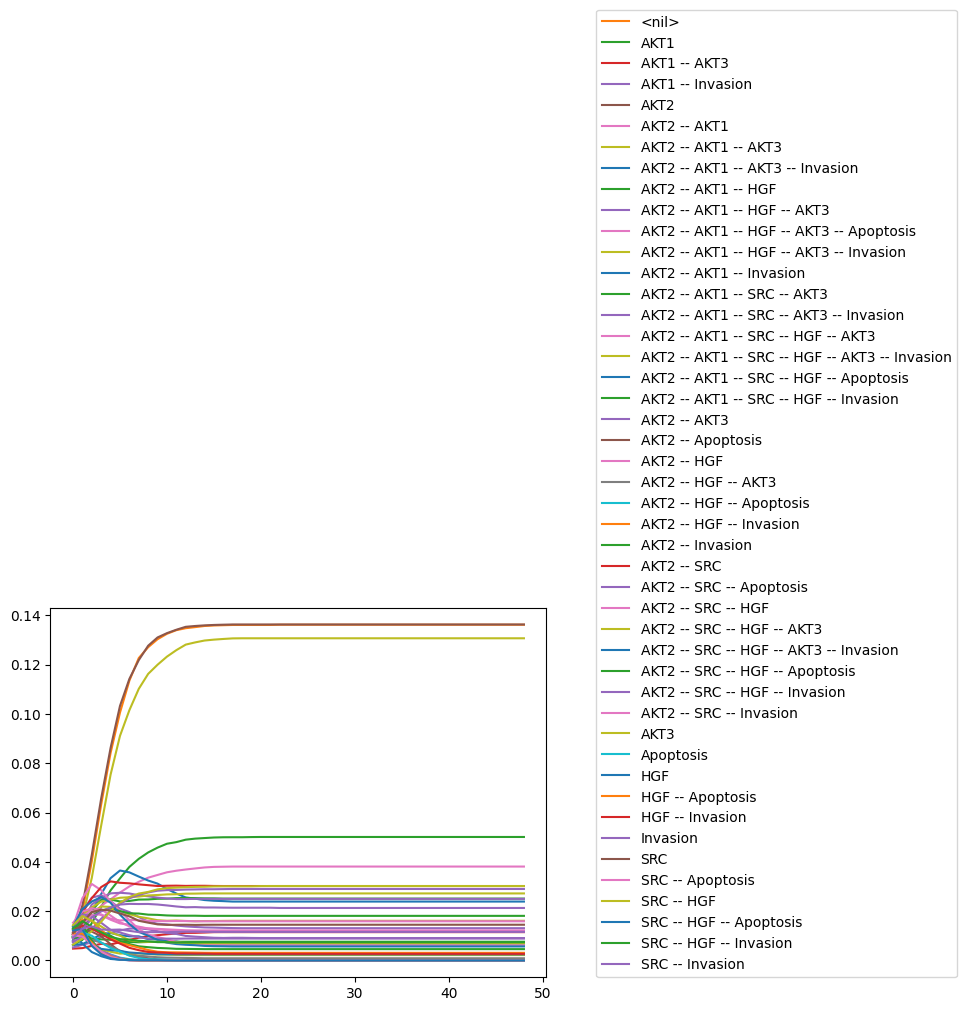

In [411]:
mutation, outputs_di = {"MET": 1}, {g: int(g!="Apoptosis") for g in ["SRC", "AKT1", "HGF", "AKT2", "AKT3", "Apoptosis", "Invasion"]}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of JAK1 (expect Proliferation+,EMT+,Migration-Metastasis+)

Aberrant activation of these non-receptor tyrosine kinases (JAK1, JAK2, JAK3 and TYK2) may contribute to carcinogenesis [(ref)](https://doi.org/10.1016/j.acthis.2011.11.010).

serotonin, through 5-HTR2A/C, interferes with breast cancer cells proliferation and metabolism by triggering two distinct signalling pathways: Jak1/STAT3 that boosts glycolysis through upregulation of PKM2, and adenylyl cyclase/PKA that enhances mitochondrial biogenesis. [(ref)](https://doi.org/10.1038/s41416-019-0640-1)

  interaction between DPYSL2 and Janus kinase 1 (JAK1). This binding is crucial for activating signal transducer and activator of transcription 3 (STAT3) and the subsequent expression of vimentin, the promigratory intermediate filament. These findings identify DPYSL2 as a molecular link between oncogenic signaling pathways and cytoskeletal reorganization in migrating breast cancer cells. => EMT, Migration [(ref)](https://doi.org/10.1083/jcb.202106078)

{Proliferation=1}  {EMT=1,Proliferation=1}  \
prob           0.880043                 0.085542   

      {EMT=1,Migration_Metastasis=1,Proliferation=1}  \
prob                                        0.034005   

      {Migration_Metastasis=1,Proliferation=1}  correct  total  
prob                                  0.000409       18     23

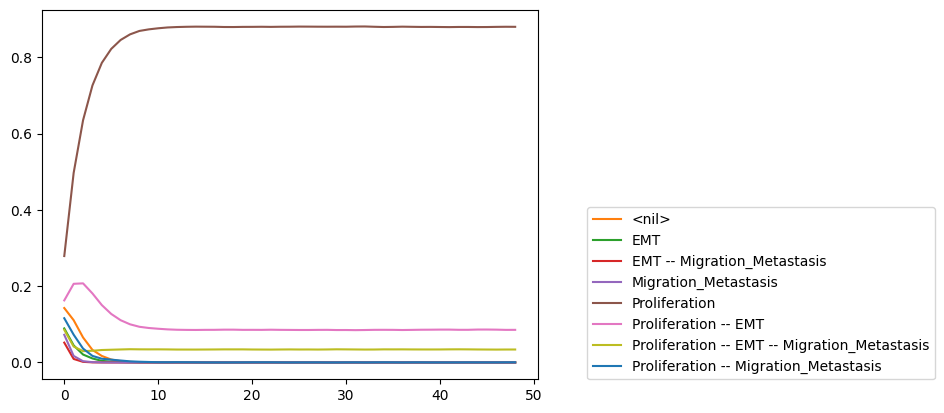

In [412]:
mutation, outputs_di = {"JAK1": 1}, {"Proliferation": 1, "EMT": 1, "Migration-Metastasis": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of MAP3K7 (expect NFKB+ (NFKBIA-), AKT+)

mutant SF3B1 (KO) promoted aberrant splicing [...] and consequent suppression of PPP2R5A and MAP3K7, critical negative regulators of AKT and NF-κB [(ref)](https://doi.org/10.1172/JCI138315)

<nil>  {AKT1=1}  {AKT1=1,AKT3=1}  {AKT2=1}  {AKT1=1,AKT2=1}  \
prob  0.119987  0.047187         0.011979  0.159596         0.034549   

      {AKT1=1,AKT2=1,AKT3=1}  {AKT2=1,AKT3=1}  {AKT2=1,NFKBIA=1}  \
prob                0.109169         0.035571           0.128404   

      {AKT1=1,AKT2=1,NFKBIA=1}  {AKT1=1,AKT2=1,AKT3=1,NFKBIA=1}  \
prob                  0.030751                         0.103531   

      {AKT2=1,AKT3=1,NFKBIA=1}  {AKT3=1}  {NFKBIA=1}  {AKT1=1,NFKBIA=1}  \
prob                  0.029829  0.027732    0.094813           0.038813   

      {AKT1=1,AKT3=1,NFKBIA=1}  {AKT3=1,NFKBIA=1}  correct  total  
prob                  0.007421           0.020668       19     24

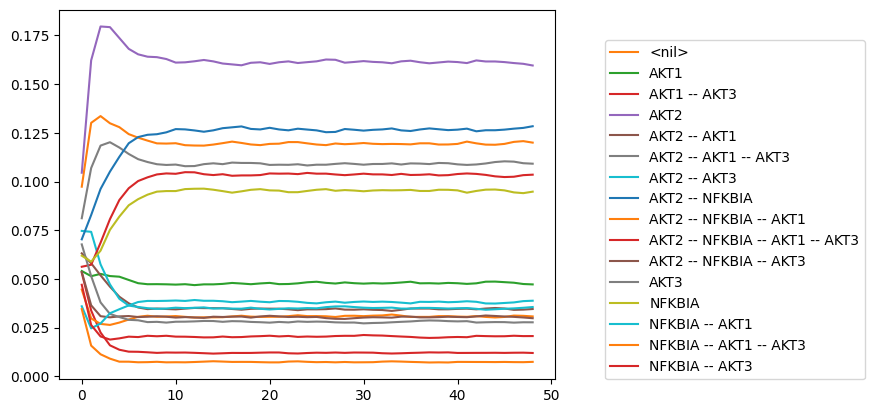

In [413]:
mutation, outputs_di = {"MAP3K7": 0}, {"NFKBIA": 0, "AKT1": 1, "AKT2": 1, "AKT3": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of CTNNA1 (expect Proliferation+)

a genome-wide CRISPR/Cas9 screen in MCF7 breast cancer cells to identify genes whose loss of function reverse Beclin 1 (BECN1)-dependent inhibition of cellular proliferation: CDH1 and CTNNA1. CRISPR/Cas9-mediated knockout of CDH1 or CTNNA1 reversed Beclin 1-dependent suppression of breast cancer cell proliferation and anchorage-independent growth [(ref)](https://doi.org/10.1073/pnas.2020478118) 

{BECN1=1,Proliferation=1}  {Proliferation=1}  correct  total
prob                     0.8995             0.1005       20     25

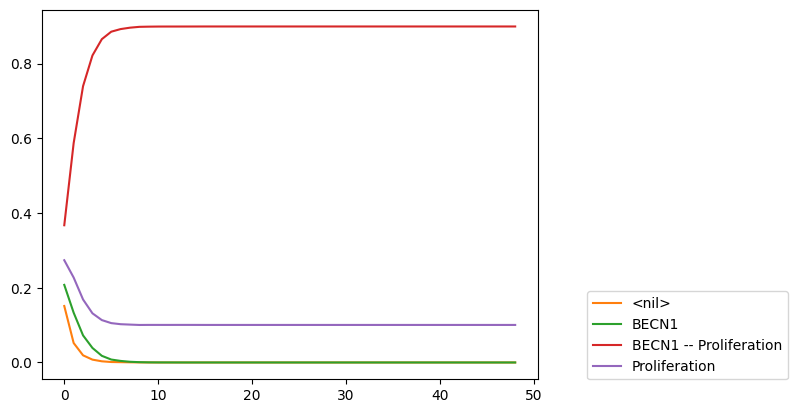

In [414]:
mutation, outputs_di = {"CTNNA1": 0}, {"BECN1": 1, "Proliferation": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of FZD1 (expect CTNNB1-)

FZD1 silencing induced down-regulation of MDR1/P-gp, restored sensitivity to four chemotherapy drugs, and significantly decreased cytoplasmic and nuclear β-catenin levels. [(ref)](https://doi.org/10.1016/j.canlet.2012.03.039)

<nil>  {CTNNB1=1}  correct  total
prob  0.8429      0.1571       21     26

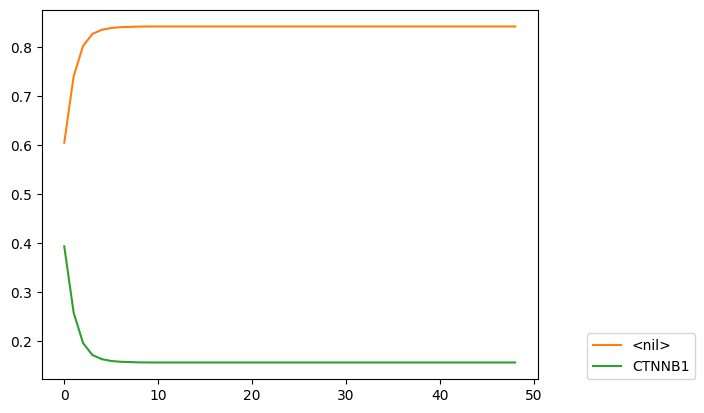

In [415]:
mutation, outputs_di = {"FZD1": 0}, {"CTNNB1": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of LRP6 (expect Cancer- (Invasion-, Proliferation-))

Knockdown LRP6 with siRNA repressed cell mobility and invasion, wheras overexpression of LRP6 promoted EMT and antagonized the EMT inhibitory effect of CA on MCF-7 cells. [(ref)](https://doi.org/10.1124/jpet.122.001189) small interference RNA (si-RNA) knockdown of LRP6 significantly reduced the clonogenic rate as well as the migration and invasion abilities of MCF-7 cells [(ref)](https://doi.org/10.21037/gs-21-194) [(ref)](https://doi.org/10.1038/s41388-022-02259-0) Conversely, overexpression of LRP6 aggravates breast cancer [(ref)](https://doi.org/10.1073/pnas.0911220107)

Error on: Invasion!=0,Proliferation!=0,EMT!=0


{Proliferation=1}  {EMT=1,Invasion=1,Proliferation=1}  \
prob             0.7366                            0.121349   

      {Invasion=1,Proliferation=1}  correct  total  
prob                      0.142051       21     27

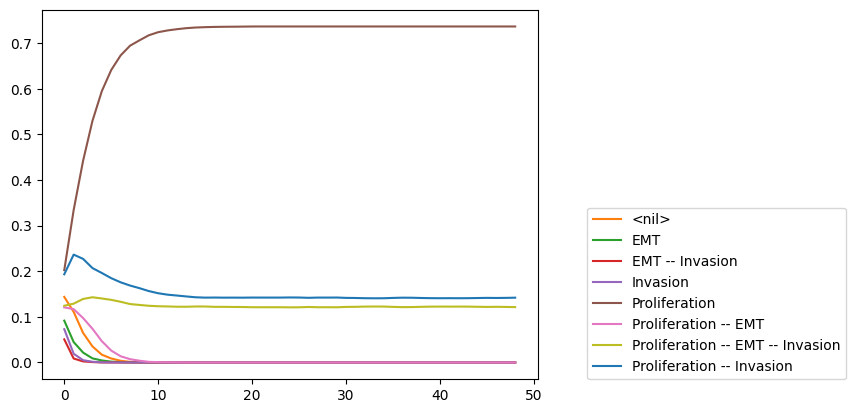

In [416]:
mutation, outputs_di = {"LRP6": 0}, {"Invasion": 0, "Proliferation": 0, "EMT": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of JAK2 (expect Cancer- (Invasion-, Proliferation-))

JAK1/JAK2 inhibitor treatment decreased STAT1 phosphorylation. [(ref)](https://doi.org/10.1016/j.canlet.2014.06.018) Ruxolitinib, a potent JAK2 inhibitor, was demonstrated to attenuate STAT3 phosphorylation and the proliferation of TAMR‑MCF‑7 cells. [(ref)](https://doi.org/10.3892/ol.2019.10059) confirmed by [(ref)](https://doi.org/10.1073/pnas.1910278117)

Error on: Invasion!=0,Proliferation!=0,EMT!=0


{Proliferation=1}  {EMT=1,Invasion=1,Proliferation=1}  \
prob             0.7422                            0.120043   

      {Invasion=1,Proliferation=1}  correct  total  
prob                      0.137757       21     28

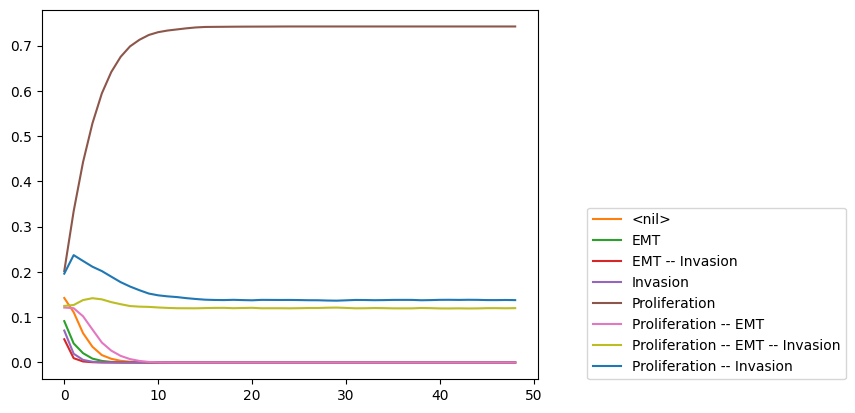

In [417]:
mutation, outputs_di = {"JAK2": 0}, {"Invasion": 0, "Proliferation": 0, "EMT": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of NEDD8 (expect ESR1-)

Inhibition of NEDD8 activation and conjugation diminished polyubiquitination of ERα and blocked proteasome-mediated degradation of receptor protein. [(ref)](https://doi.org/10.1210/me.2002-0323)

<nil>  {ESR1=1}  correct  total
prob  0.7851    0.2149       22     29

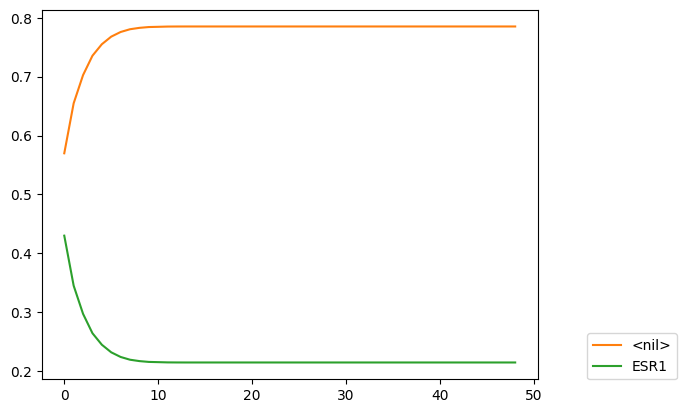

In [418]:
mutation, outputs_di = {"NEDD8": 0}, {"ESR1": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of CXCL5 (expect Cancer+)

Breast tumor-associated osteoblast-derived CXCL5 increases cancer progression by ERK/MSK1/Elk-1/Snail signaling pathway [(ref)](https://doi.org/10.1038/onc.2012.444) these results indicate for the first time that ASC‑secreted CXCL5 is a key factor promoting breast tumor cell proliferation. [(ref)](https://doi.org/10.3892/ol.2017.7522)

{Proliferation=1}  {EMT=1,Invasion=1,Proliferation=1}  \
prob             0.7401                            0.122451   

      {Invasion=1,Proliferation=1}  correct  total  
prob                      0.137449       23     30

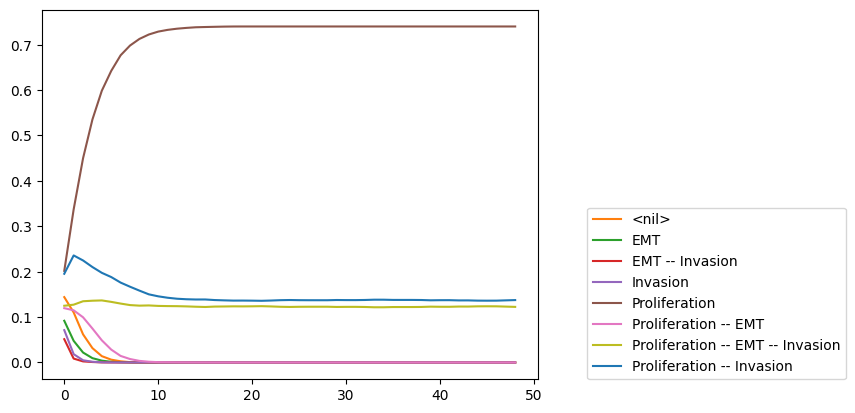

In [419]:
mutation, outputs_di = {"CXCL5": 1}, {"Invasion": 1, "Proliferation": 1, 'EMT': 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of PPP2CA (expect Growth- (Proliferation-), Invasion-, AKT-)

In vitro, miR-345-3p mimics promoted AKT phosphorylation by targeting its negative regulator, PPP2CA. Blocking miR-345-3p relieved its inhibition of PPP2CA, which attenuated PI3K-AKT signaling pathway. In vivo, inhibiting miR-345-3p by miR-345-3p-inhibition lentivirus suppressed tumor growth and invasiveness in mice. [(ref)](https://doi.org/10.1093/carcin/bgab124)

In the Oncomine database, when compared with normal breast tissues, PPP1CA, PPP2CA, PPP4C and PPEF1 were significantly elevated in breast cancer tissues, while PPP1CB, PPP2CB, PPP3CA, PPP3CB, PPP3CC and PPP6C were significantly decreased in breast cancer tissues [(ref)](https://doi.org/10.1080/21655979.2021.2012316)

Error on: AKT1!=0,AKT2!=0,AKT3!=0,Invasion!=0,Proliferation!=0


{AKT1=1,AKT3=1,Proliferation=1}  \
prob                            0.013   

      {AKT1=1,AKT3=1,Invasion=1,Proliferation=1}  {AKT1=1,Proliferation=1}  \
prob                                      0.0076                    0.0645   

      {AKT1=1,Invasion=1,Proliferation=1}  \
prob                               0.0242   

      {AKT1=1,AKT2=1,AKT3=1,Proliferation=1}  \
prob                                  0.1831   

      {AKT1=1,AKT2=1,AKT3=1,Invasion=1,Proliferation=1}  \
prob                                             0.0904   

      {AKT1=1,AKT2=1,Proliferation=1}  \
prob                           0.0554   

      {AKT1=1,AKT2=1,Invasion=1,Proliferation=1}  \
prob                                      0.0225   

      {AKT2=1,AKT3=1,Proliferation=1}  \
prob                           0.0423   

      {AKT2=1,AKT3=1,Invasion=1,Proliferation=1}  {AKT2=1,Proliferation=1}  \
prob                                      0.0135                     0.187   

      {AKT2=1,Invasion=1,Proliferation=1}  {AKT3=1,Proliferation=1}  \
prob                               0.0447                    0.0345   

      {AKT3=1,Invasion=1,Proliferation=1}  {Proliferation=1}  \
prob                               0.0121               0.16   

      {Invasion=1,Proliferation=1}  correct  total  
prob                        0.0452       23     31

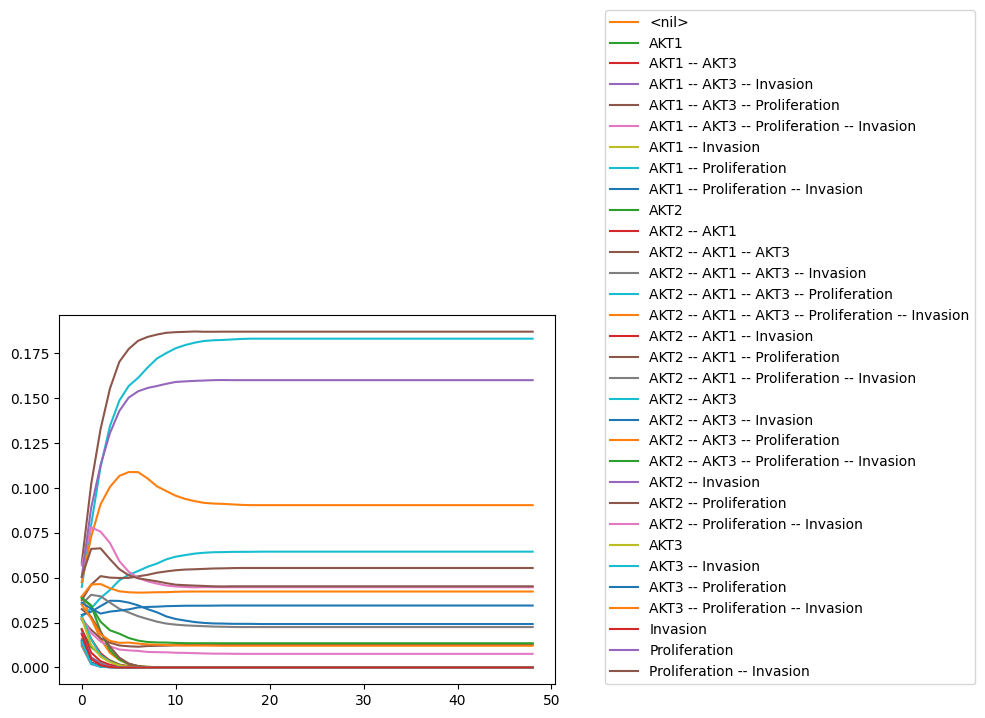

In [420]:
mutation, outputs_di = {"PPP2CA": 0}, {"AKT1": 0, 'AKT2': 0, "AKT3": 0, "Invasion": 0, "Proliferation": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of KDR (expect Proliferation-, Apoptosis+, BCL2-)

Downregulation of KDR inhibits cancer growth proliferation (siRNA, [(ref)](https://pubmed.ncbi.nlm.nih.gov/18177622)), induces cell apoptosis, reduces expression of Bcl-2 and Bcl-xl, increases Bax expression [(ref)](https://doi.org/10.2478/s11658-014-0210-8)

Error on: BCL2!=0,Apoptosis!=1,Proliferation!=0


{BCL2=1,Proliferation=1}  {Proliferation=1}  correct  total
prob                    0.1672             0.8328       23     32

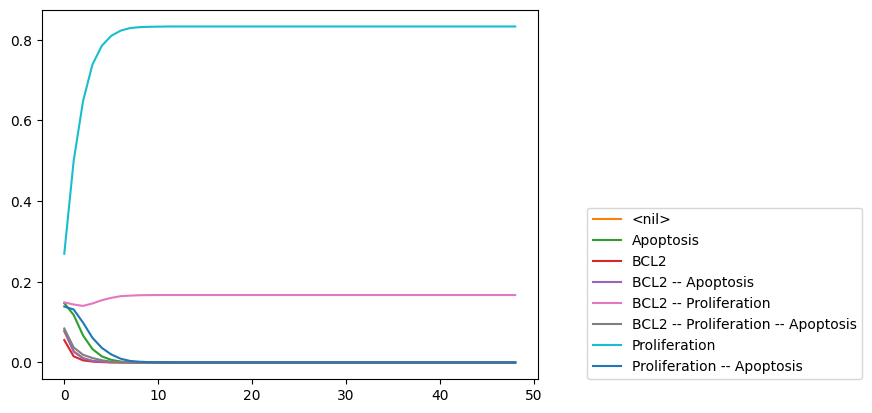

In [421]:
mutation, outputs_di = {"KDR": 0}, {"BCL2": 0, 'Apoptosis': 1, "Proliferation": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of PTTG1 (expect FGF2+, VEGFC+)

PTTG1 stimulates the expression of FGF2, VEGF [(ref)](https://doi.org/10.1210/jc.2002-020309), [(ref)](https://doi.org/10.1006/bbrc.1995.2832)

<nil>  {FGF2=1}  {VEGFC=1}  {FGF2=1,VEGFC=1}  correct  total
prob  0.5652    0.2242     0.1461            0.0645       24     33

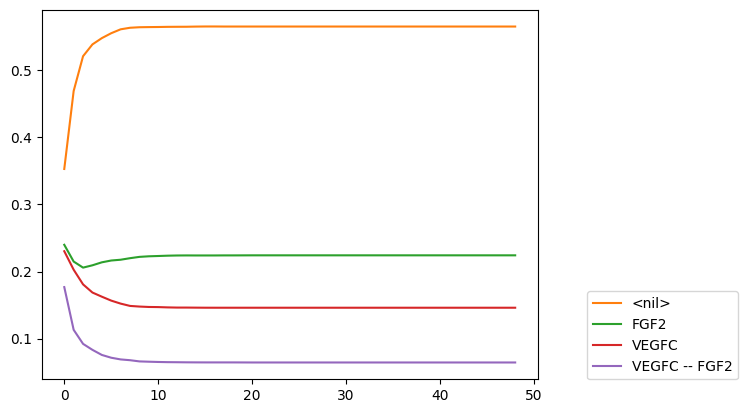

In [422]:
mutation, outputs_di = {"PTTG1": 0}, {"FGF2": 1, 'VEGFC': 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of ERBB2 (expect BECN1-)

we found that low BECN1 mRNA correlates with ERBB2-overexpression in breast cancers, suggesting that BECN1 loss and ERBB2 overexpression may functionally interact in mammary tumorigenesis [(ref)](https://doi.org/10.4161/auto.27867)

<nil>  {BECN1=1}  {Autophagia=1,BECN1=1}  correct  total
prob  0.043   0.527742                0.429258       25     34

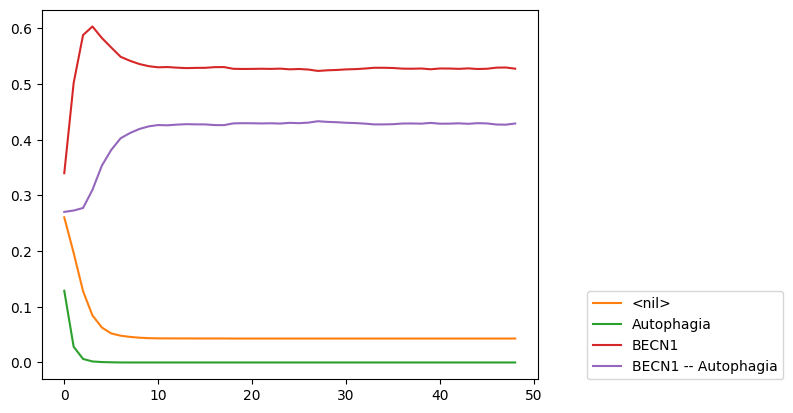

In [423]:
mutation, outputs_di = {"ERBB2": 1}, {"BECN1": 0, 'Autophagia': 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of BECN1 (expect ECadherin+)

Induces autophagy [(ref)](https://doi.org/10.1038/cdd.2008.51), [(ref)](https://doi.org/10.1371/journal.pone.0008604) By performing a genetic screen to identify genes whose loss blocks the ability of Beclin 1 to inhibit the growth of breast cancer cells and follow-up biological analyses, we have identified a mechanism by which Beclin 1 prevents breast cancer growth. We found that Beclin 1 promotes the plasma membrane localization of E-cadherin, a breast tumor-suppressor molecule that restricts tumor growth and metastases only when present at the cell surface. [(ref)](https://doi.org/10.1073/pnas.2020478118).

<nil>  {Autophagia=1}  {Autophagia=1,ECadherin=1}  {ECadherin=1}  \
prob  0.554452         0.38794                    0.056139       0.001468   

      correct  total  
prob       26     35

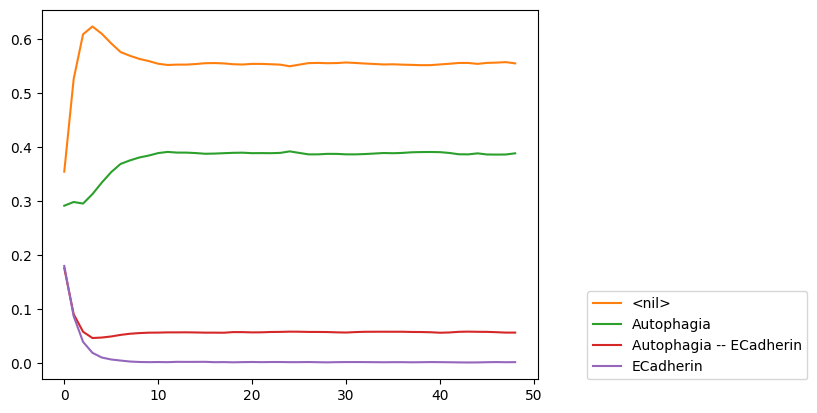

In [424]:
mutation, outputs_di = {"BECN1": 1}, {'ECadherin': 1, "Autophagia": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of IRF1 (expect Apoptosis+/CASP8+, NF-κB- (NF-κBIA+), BECN1+, BCL2-)

IRF1 is a tumor suppressor that mediates cell fate by facilitating apoptosis and can do so with or without functional p53. [(ref)](https://doi.org/10.4061/2011/912102) Increased IRF1 activation suppresses NF-κB p65 (RELA) activity, inhibits the expression of prosurvival (BCL2, BCL-W), and induces the expression of proapoptotic members (BAK, mitochondrial BAX) of the BCL2 family, activation of caspase-7 (CASP7), CASP8, and CASP9 (confirmed by [(ref)](https://aacrjournals.org/cancerres/article/68/9_Supplement/2277/545871))

{BCL2=1}  {BCL2=1,CASP8=1}  {BECN1=1}  {BCL2=1,BECN1=1}  \
prob  0.032847          0.025175   0.244402          0.018186   

      {BCL2=1,BECN1=1,CASP8=1}  {BECN1=1,CASP8=1}  {BCL2=1,NFKBIA=1}  \
prob                  0.014249           0.212349           0.023153   

      {BCL2=1,CASP8=1,NFKBIA=1}  {BECN1=1,NFKBIA=1}  \
prob                   0.027325            0.170298   

      {BCL2=1,BECN1=1,NFKBIA=1}  {BCL2=1,BECN1=1,CASP8=1,NFKBIA=1}  \
prob                   0.012314                           0.015251   

      {BECN1=1,CASP8=1,NFKBIA=1}  correct  total  
prob                    0.204451       27     36

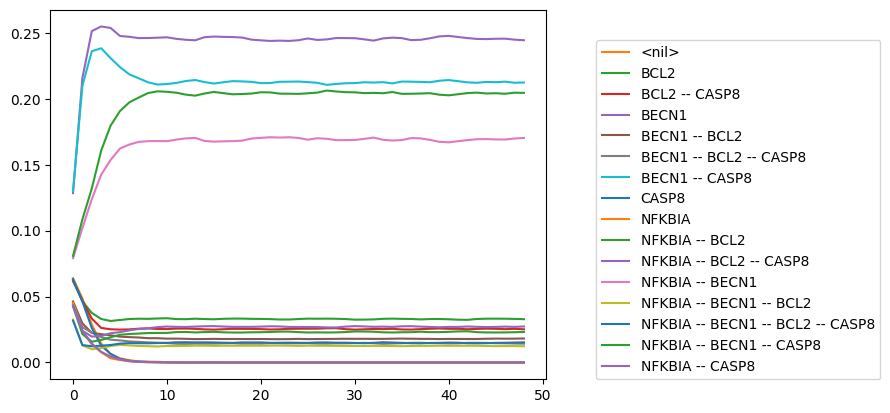

In [425]:
mutation, outputs_di = {"IRF1": 1}, {"CASP8": 1, 'NFKBIA': 1, "BECN1": 1, "BCL2": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of IRF1 (expect CASP8-,EMT+,SMAD4+,SMAD3+)

The abilities of IFNγ to activate CASP8, induce apoptosis, and restore antiestrogen sensitivity are prevented by siRNA targeting IRF1, whereas transient overexpression of IRF1 mimics the effects of IFNγ treatment [(ref)](https://doi.org/10.1158/1535-7163.MCT-09-1169)

RNAi-mediated ablation of Irf1 in mammary epithelial cells results in the expression of mesenchymal factors and Smad transcriptional activity. [(ref)](https://doi.org/10.1038/s41388-020-1326-0)

<nil>  {CASP8=1}  {CASP8=1,EMT=1}   {EMT=1}  {SMAD3=1}  \
prob  0.211689   0.209314         0.026386  0.031711    0.04325   

      {CASP8=1,SMAD3=1}  {CASP8=1,EMT=1,SMAD3=1}  {EMT=1,SMAD3=1}  \
prob             0.0443                   0.0055          0.00635   

      {SMAD3=1,SMAD4=1}  {CASP8=1,SMAD3=1,SMAD4=1}  \
prob             0.0097                   0.011626   

      {CASP8=1,EMT=1,SMAD3=1,SMAD4=1}  {EMT=1,SMAD3=1,SMAD4=1}  {SMAD4=1}  \
prob                         0.001174                   0.0021   0.171358   

      {CASP8=1,SMAD4=1}  {CASP8=1,EMT=1,SMAD4=1}  {EMT=1,SMAD4=1}  correct  \
prob            0.17658                  0.02312         0.025842       28   

      total  
prob     37

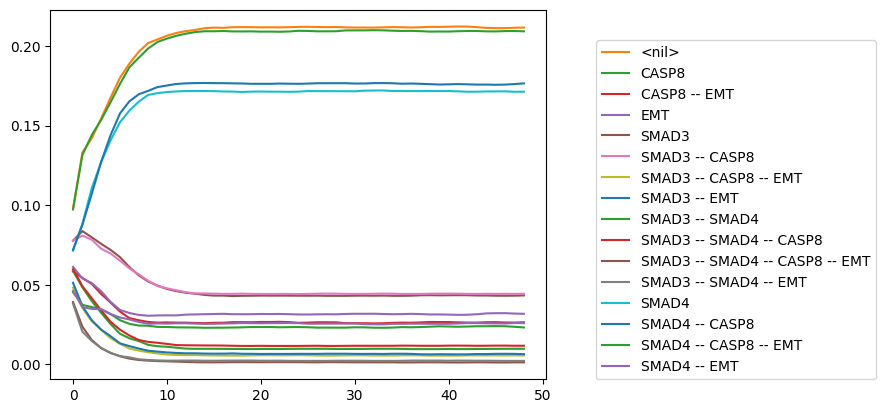

In [426]:
mutation, outputs_di = {"IRF1": 0}, {"CASP8": 0, 'EMT': 1, "SMAD3": 1, "SMAD4": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of SMAD4 (expect Proliferation-, ESR1-, Apoptosis+, Autophagy+, TGFB3+)

The protein acts as a tumor suppressor and inhibits epithelial cell proliferation. It may also have an inhibitory effect on tumors by reducing angiogenesis and increasing blood vessel hyperpermeability. [(ref)](https://www.genecards.org/cgi-bin/carddisp.pl?gene=SMAD4&keywords=SMAD4)

The results suggest a novel negative regulation of ERα by TGF-β/SMAD4 in breast cancer cells and indicate that the SMAD4 protein is involved in the degradation of ERα induced by bergapten. [(ref)](https://doi.org/10.1007/s10549-012-2282-3)

Smad4 induces apoptosis in ERα-positive MCF-7 breast cancer cells [(ref)](https://doi.org/10.1074/jbc.M505071200) MAD4 is a downstream mediator of transforming growth factor beta [(ref)](https://doi.org/10.1007/s13277-013-1088-1) Smad4-expression correlated positively with expression of TGF-β-receptor I (p < 0.001, n = 197) and TGF-β-receptor II (p < 0.001, n = 197) [(ref)](https://doi.org/10.1186/1471-2407-6-25)

Error on: Apoptosis!=1,ESR1!=0


<nil>  {Autophagia=1}  {ESR1=1}  {Autophagia=1,ESR1=1}  {TGFB3=1}  \
prob  0.443741        0.270959   0.09109                0.05841    0.02985   

      {Autophagia=1,TGFB3=1}  {ESR1=1,TGFB3=1}  {Autophagia=1,ESR1=1,TGFB3=1}  \
prob                 0.04315          0.039044                       0.023756   

      correct  total  
prob       28     38

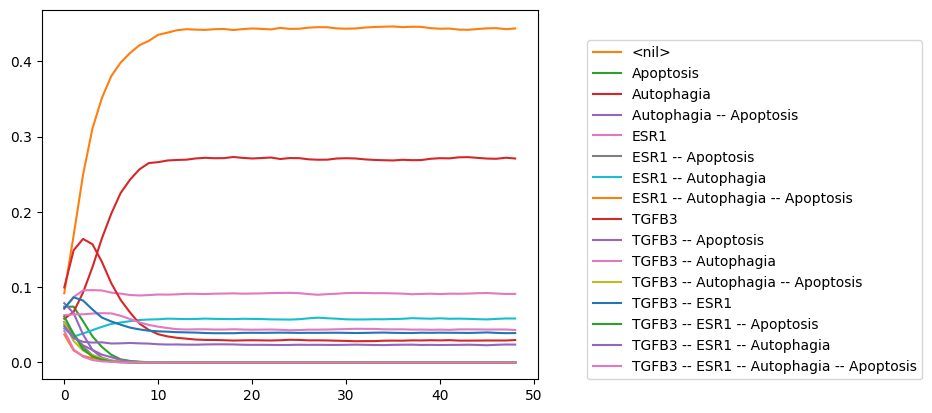

In [427]:
mutation, outputs_di = {"SMAD4": 1}, {"Apoptosis": 1, 'ESR1': 0, "Autophagia": 1, "TGFB3": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of CDC25A, CDK1 and CDK4 (expect Apoptosis+)

DIM inhibited the breast cancer cell growth in vitro and in vivo, and caused cell-cycle arrest by down-regulating protein levels of cell-cycle related kinases CDK1, CDK2, CDK4, and CDK6, as well as Cyclin B1 and Cdc25A. [(ref)](https://doi.org/10.1007/s11010-011-0985-0)

Error on: Apoptosis!=1


{Proliferation=1}  correct  total
prob                1.0       28     39

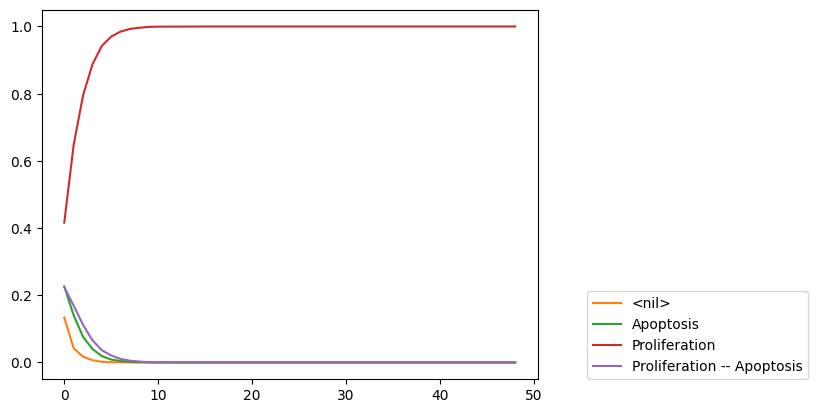

In [428]:
mutation, outputs_di = {"CDC25A": 0, "CDK1": 0, "CDK4": 0}, {"Apoptosis": 1, "Proliferation": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of RELA (expect PEBP1-)

One involves RELA (transcription factor p65) and SNAI1, which were previously reported to inhibit PEBP1. The other involves the estrogen receptor (ESR1), which induces PEBP1 through the kinase NME1. PEBP1 inhibits cancer metastasis at different stages, including epithelial to mesenchymal transition (EMT), migration, and invasion. Low expression of PEBP1 is associated with cancer metastasis and poor prognosis [(ref)](https://doi.org/10.3390/cancers13236098)

Error on: PEBP1!=0


{PEBP1=1}  correct  total
prob        1.0       28     40

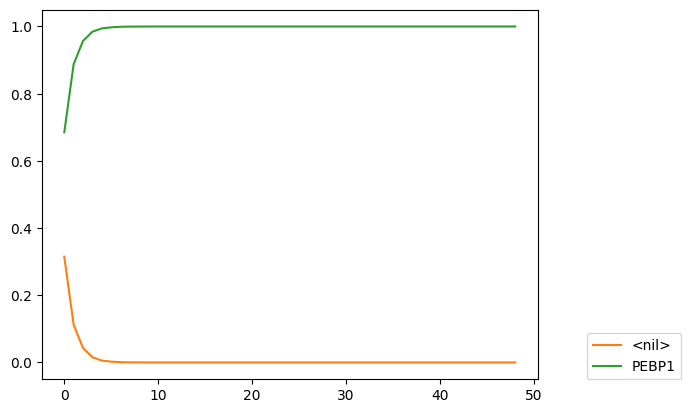

In [429]:
mutation, outputs_di = {"RELA": 1}, {"PEBP1": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of PEBP1 (expect Migration-Metastasis+, EMT+, Invasion+)

MiR-4443 promotes the migration and invasion of breast cancer cells by inhibiting the expression of PEBP1 [(ref)](https://doi.org/10.12122/j.issn.1673-4254.2020.12.03)

<nil>  {EMT=1,Invasion=1}  {EMT=1,Invasion=1,Migration_Metastasis=1}  \
prob  0.7501            0.086624                                   0.031174   

      {Invasion=1}  {Invasion=1,Migration_Metastasis=1}  correct  total  
prob      0.132019                             0.000084       29     41

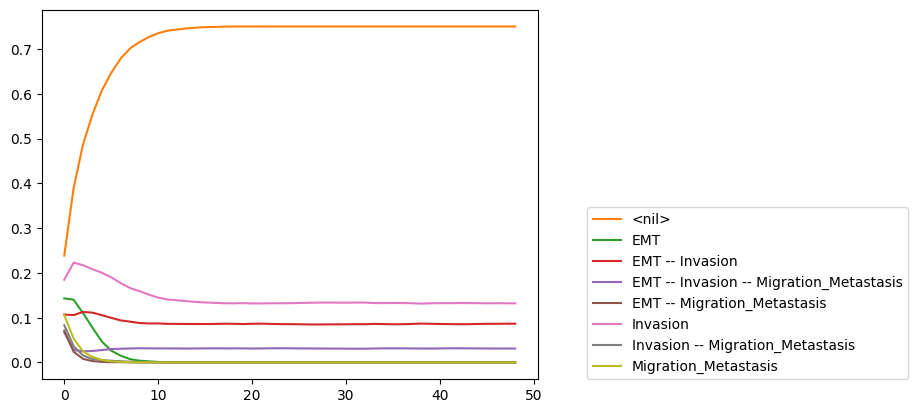

In [430]:
mutation, outputs_di = {"PEBP1": 0}, {"Migration-Metastasis": 1, "EMT": 1, "Invasion": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of IRS1 (expect ESR1+, Proliferation+,HIF1A+,VEGFC+,AKT+)

IRS-1 overexpression has been associated with breast cancer development, hormone independence and antiestrogen resistance. [(ref)](https://doi.org/10.1021/bc070135v) action of anti-IRS1 siRNAs induced the apoptotic response, observed by altered mitochondrial membrane potential coupled with downregulation of NF-κB target Bcl-xL and reduced cell viability [(ref)](https://doi.org/10.1002/jcb.20817) miR-30e blocked the activation of AKT and ERK1/2 pathways, and the expression of HIF-1α and VEGF via directly targeting IRS1 [(ref)](https://doi.org/10.1038/s41598-017-16175-x)

{AKT1=1,AKT3=1,Proliferation=1}  {AKT1=1,AKT3=1,ESR1=1,Proliferation=1}  \
prob                           0.0044                                  0.0012   

      {AKT1=1,ESR1=1,Proliferation=1}  \
prob                           0.0053   

      {AKT1=1,AKT3=1,HIF1A=1,Proliferation=1}  \
prob                                   0.0076   

      {AKT1=1,AKT3=1,ESR1=1,HIF1A=1,Proliferation=1}  \
prob                                           0.001   

      {AKT1=1,ESR1=1,HIF1A=1,Proliferation=1}  \
prob                                   0.0072   

      {AKT1=1,HIF1A=1,Proliferation=1}  \
prob                             0.035   

      {AKT1=1,AKT3=1,HIF1A=1,Proliferation=1,VEGFC=1}  \
prob                                           0.0025   

      {AKT1=1,AKT3=1,ESR1=1,HIF1A=1,Proliferation=1,VEGFC=1}  \
prob                                             0.0007        

      {AKT1=1,ESR1=1,HIF1A=1,Proliferation=1,VEGFC=1}  \
prob                                           0.0028   

      {AKT1=1,HIF1A=1,Proliferation=1,VEGFC=1}  {AKT1=1,Proliferation=1}  \
prob                                    0.0079                    0.0202   

      {AKT1=1,AKT3=1,Proliferation=1,VEGFC=1}  \
prob                                   0.0005   

      {AKT1=1,AKT3=1,ESR1=1,Proliferation=1,VEGFC=1}  \
prob                                          0.0001   

      {AKT1=1,ESR1=1,Proliferation=1,VEGFC=1}  \
prob                                   0.0017   

      {AKT1=1,Proliferation=1,VEGFC=1}  \
prob                            0.0052   

      {AKT1=1,AKT2=1,AKT3=1,Proliferation=1}  \
prob                                  0.0468   

      {AKT1=1,AKT2=1,AKT3=1,ESR1=1,Proliferation=1}  \
prob                                         0.0155   

      {AKT1=1,AKT2=1,ESR1=1,Proliferation=1}  \
prob                                   0.004   

      {AKT1=1,AKT2=1,AKT3=1,HIF1A=1,Proliferation=1}  \
prob                                          0.1192   

      {AKT1=1,AKT2=1,AKT3=1,ESR1=1,HIF1A=1,Proliferation=1}  \
prob                                              0.032       

      {AKT1=1,AKT2=1,ESR1=1,HIF1A=1,Proliferation=1}  \
prob                                          0.0126   

      {AKT1=1,AKT2=1,HIF1A=1,Proliferation=1}  \
prob                                   0.0307   

      {AKT1=1,AKT2=1,AKT3=1,HIF1A=1,Proliferation=1,VEGFC=1}  \
prob                                             0.0271        

      {AKT1=1,AKT2=1,AKT3=1,ESR1=1,HIF1A=1,Proliferation=1,VEGFC=1}  \
prob                                             0.0127               

      {AKT1=1,AKT2=1,ESR1=1,HIF1A=1,Proliferation=1,VEGFC=1}  \
prob                                             0.0039        

      {AKT1=1,AKT2=1,HIF1A=1,Proliferation=1,VEGFC=1}  \
prob                                           0.0081   

      {AKT1=1,AKT2=1,Proliferation=1}  \
prob                           0.0133   

      {AKT1=1,AKT2=1,AKT3=1,Proliferation=1,VEGFC=1}  \
prob                                          0.0121   

      {AKT1=1,AKT2=1,AKT3=1,ESR1=1,Proliferation=1,VEGFC=1}  \
prob                                             0.0042       

      {AKT1=1,AKT2=1,ESR1=1,Proliferation=1,VEGFC=1}  \
prob                                          0.0016   

      {AKT1=1,AKT2=1,Proliferation=1,VEGFC=1}  \
prob                                   0.0036   

      {AKT2=1,AKT3=1,Proliferation=1}  {AKT2=1,AKT3=1,ESR1=1,Proliferation=1}  \
prob                           0.0181                                  0.0058   

      {AKT2=1,ESR1=1,Proliferation=1}  \
prob                           0.0235   

      {AKT2=1,AKT3=1,HIF1A=1,Proliferation=1}  \
prob                                   0.0148   

      {AKT2=1,AKT3=1,ESR1=1,HIF1A=1,Proliferation=1}  \
prob                                          0.0037   

      {AKT2=1,ESR1=1,HIF1A=1,Proliferation=1}  \
prob                                   0.0192   

      {AKT2=1,HIF1A=1,Proliferation=1}  \
prob                             0.067   

      

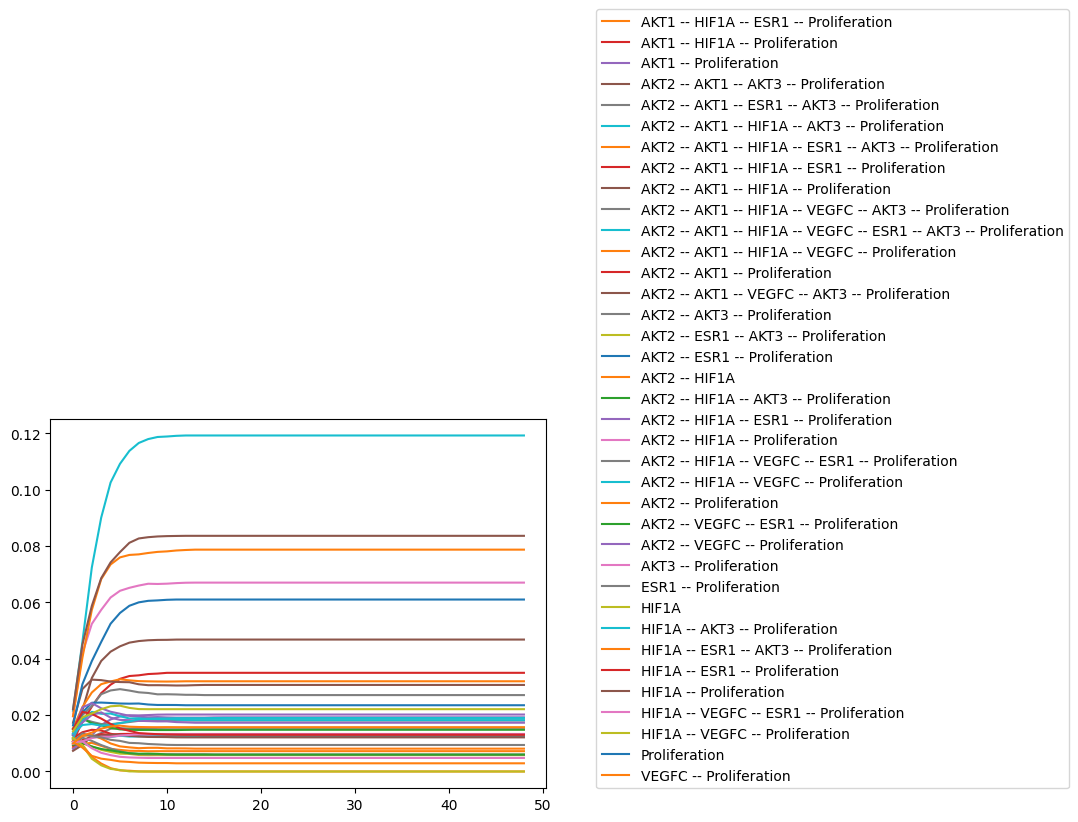

In [431]:
mutation, outputs_di = {"IRS1": 1}, {"ESR1": 1, "Proliferation": 1, "HIF1A": 1, "VEGFC": 1, "AKT1": 1, "AKT2": 1, "AKT3": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of IRS1 (expect ESR1-, Proliferation-, Apoptosis+, HIF1A-, VEGFC-, AKT1-, AKT2-, AKT3-)

Decreasing IRS1 in MCF7 cells decreases ERalpha expression levels. [(ref)](https://doi.org/10.1016/j.canlet.2013.03.030) 

<nil>  {ESR1=1}  correct  total
prob  0.7882    0.2118       31     43

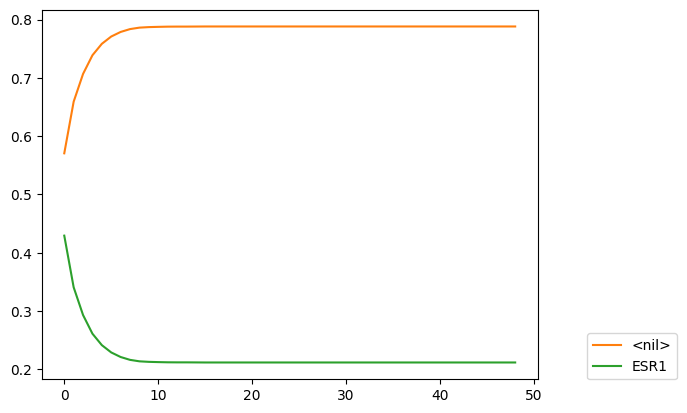

In [432]:
mutation, outputs_di = {"IRS1": 0}, {"ESR1": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of CCL2-CCR2 (expect Migration-Metastasis+, AKT+, NFKB+ (NFKBIA-), SMAD3+,MAPK8+,MAPK10+)

Estrogen promotes progression of hormone-dependent breast cancer through CCL2-CCR2 (increased secretion of CCL2, activation of AKT and NFBK phosphorylation (either enhances/inhibits [(ref)](https://doi.org/10.3390/cells5010012)) axis by upregulation of Twist via PI3K/AKT/NF-κB signaling => axis CCL2-CCR2 potentially anticancer [(ref)](https://doi.org/10.1038/s41598-018-27810-6) The G protein-coupled receptor CCR2 was found to be elevated in breast cancers, correlating with CCL2 expression.  [(ref)](https://doi.org/10.1074/jbc.M112.365999)

Error on: NFKBIA!=0,SMAD3!=0,MAPK8!=0,MAPK10!=0


{AKT1=1,MAPK10=1,MAPK8=1}  {AKT1=1,AKT3=1,MAPK10=1,MAPK8=1}  \
prob                   0.015069                            0.0034   

      {AKT1=1,MAPK8=1}  {AKT1=1,AKT3=1,MAPK8=1}  \
prob          0.029722                   0.0055   

      {AKT1=1,AKT2=1,MAPK10=1,MAPK8=1}  \
prob                          0.011892   

      {AKT1=1,AKT2=1,AKT3=1,MAPK10=1,MAPK8=1}  \
prob                                 0.036641   

      {AKT1=1,AKT2=1,AKT3=1,MAPK10=1,MAPK8=1,Migration_Metastasis=1}  \
prob                                           0.008669                

      {AKT1=1,AKT2=1,MAPK8=1}  {AKT1=1,AKT2=1,AKT3=1,MAPK8=1}  \
prob                 0.023272                        0.059294   

      {AKT1=1,AKT2=1,AKT3=1,MAPK8=1,Migration_Metastasis=1}  \
prob                                            0.01407       

      {AKT2=1,MAPK10=1,MAPK8=1}  {AKT2=1,AKT3=1,MAPK10=1,MAPK8=1}  \
prob                   0.016677                          0.003816   

      {AKT2=1,MAPK8=1}  {AKT2=1,AKT3=1,MAPK8=1}  \
prob          0.113296                 0.026949   

      {AKT1=1,AKT2=1,MAPK10=1,MAPK8=1,NFKBIA=1}  \
prob                                   0.009108   

      {AKT1=1,AKT2=1,AKT3=1,MAPK10=1,MAPK8=1,NFKBIA=1}  \
prob                                          0.028359   

      {AKT1=1,AKT2=1,AKT3=1,MAPK10=1,MAPK8=1,Migration_Metastasis=1,NFKBIA=1}  \
prob                                           0.002931                         

      {AKT1=1,AKT2=1,MAPK8=1,NFKBIA=1}  \
prob                          0.018328   

      {AKT1=1,AKT2=1,AKT3=1,MAPK8=1,NFKBIA=1}  \
prob                                 0.054677   

      {AKT1=1,AKT2=1,AKT3=1,MAPK8=1,Migration_Metastasis=1,NFKBIA=1}  \
prob                                            0.00166                

      {AKT2=1,MAPK10=1,MAPK8=1,NFKBIA=1}  \
prob                            0.008123   

      {AKT2=1,AKT3=1,MAPK10=1,MAPK8=1,NFKBIA=1}  {AKT2=1,MAPK8=1,NFKBIA=1}  \
prob                                   0.002084                   0.084204   

      {AKT2=1,AKT3=1,MAPK8=1,NFKBIA=1}  \
prob                          0.021751   

      {AKT1=1,AKT2=1,MAPK10=1,MAPK8=1,NFKBIA=1,SMAD3=1}  \
prob                                           0.007936   

      {AKT1=1,AKT2=1,AKT3=1,MAPK10=1,MAPK8=1,NFKBIA=1,SMAD3=1}  \
prob                                           0.024812          

      {AKT1=1,AKT2=1,AKT3=1,MAPK10=1,MAPK8=1,Migration_Metastasis=1,NFKBIA=1,SMAD3=1}  \
prob                                             0.0016                                 

      {AKT1=1,AKT2=1,MAPK8=1,NFKBIA=1,SMAD3=1}  \
prob                                  0.003365   

      {AKT1=1,AKT2=1,AKT3=1,MAPK8=1,NFKBIA=1,SMAD3=1}  \
prob                                         0.010768   

      {AKT1=1,AKT2=1,AKT3=1,MAPK8=1,Migration_Metastasis=1,NFKBIA=1,SMAD3=1}  \
prob                                             0.0016                        

      {AKT2=1,MAPK10=1,MAPK8=1,NFKBIA=1,SMAD3=1}  \
prob                                    0.005326   

      {AKT2=1,AKT3=1,MAPK10=1,MAPK8=1,NFKBIA=1,SMAD3=1}  \
prob                                           0.001852   

      {AKT1=1,AKT2=1,MAPK10=1,MAPK8=1,SMAD3=1}  \
prob                                  0.004264   

      {AKT1=1,AKT2=1,AKT3=1,MAPK10=1,MAPK8=1,SMAD3=1}  \
prob                                         0.011488   

      {AKT1=1,AKT2=1,AKT3=1,MAPK10=1,MAPK8=1,Migration_Metastasis=1,SMAD3=1}  \
prob                                             0.0026                        

      {AKT1=1,AKT2=1,MAPK8=1,SMAD3=1}  {AKT1=1,AKT2=1,AKT3=1,MAPK8=1,SMAD3=1}  \
prob                         0.001535                                0.004432   

      {AKT1=1,AKT2=1,AKT3=1,MAPK8=1,Migration_Metastasis=1,SMAD3=1}  \
prob                                             0.0021               

      {AKT2=1,MAPK10=1,MAPK8=1,SMAD3=1}  \
prob                           0.005774   

      {AKT2=1,AKT3=1,MAPK10=1,MAPK8=1,SMAD3=1}  {MAPK10=1,MAPK8=1}  \
prob                

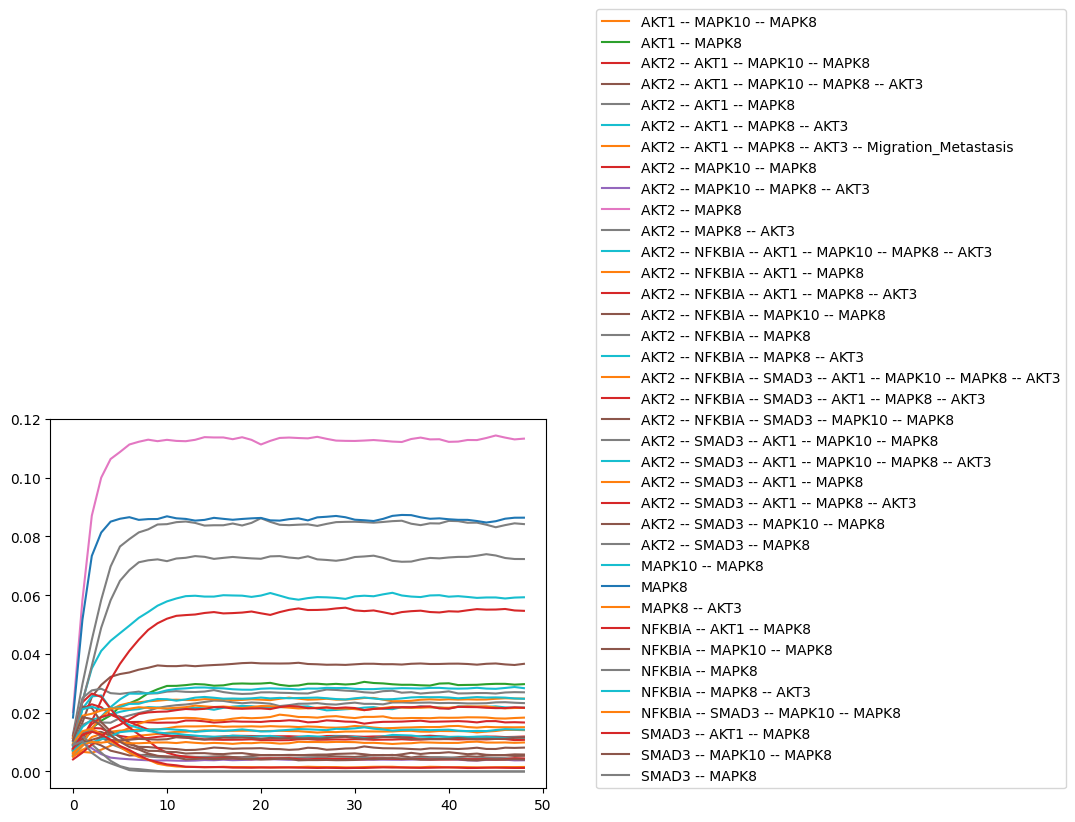

In [433]:
mutation, outputs_di = {"CCR2": 1}, {"AKT1": 1, "AKT2": 1, "AKT3": 1, "NFKBIA": 0, "Migration-Metastasis": 1,"SMAD3":0,"MAPK8": 0, "MAPK10": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of CCR2 (expect Migration-Metastasis-, SMAD3-,MAPK8-,MAPK10-)

RNA interference of CCR2 expression in breast cancer cells significantly inhibited CCL2-induced migration, survival, and phosphorylation of Smad3 and p42/44MAPK proteins. [(ref)](https://doi.org/10.1074/jbc.M112.365999)

Error on: Migration_Metastasis!=0,SMAD3!=0,MAPK8!=0,MAPK10!=0


{MAPK10=1,MAPK8=1}  {MAPK10=1,MAPK8=1,Migration_Metastasis=1}  \
prob              0.1869                                     0.0108   

      {MAPK8=1}  {MAPK8=1,Migration_Metastasis=1}  {MAPK10=1,MAPK8=1,SMAD3=1}  \
prob   0.663941                          0.015359                       0.089   

      {MAPK10=1,MAPK8=1,Migration_Metastasis=1,SMAD3=1}  {MAPK8=1,SMAD3=1}  \
prob                                             0.0049             0.0254   

      {MAPK8=1,Migration_Metastasis=1,SMAD3=1}  correct  total  
prob                                    0.0037       31     45

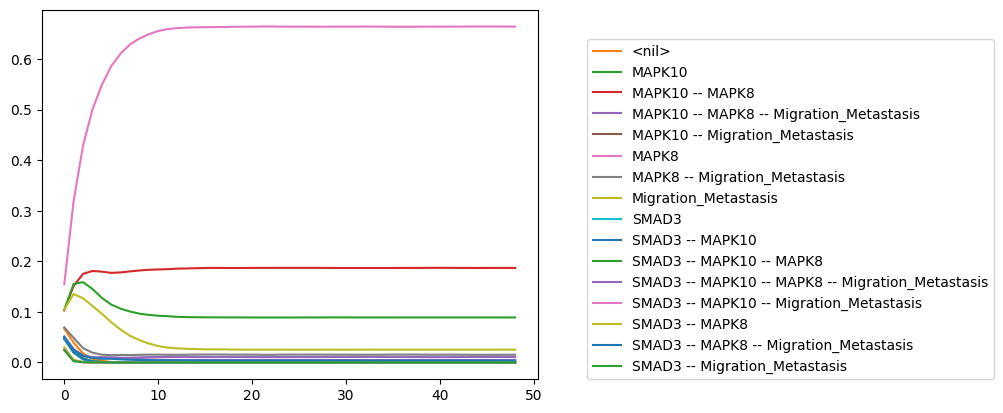

In [434]:
mutation, outputs_di = {"CCR2": 0}, {"Migration-Metastasis": 0,"SMAD3":0,"MAPK8": 0, "MAPK10": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of GADD45A (expect CDK1-, Proliferation-)

GADD45A and BTG2 are two major inhibitors of CDK1, which have been implicated in breast tumor formation. ERβ stimulates GADD45A and BTG2 mRNA levels. The induction of these two genes is caused by ERβ binding directly to these genes and recruiting c-jun and NCOA2. ERβ causes a G2 cell cycle arrest by inactivating CDK1 through the repression of cyclin B1 and stimulation of GADD45A and BTG2 expression. [(ref)](https://doi.org/10.1007/s10549-010-1273-5)

Furthermore, knockdown of Foxo3A reduced the expression of Noxa and Gadd45A in MCF7 cells. Strikingly, in the microarray data sets derived from breast cancer patients, expression of Foxm1, Plk1, Survivin, Cdk2 and Cdc2 in ERα+ tumors showed a strong correlation with poor prognosis, while expression of Gadd45A and BTG2 correlated with good prognosis [(ref)](https://doi.org/10.1002/ijc.29404) 

Error on: Proliferation!=0,CDK1!=0


{CDK1=1,Proliferation=1}  {Proliferation=1}  correct  total
prob                    0.0399             0.9601       31     46

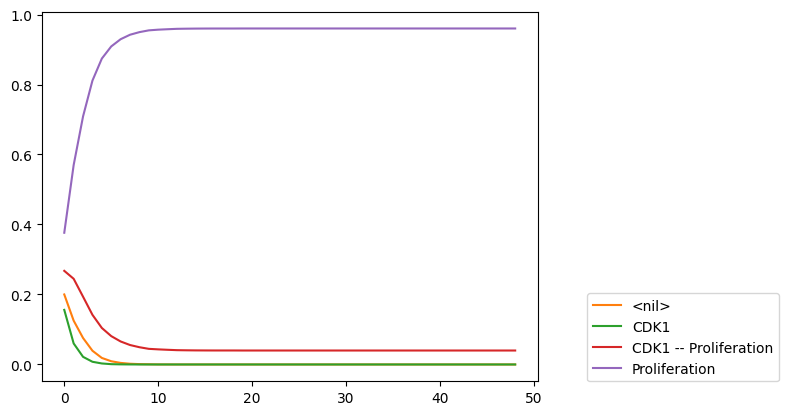

In [435]:
mutation, outputs_di = {"GADD45A": 1}, {"Proliferation": 0, "CDK1": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Overexpression of PTPN6 (expect Migration-Metastasis-)

In vitro and in vivo studies showed that the inhibitory effects of Compound 12 on phospho-STAT3 were through up-regulation of the protein–tyrosine phosphatase PTPN6. The aberrant activation of STAT3 occurs in many human cancers and promotes tumor progression. Phosphorylation of a tyrosine at amino acid Y705 is essential for the function of STAT3. [(ref)](https://doi.org/10.1021/jm4018042)

<nil>  {Migration_Metastasis=1}  correct  total
prob  0.963932                  0.036068       32     47

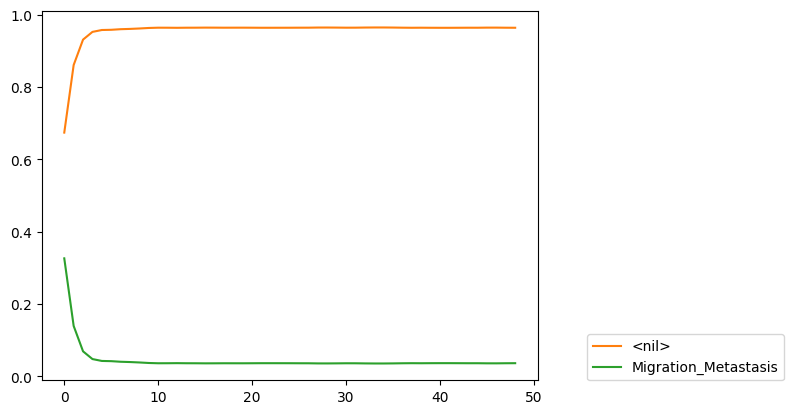

In [436]:
mutation, outputs_di = {"PTPN6": 1}, {"Migration-Metastasis": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of FZD6 (expect Migration-Metastasis-, Invasion-)

Ablation of FZD6 expression in mammary cancer cell lines: (1) inhibited motility and invasion; (2) induced a more symmetrical shape of organoid three-dimensional cultures; and (3) inhibited bone and liver metastasis in vivo. [(ref)](https://doi.org/10.1002/path.4841)

breast cancer patients with high FZD6 gene expression showed worse DMFS, while high FZD4 levels were associated with favorable DMFS [(ref)](https://ediss.uni-goettingen.de/handle/11858/14387)

<nil>  {Invasion=1}  {Invasion=1,Migration_Metastasis=1}  correct  \
prob  0.7504      0.217207                             0.032393       33   

      total  
prob     48

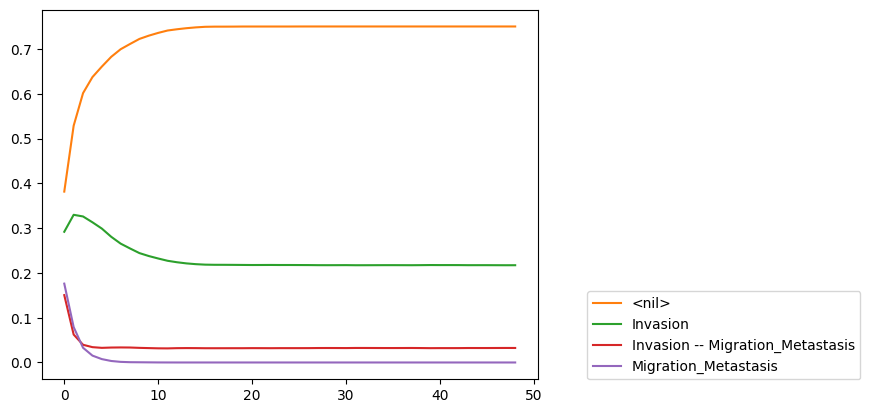

In [437]:
mutation, outputs_di = {"FZD6": 0}, {"Migration-Metastasis":0, "Invasion": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p 

#### Knockdown of MAPK10 (expect Proliferation+, Invasion+)

MicroRNA-21 promotes progression of breast cancer via inhibition of mitogen-activated protein kinase10 (MAPK10) [(ref)](https://doi.org/10.1042/bsr20181000)

<nil>  {Invasion=1}  {Invasion=1,Migration_Metastasis=1}  correct  \
prob  0.7892      0.180783                             0.030017       34   

      total  
prob     49

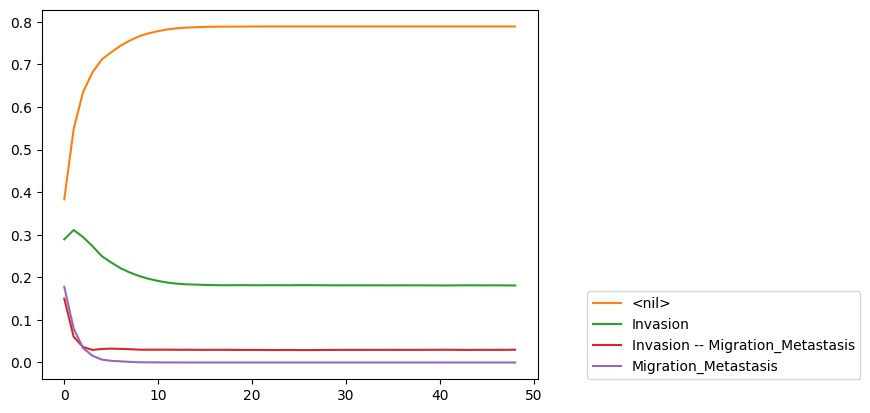

In [438]:
mutation, outputs_di = {"MAPK10": 0}, {"Migration-Metastasis":1, "Invasion": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p 

#### Overexpression of DKK2 (expect Proliferation-, CTNNB1-)

Dickkopf-related protein 2 (DKK2) is one of the antagonists of Wnt/β-catenin signaling, with its downregulation reported in multiple cancers. restored expression of DKK2 in MCF7 cells disrupted the microtube formation of human umbilical vein endothelial cells on Matrigel®. DKK2 suppressed canonical Wnt/β-catenin signaling by inhibiting β-catenin activity with decreased active β-catenin protein. [(ref)](https://doi.org/10.18632/oncotarget.17055)

Error on: Proliferation!=0,CTNNB1!=0


{CTNNB1=1,Proliferation=1}  {Proliferation=1}  correct  total
prob                      0.0015             0.9985       34     50

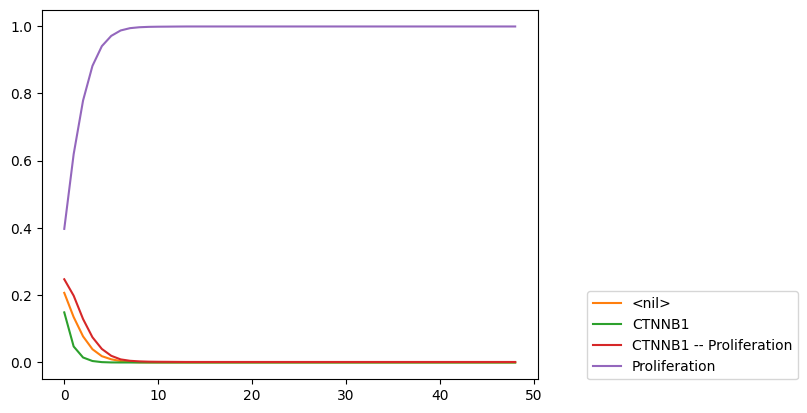

In [439]:
mutation, outputs_di = {"DKK2": 1}, {"Proliferation":0, "CTNNB1": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p 

#### Knockdown of HRAS and PIK3CA (expect Migration-Metastasis-, Apoptosis+, Proliferation-)

MAP2K1, PIK3CA, HRAS, EGFR, Caspase3, and PTGS2 were the hub targets of Syringin against BC. And PIK3CA and HRAS were related to the survival and prognosis of BC patients. Syringin inhibited the proliferation and migration and promoted apoptosis of BC cells [(ref)](https://doi.org/10.1186/s12967-022-03504-6)

<nil>  {Apoptosis=1}  {Apoptosis=1,Migration_Metastasis=1}  \
prob  0.079687       0.775683                              0.000165   

      {Migration_Metastasis=1}  {Proliferation=1}  \
prob                  0.000835            0.11849   

      {Apoptosis=1,Proliferation=1}  \
prob                       0.022107   

      {Apoptosis=1,Migration_Metastasis=1,Proliferation=1}  \
prob                                           0.000162      

      {Migration_Metastasis=1,Proliferation=1}  correct  total  
prob                                  0.002871       35     51

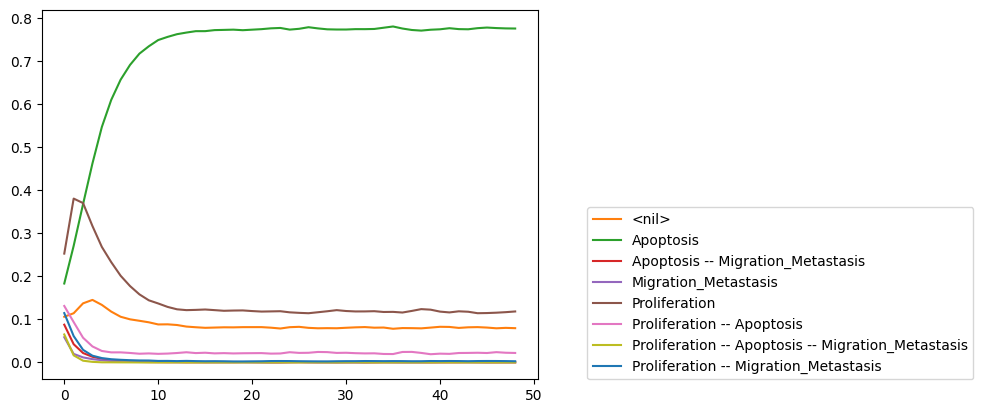

In [440]:
mutation, outputs_di = {"HRAS": 0, "PIK3CA": 0}, {"Migration-Metastasis": 0, "Proliferation": 0, "Apoptosis": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

####  Overexpression of ESR1 (expect Proliferation+, PEBP1+, TP53-, AKT+, NFKB+,MYC+,CDK4+,CCNA1+)

Estrogen alpha (ERa) (directly) suppress TP53/TP21 and up-regulates PCNA and (proliferation-related) KI-67 to promote proliferation in MCF7 [(ref)](https://doi.org/10.1111/febs.12658) [(ref)](https://doi.org/10.1016/s0303-7207(00)00273-2)

Estrogen promotes progression of hormone-dependent breast cancer through CCL2-CCR2 (increased secretion of CCL2, activation of AKT and NFBK phosphorylation (either enhances/inhibits [(ref)](https://doi.org/10.3390/cells5010012)) axis by upregulation of Twist via PI3K/AKT/NF-κB signaling => axis CCL2-CCR2 potentially anticancer [(ref)](https://doi.org/10.1038/s41598-018-27810-6)

Treatment of quiescent MCF-7 cells with E2 leads to cyclin D1 synthesis and activation of cyclin D1–Cdk4. Treatment of MCF-7 or T-47D cells with antiestrogens elicits G1 arrest with decreased expression of cyclin D1 and cyclin A, suppression of Cdk4 and Cdk2 activities. E2 downregulate Cdk2 inhibitors [(ref)](https://doi.org/10.1016/S1043-2760(01)00436-2)

Error on: TP53!=0,NFKBIA!=0


{AKT1=1,AKT3=1,PEBP1=1,Proliferation=1}  \
prob                                 0.005912   

      {AKT1=1,PEBP1=1,Proliferation=1}  \
prob                          0.027321   

      {AKT1=1,AKT2=1,AKT3=1,PEBP1=1,Proliferation=1}  \
prob                                        0.076945   

      {AKT1=1,AKT2=1,PEBP1=1,Proliferation=1}  \
prob                                 0.020439   

      {AKT1=1,AKT2=1,AKT3=1,CCNA1=1,PEBP1=1,Proliferation=1}  \
prob                                           0.008932        

      {AKT1=1,AKT2=1,CCNA1=1,PEBP1=1,Proliferation=1}  \
prob                                          0.00362   

      {AKT2=1,AKT3=1,CCNA1=1,PEBP1=1,Proliferation=1}  \
prob                                         0.002721   

      {AKT2=1,CCNA1=1,PEBP1=1,Proliferation=1}  \
prob                                  0.010128   

      {AKT1=1,AKT2=1,AKT3=1,CCNA1=1,CDK4=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                             0.0006                      

      {AKT1=1,AKT2=1,CCNA1=1,CDK4=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                             0.0001               

      {AKT1=1,AKT2=1,AKT3=1,CCNA1=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                             0.0047               

      {AKT1=1,AKT2=1,CCNA1=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                             0.0011        

      {AKT2=1,AKT3=1,CCNA1=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                           0.000365        

      {AKT2=1,CCNA1=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                           0.0004   

      {AKT1=1,AKT2=1,AKT3=1,MYC=1,PEBP1=1,Proliferation=1}  \
prob                                           0.010631      

      {AKT1=1,AKT2=1,MYC=1,PEBP1=1,Proliferation=1}  \
prob                                       0.002708   

      {AKT1=1,AKT2=1,AKT3=1,CCNA1=1,MYC=1,PEBP1=1,Proliferation=1}  \
prob                                           0.003246              

      {AKT1=1,AKT2=1,CCNA1=1,MYC=1,PEBP1=1,Proliferation=1}  \
prob                                             0.0006       

      {AKT2=1,CCNA1=1,MYC=1,PEBP1=1,Proliferation=1}  \
prob                                         0.00001   

      {AKT1=1,AKT2=1,AKT3=1,CCNA1=1,CDK4=1,MYC=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                             0.0013                            

      {AKT1=1,AKT2=1,CCNA1=1,CDK4=1,MYC=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                             0.0003                     

      {AKT1=1,AKT2=1,AKT3=1,CCNA1=1,MYC=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                             0.0011                     

      {AKT1=1,AKT2=1,CCNA1=1,MYC=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                             0.0004              

      {AKT2=1,CCNA1=1,MYC=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                             0.0001       

      {AKT2=1,AKT3=1,MYC=1,PEBP1=1,Proliferation=1}  \
prob                                       0.000203   

      {AKT2=1,MYC=1,PEBP1=1,Proliferation=1}  \
prob                                0.001195   

      {AKT1=1,AKT2=1,AKT3=1,CDK4=1,MYC=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                             0.0004                    

      {AKT1=1,AKT2=1,AKT3=1,MYC=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                           0.004138             

      {AKT1=1,AKT2=1,MYC=1,PEBP1=1,Proliferation=1,TP53=1}  \
prob                                             0.0017      

      {AKT1=1,AKT2=1,AKT3=1,NFKBIA=1,PEBP1=1,Proliferation=1}  \
prob                                           0.028555         

      {AKT1=1,AKT2=1,NFKBIA=1,PEBP1=1,Proliferation=1}  \
prob                                          0.008461   

      {AKT1=1,AKT2=1,AKT3=1,CCNA1=1,NFKBIA=1,PEBP1=1,Proliferation=1}  \
prob                    

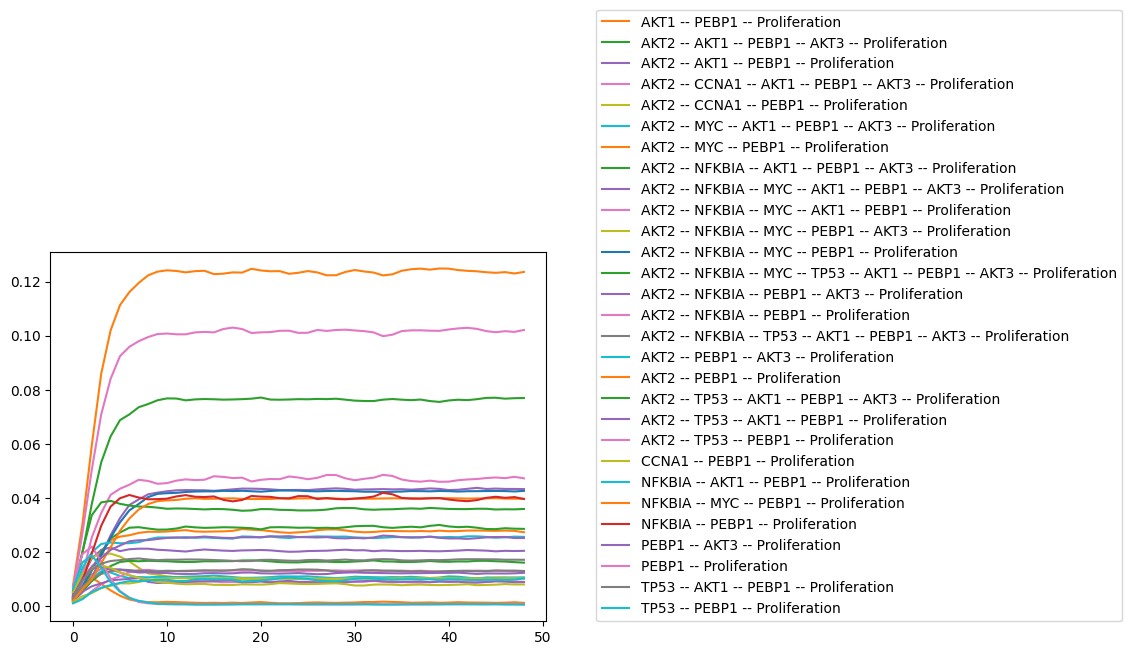

In [441]:
mutation, outputs_di = {"ESR1": 1}, {"Proliferation": 1, "PEBP1": 1, "TP53": 0, "AKT1": 1, "AKT2": 1, "AKT3": 1, "NFKBIA": 0, "MYC": 1, "CDK4": 1, "CCNA1": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p

#### Knockdown of PPP2R5E (expect AKT+, Proliferation-)

Most notably, our results showed that treatment of MCF-7 cells with EFA-CLA (compared to EFA) increased the mRNA expression of known tumor suppressors, such as TSC2, PTEN, PPP2R5E, and LMCD1. Information on PPP2R5E is limited, but it has been suggested as a potential negative regulator of PI3K/AKT signaling (2016). It has been also found to act as a tumor suppressor in breast cancer and gastric cancer cells [(ref)](https://doi.org/10.1186/s12263-016-0537-z) (Downregulation of PPP2R5E [(ref)](https://doi.org/10.1016/j.febslet.2014.05.068)). 

<nil>  {AKT1=1}  {AKT1=1,AKT3=1}  {AKT1=1,AKT3=1,Invasion=1}  \
prob  0.1605    0.0624           0.0147                      0.0053   

      {AKT1=1,Invasion=1}  {AKT2=1}  {AKT1=1,AKT2=1}  {AKT1=1,AKT2=1,AKT3=1}  \
prob               0.0238    0.1914           0.0529                   0.181   

      {AKT1=1,AKT2=1,AKT3=1,Invasion=1}  {AKT1=1,AKT2=1,Invasion=1}  \
prob                             0.0884                      0.0259   

      {AKT2=1,AKT3=1}  {AKT2=1,AKT3=1,Invasion=1}  {AKT2=1,Invasion=1}  \
prob           0.0434                      0.0132               0.0422   

      {AKT3=1}  {AKT3=1,Invasion=1}  {Invasion=1}  correct  total  
prob    0.0382               0.0126        0.0441       36     53

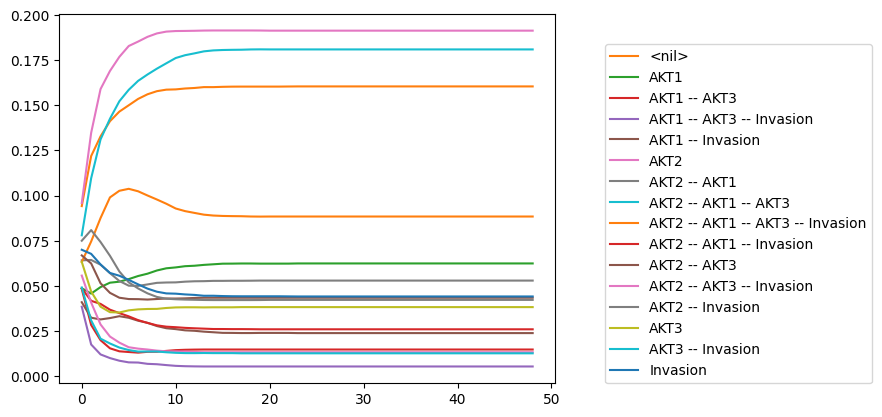

In [442]:
mutation, outputs_di = {"PPP2R5E": 0}, {"Invasion":0, "AKT1": 1, "AKT2": 1, "AKT3": 1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p 

#### Overexpression of PTEN (expect AKT-, TP53+, Proliferation-)

Matrine inhibited MCF-7 cell growth in a concentration-and time-dependent manner, by inducing apoptosis and cell cycle arrest at G1/S phase. Matrine up-regulated PTEN by downregulating miR-21 which in turn dephosphorylated Akt, resulting in accumulation of Bad, p21/WAF1/CIP1 and p27/KIP1. [(ref)](https://doi.org/10.1159/000341444)

up-regulation of the key upstream signaling factor, PTEN, in MCF-7/DOX cells inhibited Akt phosphorylation, which ultimately causes increase in their regulatory p53 levels affecting the induction of G2/M cell cycle arrest and apoptosis. [(ref)](https://doi.org/10.1016/j.mrfmmm.2010.10.007)

Error on: Proliferation!=0,AKT1!=0,AKT2!=0,AKT3!=0


{AKT1=1,AKT3=1,Proliferation=1}  {AKT1=1,Proliferation=1}  \
prob                           0.0142                    0.0672   

      {AKT1=1,AKT2=1,AKT3=1,Proliferation=1}  {AKT1=1,AKT2=1,Proliferation=1}  \
prob                                  0.2078                           0.0578   

      {AKT2=1,AKT3=1,Proliferation=1}  {AKT2=1,Proliferation=1}  \
prob                           0.0513                    0.2312   

      {AKT1=1,AKT2=1,AKT3=1,Proliferation=1,TP53=1}  \
prob                                         0.0593   

      {AKT1=1,AKT2=1,Proliferation=1,TP53=1}  \
prob                                  0.0189   

      {AKT2=1,AKT3=1,Proliferation=1,TP53=1}  {AKT2=1,Proliferation=1,TP53=1}  \
prob                                  0.0036                           0.0032   

      {AKT3=1,Proliferation=1}  {Proliferation=1}  \
prob                    0.0496             0.2045   

      {AKT1=1,AKT3=1,Proliferation=1,TP53=1}  {AKT1=1,Proliferation=1,TP53=1}  \
prob                                  0.0056                           0.0206   

      {AKT3=1,Proliferation=1,TP53=1}  {Proliferation=1,TP53=1}  correct  \
prob                            0.002                    0.0032       36   

      total  
prob     54

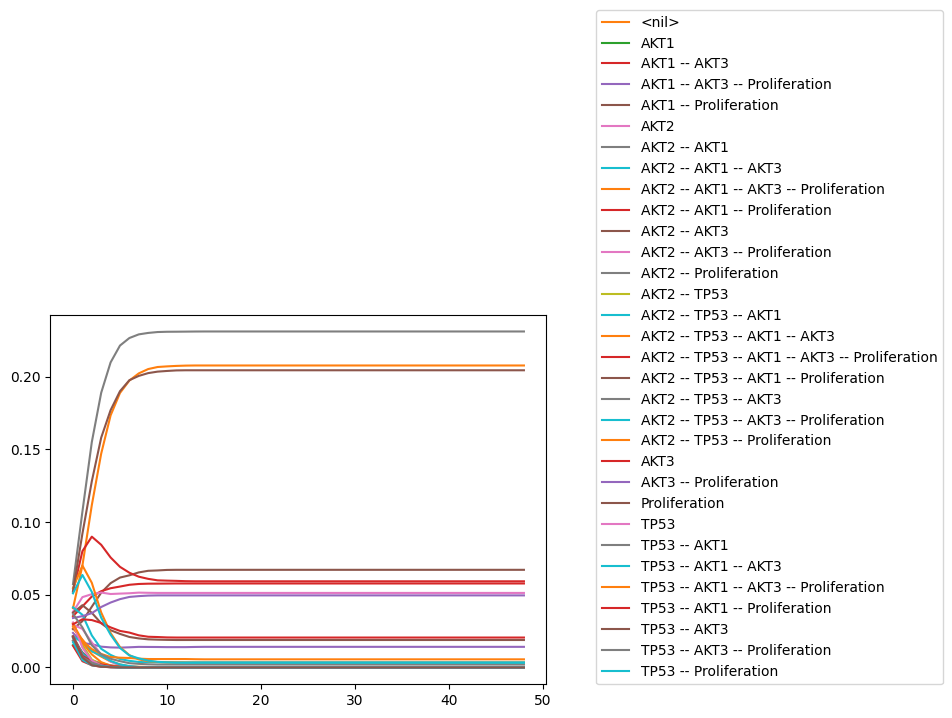

In [443]:
mutation, outputs_di = {"PTEN": 1}, {"Proliferation":0, "TP53": 1, "AKT1": 0, "AKT2": 0, "AKT3": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p 

#### Overexpression of YWHAZ (expect Apoptosis-, CTNNB1-, MYC-)

Moreover, the anti-apoptotic gene YWHAZ was confirmed as a target of miR-30c by luciferase reporter assay, and further studies indicated that the mechanism for miR-30c on the sensitivity of breast cancer cells involved YWHAZ and its downstream p38 mitogen-activated protein kinase (p38MAPK) pathway. Together, our findings provided evidence that miR-30c was one of the important miRNAs in doxorubicin resistance by regulating YWHAZ in the breast cancer cell line MCF-7/ADR. [(ref)](https://doi.org/10.1590/1414-431X20133324)

Moreover, miR-451 markedly inhibited expression of β-catenin via YWHAZ and subsequently inhibited downstream gene cyclin D1, c-Myc expression. [(ref)](https://doi.org/10.1038/cddis.2017.460)

<nil>  {CTNNB1=1}  {MYC=1}  {CTNNB1=1,MYC=1}  correct  total
prob  0.7359      0.1596   0.0837            0.0208       37     55

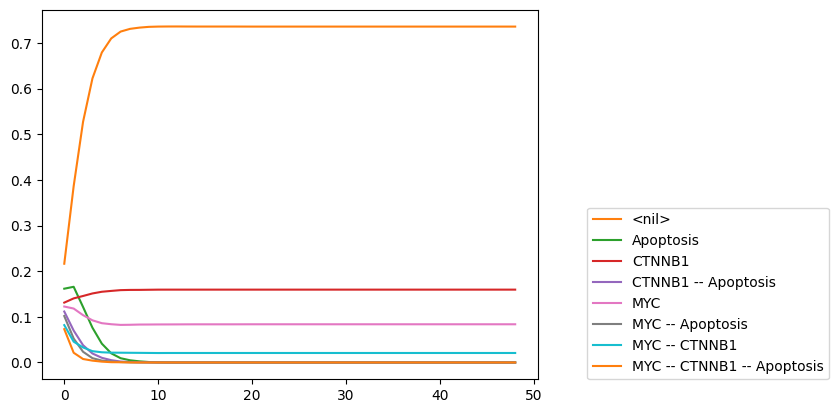

In [444]:
mutation, outputs_di = {"YWHAZ": 1}, {"Apoptosis":0, "CTNNB1": 0, "MYC": 0}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p 

#### Overexpression of ESR1 and MYC (expect TFDP1+)

our results suggest direct transcriptional regulation of TFDP1 by ERα and MYC [(ref)](https://doi.org/10.1038/msb.2008.25)

<nil>  {TFDP1=1}  correct  total
prob  0.869      0.131       38     56

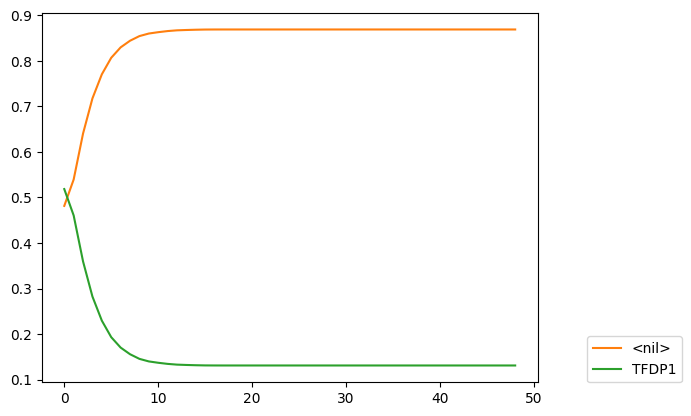

In [446]:
mutation, outputs_di = {"ESR1": 1, "MYC": 1}, {"TFDP1":1}
count_total, count_correct, p = test_mutation(mutation, outputs_di, count_total, count_correct)
p 

### 7. Final accuracy of the network across all experiments

In [447]:
("%.3f" % (count_correct*100/count_total))+"%"+" accuracy (%d experiments)" % count_total

'67.857% accuracy (56 experiments)'